Yusuf Demir 2210356074

### Dataset Preparation

In this part, we prepared our dataset to use it with the YOLOv8 model.

1. **Folder Structure Created**  
   We created a new folder structure under `cars_dataset/` to match YOLOv8 requirements:
   - `images/train`, `images/val`, `images/test`
   - `labels/train`, `labels/val`, `labels/test`

2. **Annotation Conversion**  
   Original annotation files were in the format:  
   `xmin ymin xmax ymax class_id`  
   We converted them to YOLO format:  
   `class_id x_center y_center width height`  
   (All values are normalized between 0 and 1.)

3. **Image and Label Organization**  
   Each image was copied to its related folder (`train`, `val`, or `test`)  
   The corresponding label was saved in YOLO format with the same filename.

4. **Data Configuration File (`data.yaml`)**  
   We created a file named `data.yaml` to describe our dataset.  
   It contains the paths to training, validation, and test sets, and the class name (`car`).

Now the dataset is ready for training with YOLOv8. 

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
import shutil
import os

In [3]:
# Read-only input path
input_path = "/kaggle/input/"

# Writable output path
working_path = "/kaggle/working/cars_dataset"

# Copy dataset to working directory
shutil.copytree(input_path, working_path, dirs_exist_ok=True)

'/kaggle/working/cars_dataset'

In [4]:
# Create necessary folders for YOLOv8 training

import os

root_dir = "/kaggle/working/cars_dataset"

# Create new folders for YOLOv8-style dataset
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(root_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(root_dir, "labels", split), exist_ok=True)

In [5]:
# Convert bounding boxes from (xmin, ymin, xmax, ymax) to YOLO format

def convert_bbox(img_w, img_h, xmin, ymin, xmax, ymax):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return [0, x_center, y_center, width, height]  # class_id = 0 for 'car'

In [6]:
# Read annotation files and convert them to YOLO format
# Move images and write new label files to YOLOv8 folder structure

import shutil
from PIL import Image

# Paths
anno_dir = os.path.join(root_dir, "Annotations")
img_dir = os.path.join(root_dir, "Images")
split_dir = os.path.join(root_dir, "ImageSets")

# Loop over each split (train, val, test)
for split in ["train", "val", "test"]:
    # Read file names (without extension) for the split
    with open(os.path.join(split_dir, f"{split}.txt"), "r") as f:
        image_names = [line.strip() for line in f]

    for name in image_names:
        image_path = os.path.join(img_dir, f"{name}.png")
        annotation_path = os.path.join(anno_dir, f"{name}.txt")
        new_image_path = os.path.join(root_dir, "images", split, f"{name}.png")
        new_label_path = os.path.join(root_dir, "labels", split, f"{name}.txt")

        # Copy image to new folder
        shutil.copy(image_path, new_image_path)

        # Get image size for normalization
        img = Image.open(image_path)
        w, h = img.size

        yolo_lines = []
        with open(annotation_path, "r") as f:
            for line in f:
                coords = list(map(int, line.strip().split()))
                xmin, ymin, xmax, ymax = coords[:4]  # take only the first 4 values
                yolo_bbox = convert_bbox(w, h, xmin, ymin, xmax, ymax)
                yolo_lines.append(" ".join(f"{x:.6f}" for x in yolo_bbox))


        # Write YOLO-formatted label file
        with open(new_label_path, "w") as f:
            f.write("\n".join(yolo_lines))

In [7]:
# Updated data.yaml for Kaggle environment (absolute paths)

yaml_content = f"""
train: {os.path.join(root_dir, "images/train")}
val: {os.path.join(root_dir, "images/val")}
test: {os.path.join(root_dir, "images/test")}

nc: 1
names: ['car']
"""

with open(os.path.join(root_dir, "data.yaml"), "w") as f:
    f.write(yaml_content.strip())


In [8]:
from ultralytics import YOLO

# Load YOLOv8 nano
model = YOLO("yolov8n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 83.7MB/s]


### YOLOv8n Model Architecture

The YOLOv8n (nano) architecture consists of 3 main parts: **Backbone**, **Neck**, and **Head**. The architecture is implemented as a `Sequential` model with 23 layers in total.

#### [Backbone]
Responsible for extracting rich visual features from the input image.

| Index | Layer Type | Description                     |
|-------|------------|---------------------------------|
| (0)   | Conv       | Stem (initial convolution)      |
| (1)   | Conv       | Second convolution              |
| (2)   | C2f        | Backbone block 1                |
| (3)   | Conv       |                                 |
| (4)   | C2f        | Backbone block 2                |
| (5)   | Conv       |                                 |
| (6)   | C2f        | Backbone block 3                |
| (7)   | Conv       |                                 |
| (8)   | C2f        | Backbone block 4                |
| (9)   | SPPF       | Spatial Pyramid Pooling - Fast  |

#### [Neck]
Combines features at multiple scales for better object detection.

| Index | Layer Type | Description         |
|-------|------------|---------------------|
| (10)  | Upsample   |                     |
| (11)  | Concat     | Feature fusion      |
| (12)  | C2f        |                     |
| (13)  | Upsample   |                     |
| (14)  | Concat     | Feature fusion      |
| (15)  | C2f        |                     |
| (16)  | Conv       |                     |
| (17)  | Concat     | Feature fusion      |
| (18)  | C2f        |                     |
| (19)  | Conv       |                     |
| (20)  | Concat     | Feature fusion      |
| (21)  | C2f        |                     |

#### [Head]
Performs final object detection predictions (bounding boxes + class scores).

| Index | Layer Type | Description                           |
|-------|------------|---------------------------------------|
| (22)  | Detect     | Detection head: class + box outputs   |

This detailed breakdown helps in identifying which blocks to freeze during transfer learning. For instance:
- **Freezing first 5 blocks:** Layers 0–4
- **Freezing first 10 blocks:** Layers 0–9 (entire backbone)
- **Freezing first 21 blocks:** Layers 0–21 (everything except detection head)


## Training

In [9]:
# Path to the data.yaml file
data_path = "cars_dataset/data.yaml"

# Common training settings
epochs = 50
imgsz = 640

### Note on Epoch Selection

In this study, we fixed the number of training epochs to **50** across all model configurations to ensure a fair comparison.

However, it is important to note that:

- In practice, **increasing the number of epochs** can lead to better performance, especially for models with more trainable layers (e.g., full training).
- Models with frozen layers often converge faster and may not benefit significantly from longer training, but **fully trainable models typically require more epochs** to reach optimal performance.
- Due to time and resource constraints, we used a standard 50-epoch setup, which provides a reasonable trade-off between performance and efficiency for this assignment.

In [10]:
from ultralytics import YOLO
from IPython.display import Image, display

def run_training(config):
    print(f"Training: {config['name']}")
    model = YOLO("yolov8n.pt")
    model.train(
        data=data_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=config['batch'],
        lr0=config['lr0'],
        optimizer=config['optimizer'],
        freeze=config['freeze'],
        name=config['name']
    )

In [11]:
def display_results_images(model_names, base_dir="runs/detect", width=600):
    """
    Display the training results.png image for each model.

    Parameters:
        model_names (list): List of model folder names.
        base_dir (str): Root directory where model folders are located.
        width (int): Display width for images.
    """
    for model_name in model_names:
        image_path = os.path.join(base_dir, model_name, "results.png")
        if os.path.exists(image_path):
            print(f"Results for {model_name}")
            display(Image(filename=image_path, width=width))
        else:
            print(f"results.png not found for {model_name}")

### Freeze 5 Blocks (stem + C2f_1 + C2f_2)

We freeze the first 5 layers of the YOLOv8n model:
- Stem (initial convolutional layer)
- Backbone block 1 (C2f_1)
- Backbone block 2 (C2f_2)

**Advantages:**
- Preserves low-level and early mid-level features.
- Faster convergence since many parameters are frozen.

**Disadvantages:**
- Low-level features may not generalize well to aerial images.
- May not adapt sufficiently to the new domain if early backbone is suboptimal.

In [12]:
param_variants = [
    {"name": "yolov8n_sgd_lr001_freeze5", "batch": 16, "lr0": 0.001, "optimizer": "SGD", "freeze": 5},
    {"name": "yolov8n_sgd_lr0005_freeze5", "batch": 16, "lr0": 0.0005, "optimizer": "SGD", "freeze": 5},
    {"name": "yolov8n_adam_lr001_freeze5", "batch": 16, "lr0": 0.001, "optimizer": "Adam", "freeze": 5},
    {"name": "yolov8n_adam_lr0001_freeze5", "batch": 32, "lr0": 0.0001, "optimizer": "Adam", "freeze": 5},
]


for config in param_variants:
    run_training(config)

Training: yolov8n_sgd_lr001_freeze5
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_sgd_lr001_freeze5, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patie

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4689.5±1097.7 MB/s, size: 1365.5 KB)


train: Scanning /kaggle/working/cars_dataset/labels/train... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:02<00:00, 401.87it/s]

train: New cache created: /kaggle/working/cars_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2522.2±1631.5 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 226.51it/s]

val: New cache created: /kaggle/working/cars_dataset/labels/val.cache


Plotting labels to runs/detect/yolov8n_sgd_lr001_freeze5/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_sgd_lr001_freeze5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.56G       1.56      2.211      1.122        779        640: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


                   all        200      11906       0.84      0.779      0.878      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       6.5G      1.316     0.9948       1.01        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


                   all        200      11906      0.941      0.889      0.956      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.51G      1.209     0.8111     0.9768        600        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        200      11906      0.956      0.918      0.968      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.52G      1.166     0.7532     0.9515       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

                   all        200      11906       0.96      0.931      0.973      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.53G      1.116     0.7054     0.9401       1092        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906      0.973      0.939      0.977      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.54G      1.103     0.6826     0.9328       1120        640: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        200      11906      0.969      0.941      0.978      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.55G      1.062     0.6637     0.9246        940        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        200      11906       0.98      0.945       0.98      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.56G      1.055     0.6529     0.9193        831        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906      0.982      0.945       0.98      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.57G      1.054     0.6467     0.9153        664        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.982      0.949      0.981      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.58G      1.036     0.6335     0.9129       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.983      0.953      0.982      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       6.6G      1.022     0.6218     0.9094       1226        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.986      0.955      0.985      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.61G       1.01     0.6154     0.9079        624        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        200      11906      0.985      0.955      0.985      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.62G      1.011     0.6087      0.903       1065        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        200      11906      0.987      0.953      0.986      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.62G      1.003     0.6009     0.9001        645        640: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        200      11906      0.987      0.956      0.986      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.64G     0.9822     0.5919     0.8978        908        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        200      11906      0.987      0.958      0.987      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.65G     0.9857     0.5905     0.8983        820        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        200      11906      0.986      0.958      0.988      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.67G     0.9782     0.5811     0.8949        838        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.988       0.96      0.988      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.67G     0.9704     0.5792     0.8963        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


                   all        200      11906      0.987      0.963      0.989      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.78G     0.9757     0.5753     0.8912        855        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        200      11906      0.986      0.963       0.99      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.79G     0.9649     0.5702     0.8932       1198        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.987      0.965       0.99      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       7.8G     0.9638     0.5675      0.892        734        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906      0.987      0.965       0.99      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       7.8G     0.9632     0.5643     0.8893        978        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        200      11906      0.987      0.968      0.991       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.82G     0.9726     0.5641     0.8856       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        200      11906      0.987      0.968      0.991      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.83G     0.9548      0.557     0.8864        862        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        200      11906      0.987      0.969      0.991      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.84G     0.9519     0.5572     0.8867       1059        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


                   all        200      11906      0.988      0.969      0.991      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.85G     0.9485     0.5529     0.8886        858        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        200      11906      0.987      0.968      0.991      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.87G     0.9577     0.5533     0.8825        671        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


                   all        200      11906      0.988      0.969      0.992      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.88G     0.9458      0.546     0.8847        703        640: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        200      11906      0.987       0.97      0.992      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.89G     0.9389     0.5425     0.8844        613        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906      0.989      0.969      0.992      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.89G     0.9411      0.543     0.8814       1008        640: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.988       0.97      0.992      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.91G     0.9322     0.5384     0.8819        757        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]

                   all        200      11906      0.987       0.97      0.992      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.92G     0.9408     0.5413     0.8823       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906      0.988       0.97      0.992      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.93G     0.9352     0.5419     0.8835        559        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


                   all        200      11906      0.988      0.971      0.992      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.94G     0.9202     0.5303     0.8802        748        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        200      11906      0.988      0.971      0.992      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.96G     0.9256     0.5364     0.8813        730        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


                   all        200      11906      0.988      0.971      0.992      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.66G     0.9183     0.5298     0.8787        731        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


                   all        200      11906      0.988      0.971      0.992      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.46G     0.9321     0.5335     0.8783       1068        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        200      11906      0.988      0.972      0.992      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.38G     0.9278     0.5279     0.8791        750        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.989      0.972      0.992      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.38G     0.9307     0.5281     0.8757        878        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        200      11906      0.989      0.972      0.992      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.38G     0.9261     0.5271      0.877       1048        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


                   all        200      11906      0.988      0.973      0.992      0.785
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.38G     0.8823      0.567     0.8816        669        640: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.989      0.973      0.992      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.38G     0.8732     0.5378     0.8795        577        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.989      0.974      0.993      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.38G     0.8671     0.5246     0.8784        444        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.988      0.973      0.993      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.38G     0.8627     0.5241     0.8753        422        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        200      11906      0.989      0.973      0.993      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.38G     0.8514     0.5128     0.8762        483        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.989      0.973      0.992      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.38G     0.8634     0.5184     0.8734        408        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


                   all        200      11906      0.988      0.973      0.993      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.38G      0.854     0.5135     0.8737        407        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        200      11906      0.988      0.974      0.993      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.38G     0.8456     0.5079     0.8751        695        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906      0.988      0.973      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.38G     0.8553     0.5086     0.8752        595        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.989      0.973      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.38G     0.8381     0.5031     0.8728        592        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


                   all        200      11906      0.989      0.973      0.993      0.789

50 epochs completed in 0.285 hours.
Optimizer stripped from runs/detect/yolov8n_sgd_lr001_freeze5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sgd_lr001_freeze5/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sgd_lr001_freeze5/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


                   all        200      11906      0.988      0.972      0.993      0.789


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/yolov8n_sgd_lr001_freeze5
Training: yolov8n_sgd_lr0005_freeze5
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1859.7±2061.0 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_sgd_lr0005_freeze5/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_sgd_lr0005_freeze5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       5.7G      1.597      2.336      1.139        779        640: 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.191      0.965      0.768       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.61G       1.37      1.224      1.036        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all        200      11906      0.892       0.85      0.931      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.61G      1.263     0.9006     0.9983        600        640: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906      0.945      0.895      0.958      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.61G      1.211     0.8202     0.9692       1112        640: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


                   all        200      11906      0.962      0.924      0.969      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.61G      1.152     0.7653     0.9551       1092        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        200      11906      0.963       0.93      0.973      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.61G      1.134      0.733     0.9459       1120        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        200      11906      0.963      0.935      0.975      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.61G      1.095      0.709     0.9375        940        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906       0.97      0.934      0.977      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.61G      1.085     0.6947     0.9312        831        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        200      11906      0.975      0.937      0.977      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.61G      1.086     0.6872     0.9279        664        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


                   all        200      11906      0.976      0.938      0.978      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.61G      1.065     0.6722     0.9251       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        200      11906      0.979      0.942      0.979      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.61G      1.049     0.6583     0.9211       1226        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


                   all        200      11906      0.979      0.945       0.98      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.61G      1.038     0.6524     0.9194        624        640: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.979      0.946       0.98       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.61G      1.039     0.6461     0.9141       1065        640: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        200      11906      0.982      0.946      0.981      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.61G      1.033      0.639     0.9112        645        640: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        200      11906      0.979      0.948      0.981      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.61G       1.01     0.6299     0.9087        908        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        200      11906      0.984      0.948      0.982      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.61G      1.016     0.6284     0.9093        820        640: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


                   all        200      11906      0.982      0.949      0.983      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.61G      1.009     0.6184     0.9058        838        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        200      11906      0.986      0.952      0.983      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.61G      1.001     0.6176     0.9072        669        640: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        200      11906      0.985      0.955      0.984      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       7.7G      1.008     0.6146     0.9024        855        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        200      11906      0.985      0.953      0.986      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       7.7G     0.9976     0.6091     0.9044       1198        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        200      11906      0.985      0.956      0.986      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       7.7G     0.9968     0.6065     0.9033        734        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        200      11906      0.985      0.958      0.986      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       7.7G      0.997     0.6029     0.9008        978        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

                   all        200      11906      0.986      0.957      0.986       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       7.7G      1.007      0.604     0.8967       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906      0.987      0.956      0.987      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       7.7G     0.9894     0.5973     0.8981        862        640: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        200      11906      0.987      0.957      0.987      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       7.7G     0.9867     0.5979     0.8982       1059        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        200      11906      0.988       0.96      0.988       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       7.7G     0.9843     0.5934     0.9002        858        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        200      11906      0.987      0.958      0.987      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       7.7G     0.9936     0.5926     0.8937        671        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        200      11906      0.987      0.959      0.988      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       7.7G     0.9815     0.5863     0.8962        703        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        200      11906      0.986      0.958      0.988      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       7.7G     0.9753     0.5829     0.8961        613        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.987      0.959      0.988      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       7.7G     0.9768     0.5831     0.8924       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        200      11906      0.987      0.959      0.989      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       7.7G     0.9694     0.5799     0.8937        757        640: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.987      0.961      0.989      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       7.7G     0.9779     0.5816     0.8935       1008        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906      0.988       0.96      0.989      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       7.7G     0.9714     0.5836     0.8948        559        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


                   all        200      11906      0.988      0.961      0.989      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       7.7G     0.9565     0.5708     0.8917        748        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


                   all        200      11906      0.988      0.961      0.989      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       7.7G      0.963      0.578     0.8928        730        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]

                   all        200      11906      0.988      0.962       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       7.7G     0.9566     0.5712     0.8905        731        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]

                   all        200      11906      0.986      0.963      0.989      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       7.7G     0.9714     0.5745     0.8899       1068        640: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.987      0.963      0.989      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       7.7G     0.9666     0.5687     0.8905        750        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


                   all        200      11906      0.987      0.964       0.99      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       7.7G     0.9713     0.5704     0.8875        878        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        200      11906      0.987      0.964      0.989      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       7.7G     0.9656     0.5691     0.8889       1048        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        200      11906      0.987      0.964       0.99      0.777


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       7.7G     0.9212     0.6389     0.8941        669        640: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        200      11906      0.987      0.965       0.99      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       7.7G     0.9122     0.5988      0.892        577        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        200      11906      0.987      0.967       0.99       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       7.7G     0.9062     0.5829     0.8899        444        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


                   all        200      11906      0.988      0.967       0.99      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       7.7G      0.903     0.5815     0.8871        422        640: 100%|██████████| 63/63 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        200      11906      0.987      0.967       0.99      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       7.7G     0.8895      0.568     0.8878        483        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        200      11906      0.988      0.966       0.99      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       7.7G      0.905     0.5744     0.8854        408        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.988      0.966       0.99      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       7.7G     0.8947     0.5685     0.8856        407        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        200      11906      0.987      0.966       0.99      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       7.7G      0.886     0.5634     0.8875        695        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        200      11906      0.987      0.966      0.991      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       7.7G      0.895     0.5633     0.8871        595        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        200      11906      0.987      0.966       0.99      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.7G     0.8765     0.5569     0.8846        592        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


                   all        200      11906      0.987      0.965      0.991      0.777

50 epochs completed in 0.289 hours.
Optimizer stripped from runs/detect/yolov8n_sgd_lr0005_freeze5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sgd_lr0005_freeze5/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sgd_lr0005_freeze5/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


                   all        200      11906      0.987      0.964      0.989      0.779


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to runs/detect/yolov8n_sgd_lr0005_freeze5
Training: yolov8n_adam_lr001_freeze5
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1683.8±1742.2 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_adam_lr001_freeze5/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_adam_lr001_freeze5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.62G      1.404      1.462     0.9942        779        640: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        200      11906       0.95      0.914      0.962      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.53G      1.202     0.7766     0.9287        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.972      0.933      0.977      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.54G      1.126     0.7008     0.9114        600        640: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        200      11906       0.97      0.937      0.981       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.55G      1.101     0.6641     0.9008       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        200      11906      0.981      0.958      0.986      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.56G      1.039     0.6158     0.8907       1092        640: 100%|██████████| 63/63 [00:17<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        200      11906      0.984      0.957      0.988      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.56G       1.03     0.5931     0.8869       1120        640: 100%|██████████| 63/63 [00:18<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        200      11906      0.988      0.967       0.99      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.56G       0.99     0.5705     0.8791        940        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        200      11906      0.988      0.971      0.991      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.56G     0.9776     0.5522     0.8748        831        640: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        200      11906      0.991      0.969      0.991      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.56G     0.9717     0.5456     0.8708        664        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.989      0.971      0.992      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.56G     0.9525      0.525     0.8692       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906       0.99      0.973      0.993      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.56G     0.9409     0.5174     0.8666       1226        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        200      11906       0.99      0.973      0.993      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.56G     0.9253     0.5081     0.8649        624        640: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906      0.991      0.976      0.993      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.56G     0.9278      0.502     0.8619       1065        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906       0.99      0.975      0.993      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.56G     0.9316     0.5004     0.8624        645        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        200      11906      0.991      0.978      0.993      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.56G     0.9067     0.4876     0.8593        908        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        200      11906      0.991      0.978      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.56G     0.8954     0.4805     0.8575        820        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        200      11906       0.99      0.979      0.994      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.56G     0.8934     0.4765     0.8561        838        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        200      11906      0.992      0.978      0.993      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.56G     0.8931     0.4718      0.858        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all        200      11906      0.991       0.98      0.994      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.67G     0.8909     0.4699     0.8537        855        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        200      11906      0.992       0.98      0.994      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.67G     0.8794     0.4645     0.8553       1198        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.992       0.98      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.67G     0.8772     0.4587     0.8536        734        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        200      11906      0.992      0.981      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.67G     0.8671     0.4529     0.8507        978        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906       0.99      0.981      0.994      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.67G     0.8776      0.458     0.8489       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.992       0.98      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.68G     0.8622     0.4473     0.8493        862        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906      0.992      0.983      0.994      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.68G      0.855     0.4429     0.8484       1059        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        200      11906      0.991       0.98      0.994       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.68G     0.8526     0.4434     0.8502        858        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        200      11906      0.991      0.982      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.68G      0.857     0.4417     0.8456        671        640: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        200      11906      0.991      0.982      0.994      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.68G     0.8477     0.4351      0.847        703        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        200      11906      0.991      0.983      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.68G     0.8378     0.4314     0.8456        613        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        200      11906      0.993       0.98      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.68G     0.8441     0.4326     0.8448       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


                   all        200      11906      0.992      0.983      0.994      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.68G     0.8361     0.4267     0.8448        757        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        200      11906      0.993      0.981      0.994      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.68G     0.8353     0.4266     0.8441       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        200      11906      0.994      0.982      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.68G     0.8302     0.4248     0.8443        559        640: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


                   all        200      11906      0.992      0.984      0.994      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.68G     0.8159     0.4158     0.8425        748        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        200      11906      0.992      0.982      0.994      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.68G     0.8204     0.4171     0.8429        730        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        200      11906      0.993      0.983      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.68G     0.8124     0.4134     0.8407        731        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.993      0.982      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.68G     0.8222     0.4154     0.8403       1068        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        200      11906      0.993      0.982      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.68G     0.8204      0.413     0.8407        750        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        200      11906      0.992      0.985      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.68G     0.8213      0.412     0.8389        878        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

                   all        200      11906      0.992      0.983      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.68G     0.8104     0.4088     0.8383       1048        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


                   all        200      11906      0.991      0.984      0.994      0.814
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.68G     0.7684     0.3961     0.8363        669        640: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        200      11906      0.992      0.982      0.994      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.69G     0.7638     0.3911     0.8361        577        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        200      11906      0.991      0.984      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.69G     0.7604     0.3847     0.8354        444        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        200      11906      0.993      0.984      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.69G     0.7514     0.3815     0.8322        422        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all        200      11906      0.992      0.984      0.994      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.69G     0.7409      0.376      0.833        483        640: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        200      11906      0.992      0.984      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.69G     0.7513     0.3799     0.8309        408        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        200      11906      0.993      0.984      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.69G     0.7434     0.3771     0.8312        407        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200      11906      0.993      0.984      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.69G     0.7342     0.3704     0.8315        695        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        200      11906      0.992      0.984      0.994      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.69G     0.7387     0.3707     0.8317        595        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        200      11906      0.993      0.984      0.994      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.69G     0.7247     0.3647     0.8298        592        640: 100%|██████████| 63/63 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        200      11906      0.993      0.984      0.994      0.822



50 epochs completed in 0.283 hours.
Optimizer stripped from runs/detect/yolov8n_adam_lr001_freeze5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_adam_lr001_freeze5/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_adam_lr001_freeze5/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


                   all        200      11906      0.993      0.984      0.994      0.822


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/yolov8n_adam_lr001_freeze5
Training: yolov8n_adam_lr0001_freeze5
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3078.8±2570.9 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_adam_lr0001_freeze5/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_adam_lr0001_freeze5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        10G      1.536        2.2      1.046       1214        640: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        200      11906      0.209      0.941      0.748      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.07G      1.293       1.04     0.9576        689        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


                   all        200      11906       0.91      0.801      0.921      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.7G      1.209     0.8783     0.9398        653        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        200      11906      0.966       0.91      0.965      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.64G      1.174     0.8047     0.9252        933        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


                   all        200      11906      0.979      0.932      0.975      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.64G      1.153     0.7775     0.9214       1109        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        200      11906      0.977      0.939      0.977      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.56G      1.128     0.7512     0.9137       1017        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


                   all        200      11906      0.982      0.943      0.979      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.63G      1.127     0.7381      0.911       1080        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        200      11906      0.983      0.942      0.979      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.2G      1.098     0.7173      0.904        927        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


                   all        200      11906      0.982      0.945       0.98      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.47G      1.075     0.7033     0.9003       1062        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        200      11906      0.984      0.946      0.981      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.23G       1.07      0.694     0.8967        767        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


                   all        200      11906      0.985      0.951      0.982      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.64G      1.055     0.6842     0.8959       1124        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        200      11906      0.981      0.948      0.983      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.38G      1.054     0.6779     0.8939        617        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


                   all        200      11906      0.983      0.953      0.985      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.21G      1.034     0.6651       0.89       1220        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        200      11906      0.984       0.95      0.985      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.21G      1.042     0.6609     0.8852        842        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all        200      11906      0.986      0.956      0.987      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.21G      1.015     0.6501     0.8845        597        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


                   all        200      11906      0.986      0.956      0.987      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.56G      1.012     0.6431     0.8868        960        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        200      11906      0.987      0.959      0.988      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.56G      1.016     0.6417     0.8817        616        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        200      11906      0.989       0.96      0.989      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.16G      1.004     0.6325     0.8819        696        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        200      11906      0.986      0.962      0.989      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.43G     0.9961     0.6289     0.8818       1121        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200      11906      0.989      0.961      0.989       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.97G      1.004     0.6239     0.8807       1124        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        200      11906      0.986      0.963       0.99      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.6G      1.006     0.6256     0.8803       1075        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


                   all        200      11906      0.987      0.962       0.99      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50        11G     0.9923     0.6194     0.8765        665        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        200      11906      0.987      0.965       0.99      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.6G     0.9897     0.6159     0.8753        792        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        200      11906      0.988      0.965       0.99      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.59G     0.9777     0.6117     0.8754        392        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        200      11906      0.986      0.964       0.99      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.76G     0.9749     0.6034     0.8728        867        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


                   all        200      11906      0.987      0.967       0.99      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.14G     0.9829     0.6093     0.8739       1153        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        200      11906      0.987      0.966       0.99      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.82G      0.969     0.5981     0.8733        753        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


                   all        200      11906      0.986      0.968      0.991      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.55G     0.9835     0.6028     0.8734       1228        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        200      11906      0.989      0.968      0.991      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.04G     0.9666     0.5929      0.871        905        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


                   all        200      11906       0.99      0.969      0.991      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.71G     0.9625     0.5928      0.871        806        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


                   all        200      11906       0.99       0.97      0.991      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50        11G     0.9612     0.5875     0.8695        826        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all        200      11906      0.989       0.97      0.991      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.18G     0.9595     0.5887     0.8704       1009        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        200      11906       0.99       0.97      0.991      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.11G     0.9513      0.582     0.8673        885        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        200      11906      0.989      0.969      0.991      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50        10G     0.9528     0.5817     0.8684        789        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


                   all        200      11906      0.989      0.971      0.992      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.92G     0.9557     0.5793     0.8686        918        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        200      11906      0.989      0.969      0.991      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.5G      0.947     0.5762     0.8666        688        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


                   all        200      11906       0.99      0.971      0.992      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.41G     0.9406     0.5741     0.8672        722        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        200      11906       0.99      0.971      0.992      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.61G     0.9618     0.5783      0.866       1107        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        200      11906       0.99       0.97      0.991      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.81G     0.9482     0.5764     0.8659        970        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        200      11906       0.99       0.97      0.991       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.81G     0.9355     0.5702     0.8649        686        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        200      11906       0.99      0.971      0.992      0.785


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.81G     0.9265     0.6869     0.8702        692        640: 100%|██████████| 32/32 [00:19<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        200      11906      0.989      0.972      0.992      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.82G     0.9057     0.6374     0.8647        657        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


                   all        200      11906      0.989      0.972      0.992      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.82G     0.8875     0.6067     0.8606        549        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200      11906      0.989      0.972      0.992      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.82G     0.8684     0.5945     0.8582        413        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


                   all        200      11906      0.989      0.972      0.992      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.82G     0.8748     0.5892     0.8565        510        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


                   all        200      11906      0.989      0.971      0.992      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.84G     0.8699     0.5835     0.8552        426        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all        200      11906       0.99      0.971      0.992      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.85G     0.8685     0.5811     0.8541        440        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


                   all        200      11906       0.99      0.972      0.992      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.85G     0.8629     0.5799     0.8561        681        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        200      11906       0.99      0.972      0.992      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.85G     0.8618     0.5758     0.8564        515        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        200      11906       0.99      0.972      0.992      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.85G     0.8599     0.5716     0.8559        642        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


                   all        200      11906       0.99      0.971      0.992      0.783

50 epochs completed in 0.266 hours.
Optimizer stripped from runs/detect/yolov8n_adam_lr0001_freeze5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_adam_lr0001_freeze5/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_adam_lr0001_freeze5/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


                   all        200      11906       0.99      0.971      0.992      0.785


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 10.0ms postprocess per image
Results saved to runs/detect/yolov8n_adam_lr0001_freeze5


Results for yolov8n_sgd_lr001_freeze5


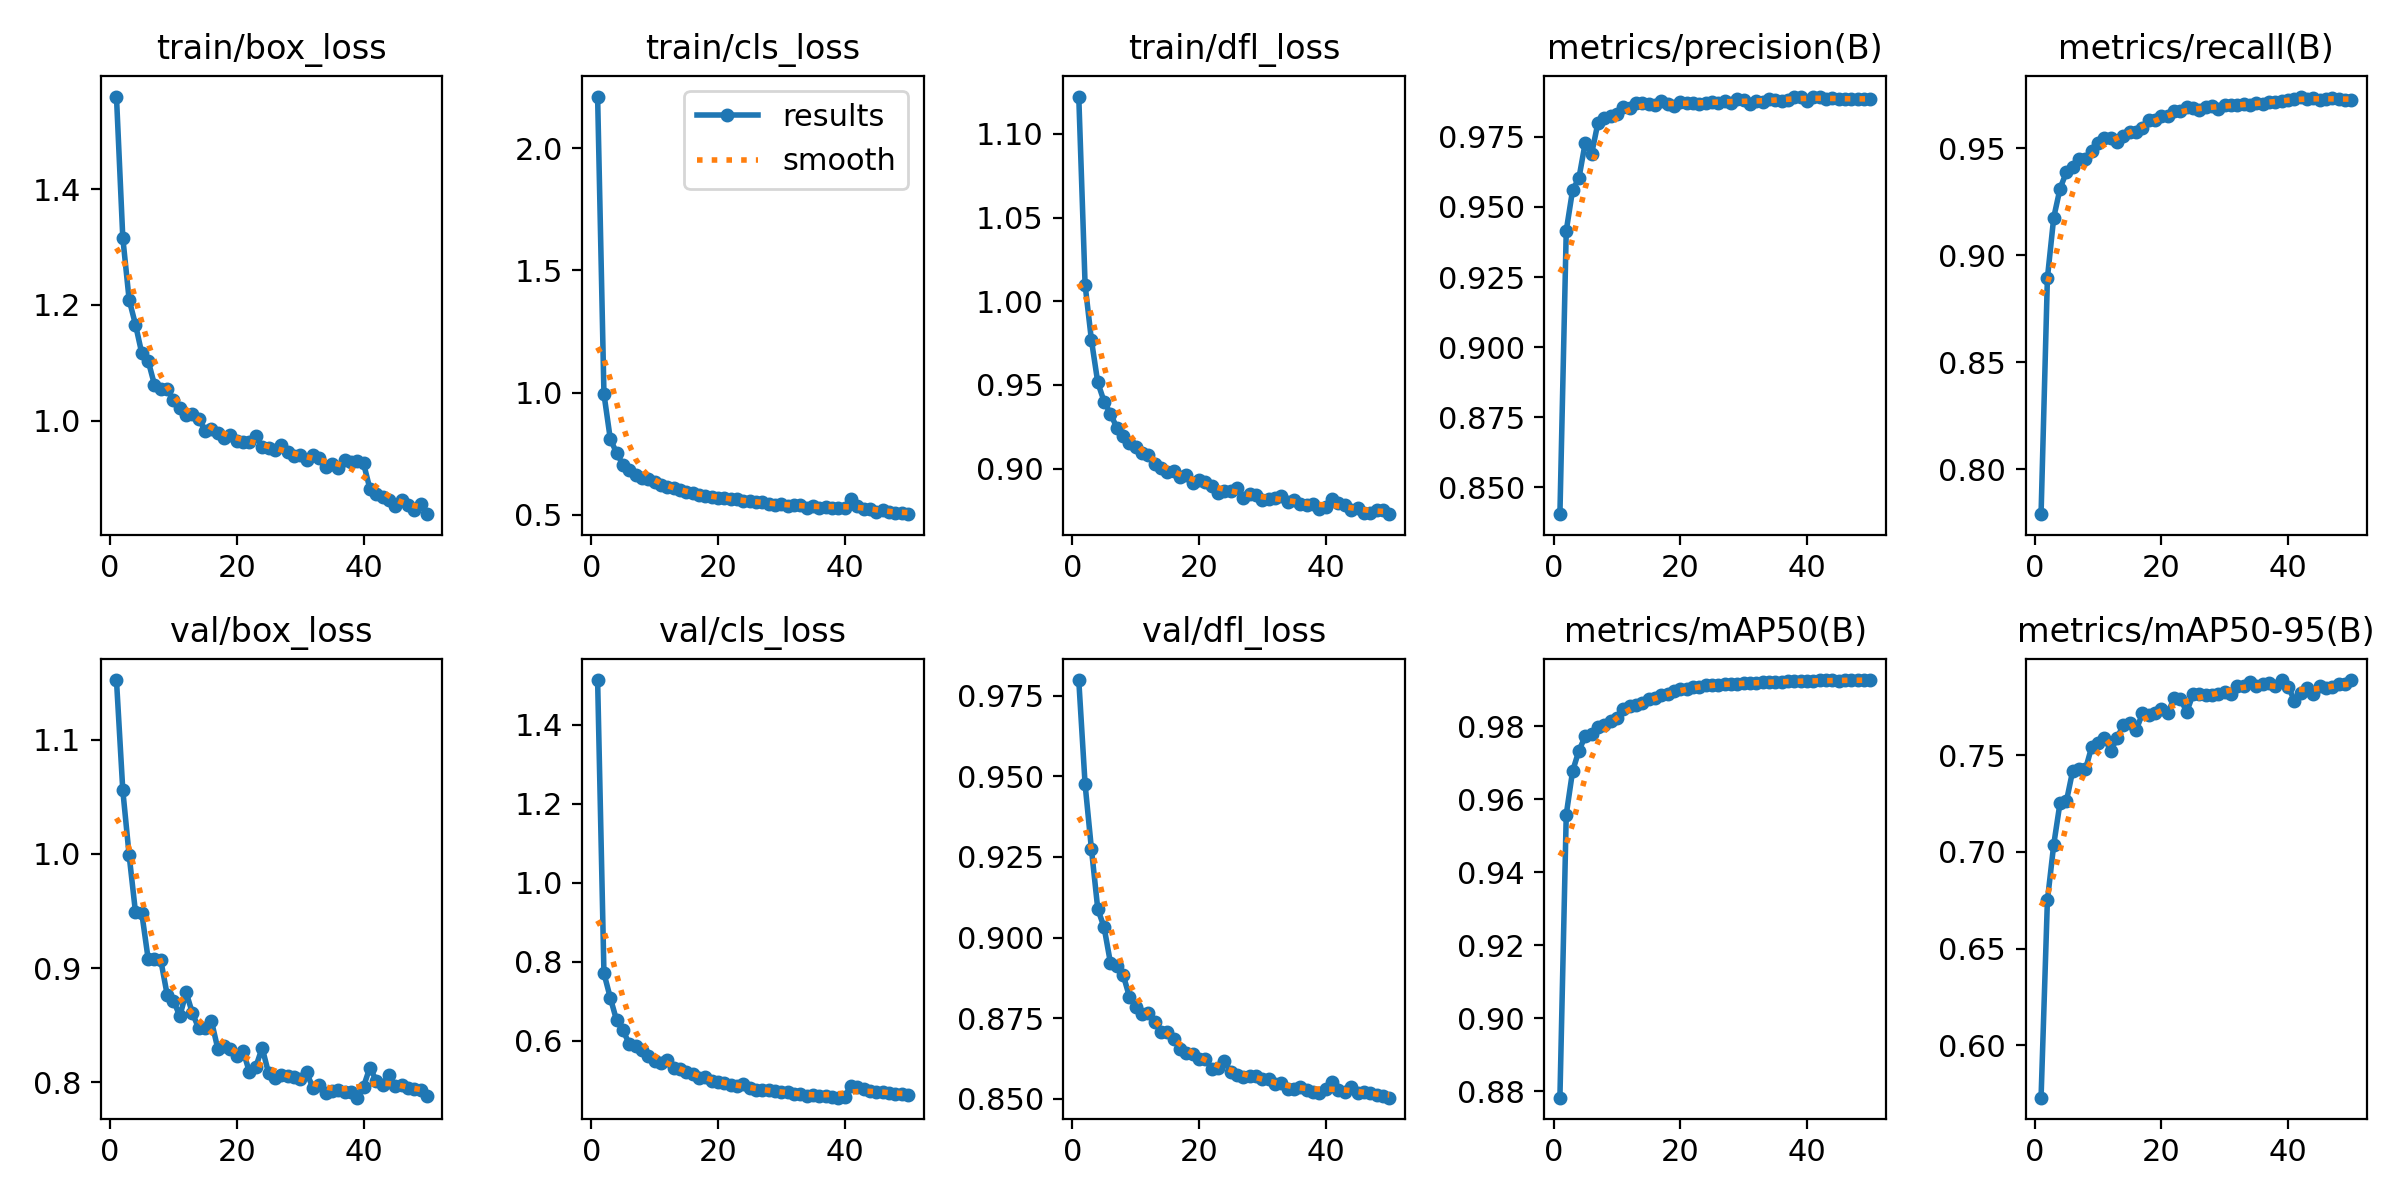

Results for yolov8n_sgd_lr0005_freeze5


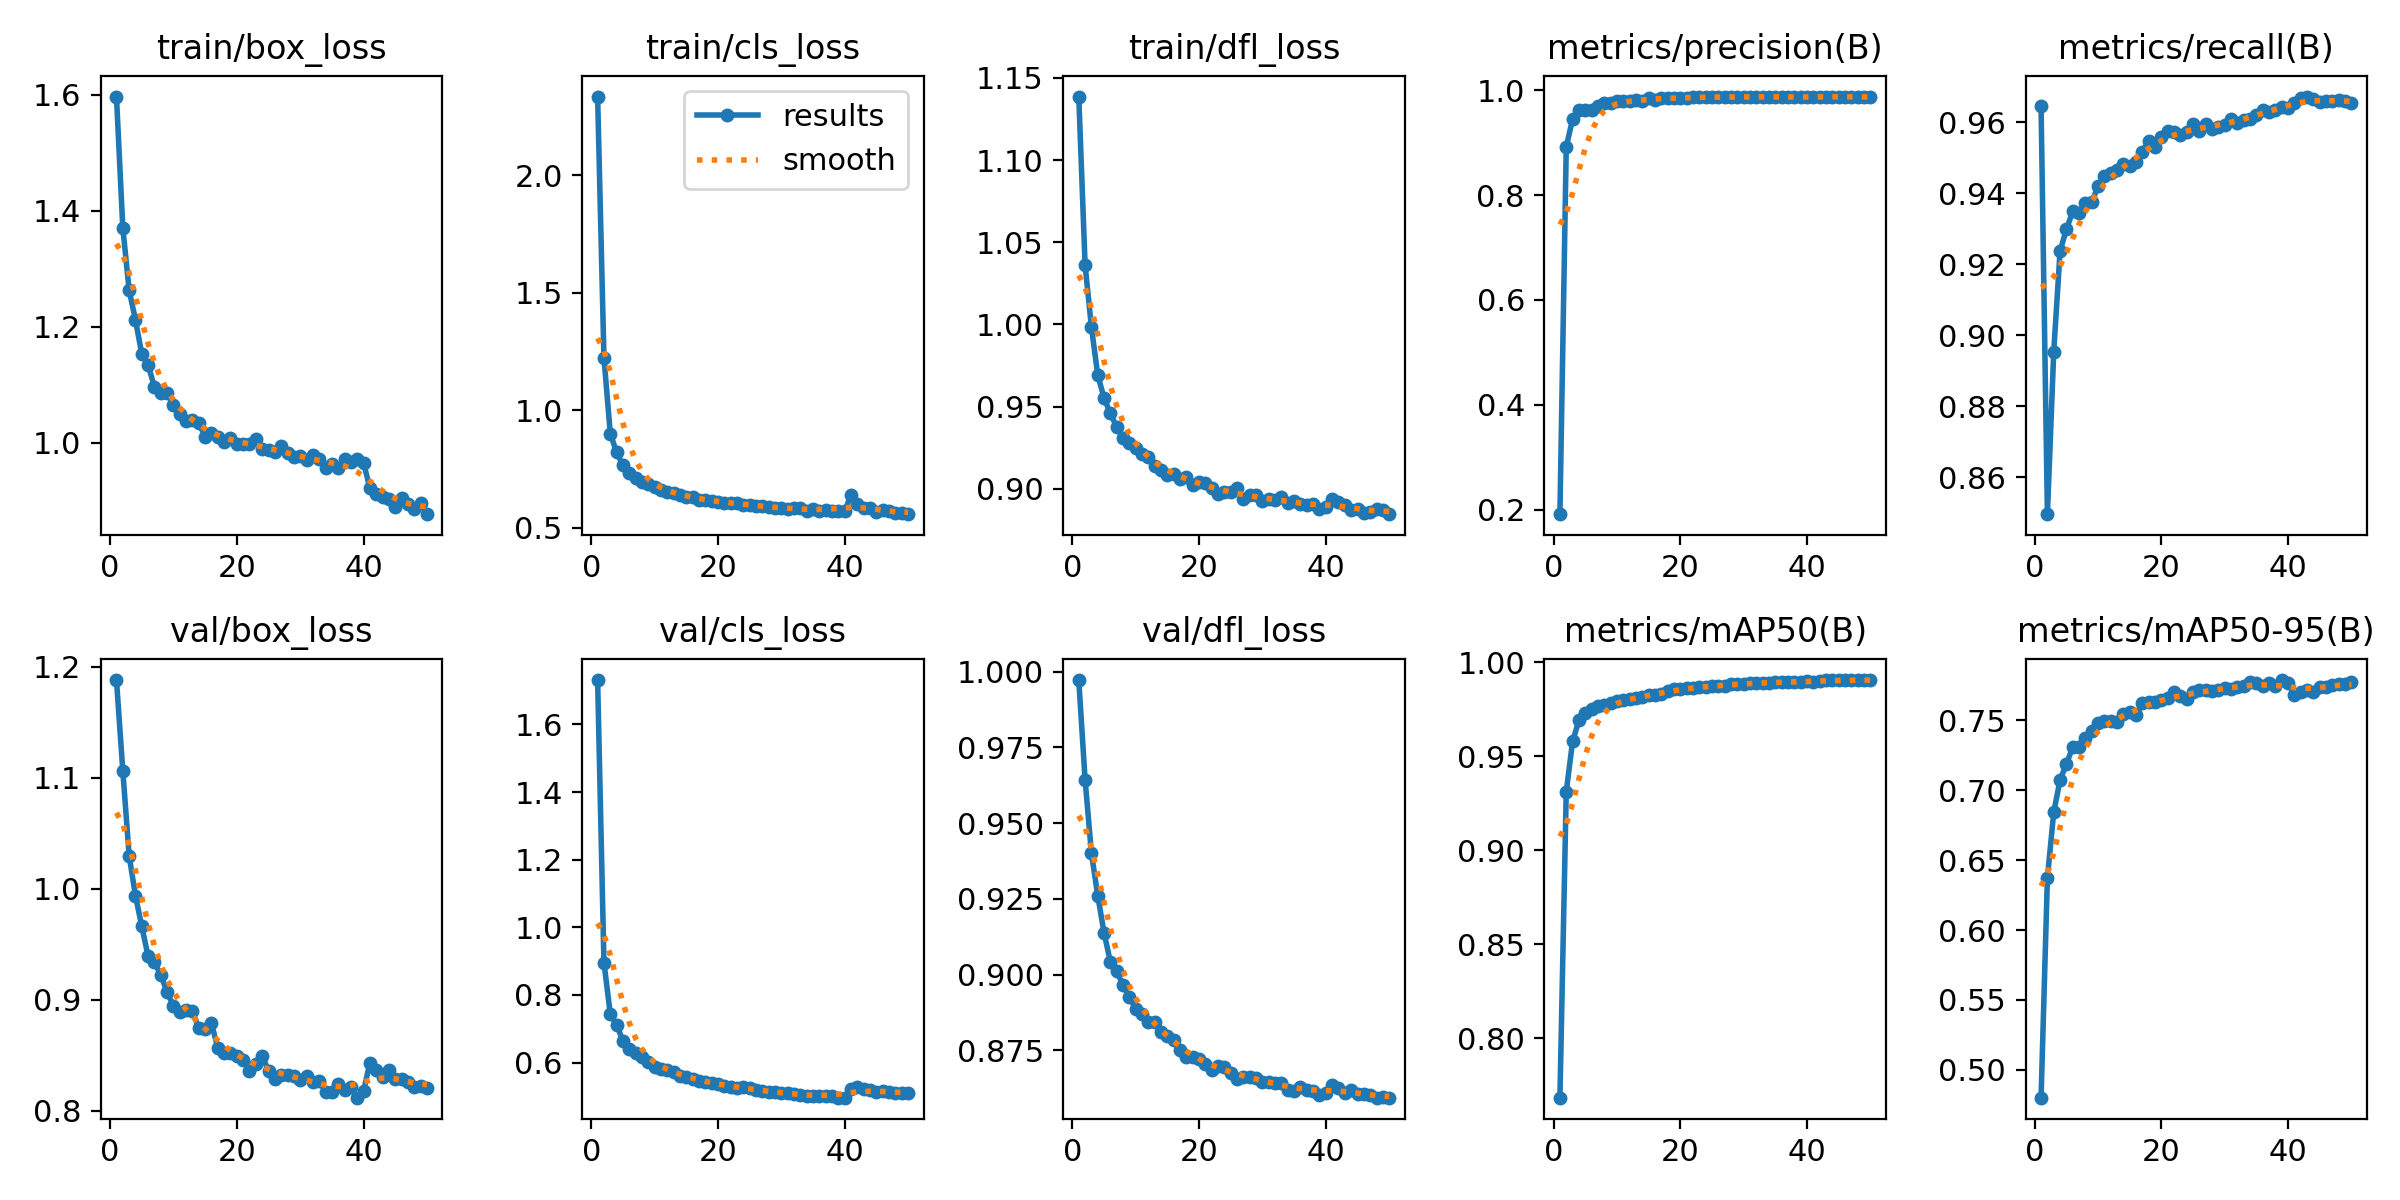

Results for yolov8n_adam_lr001_freeze5


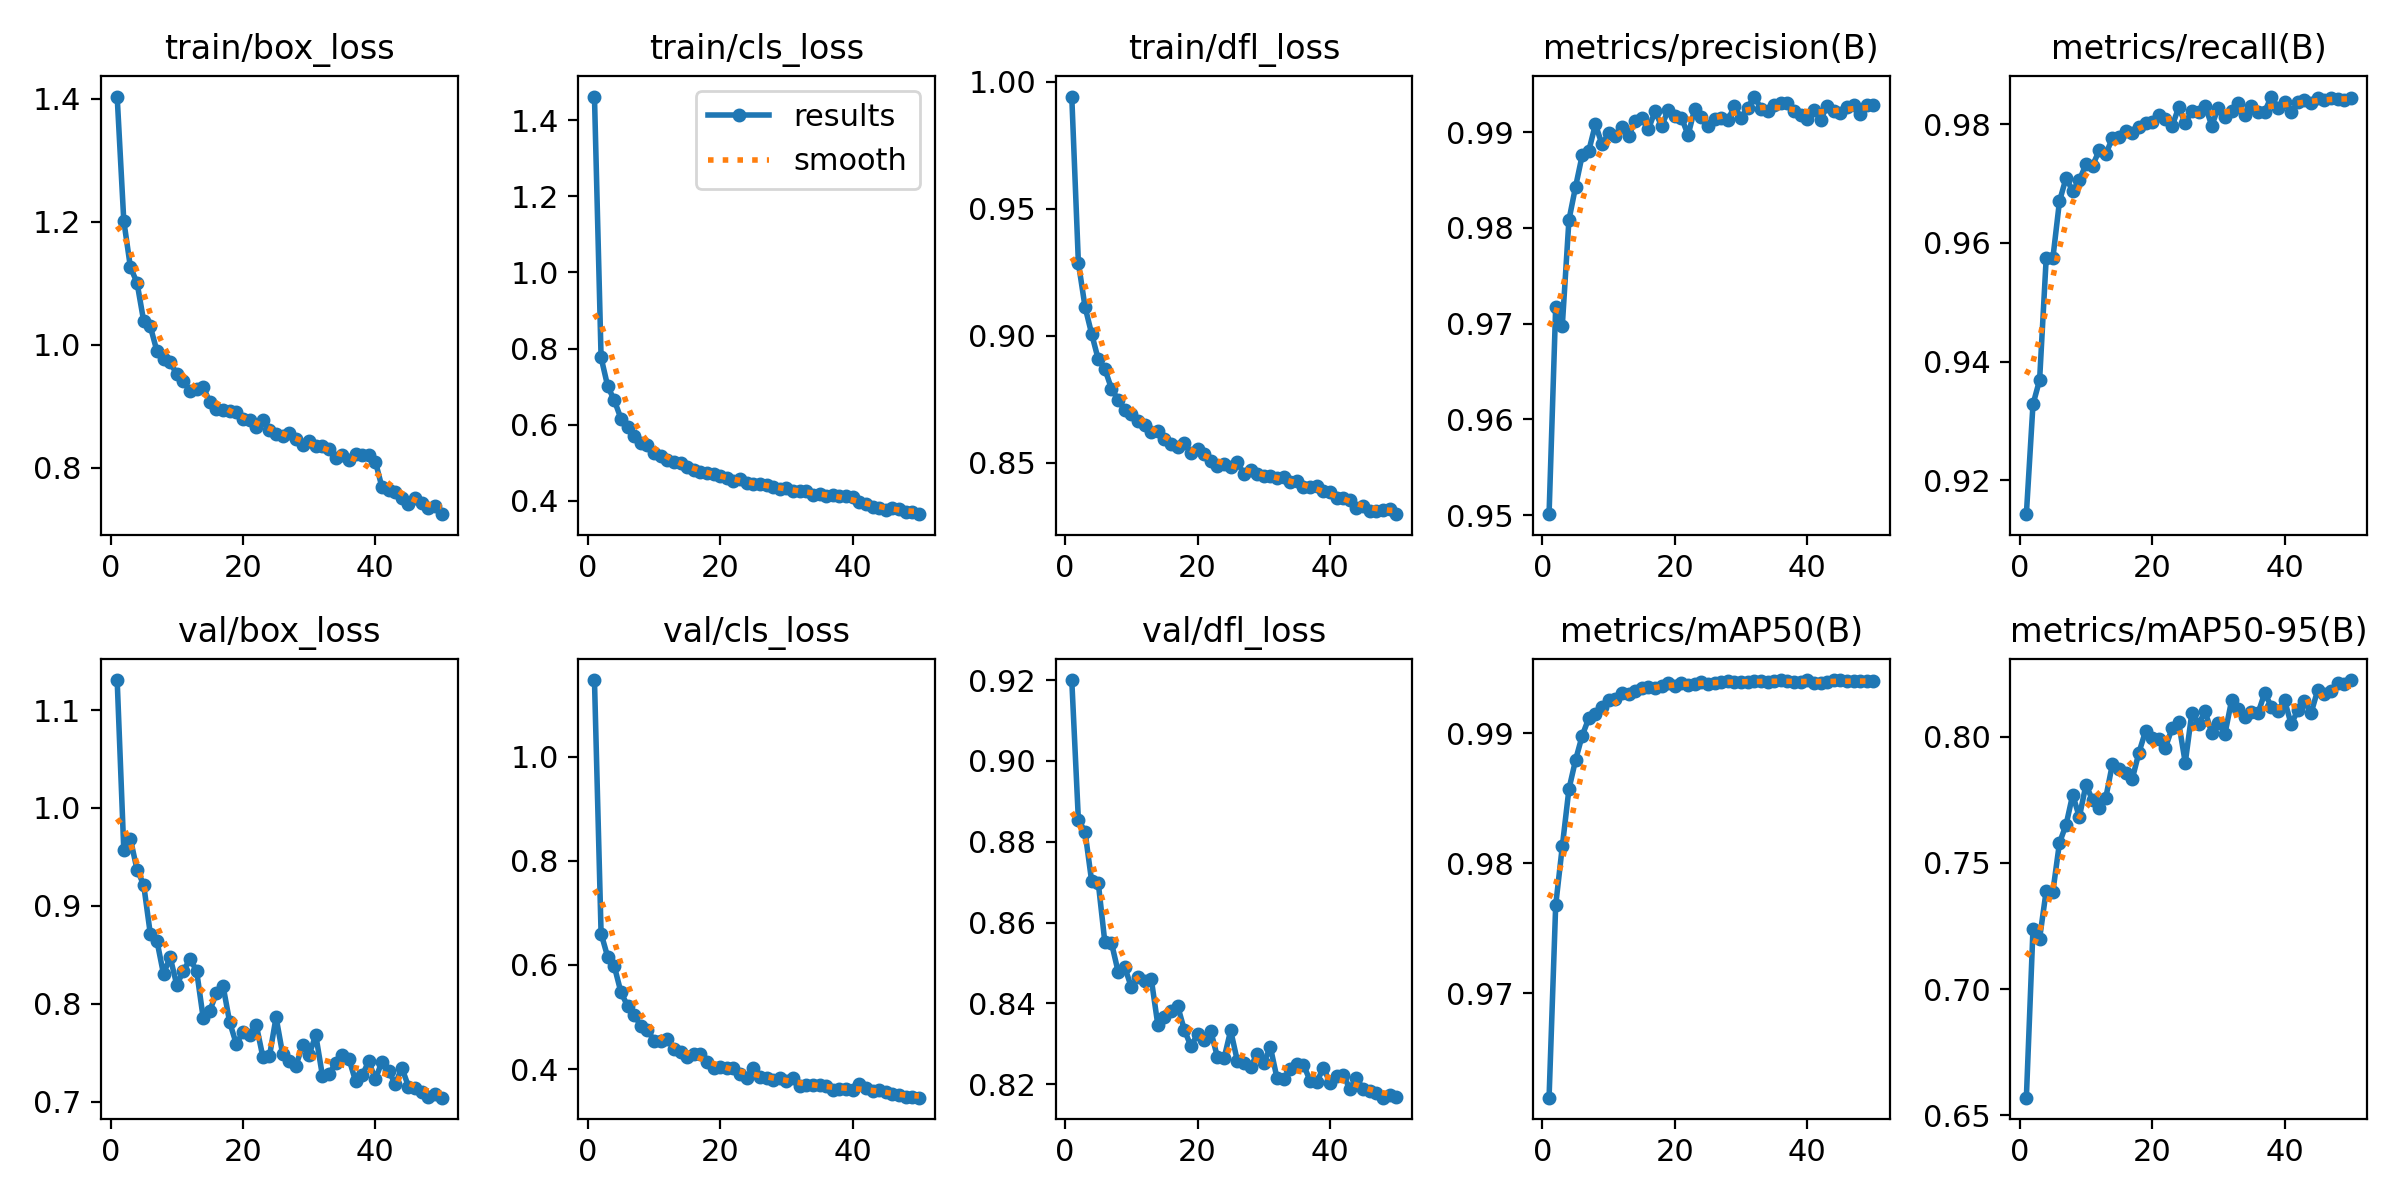

Results for yolov8n_adam_lr0001_freeze5


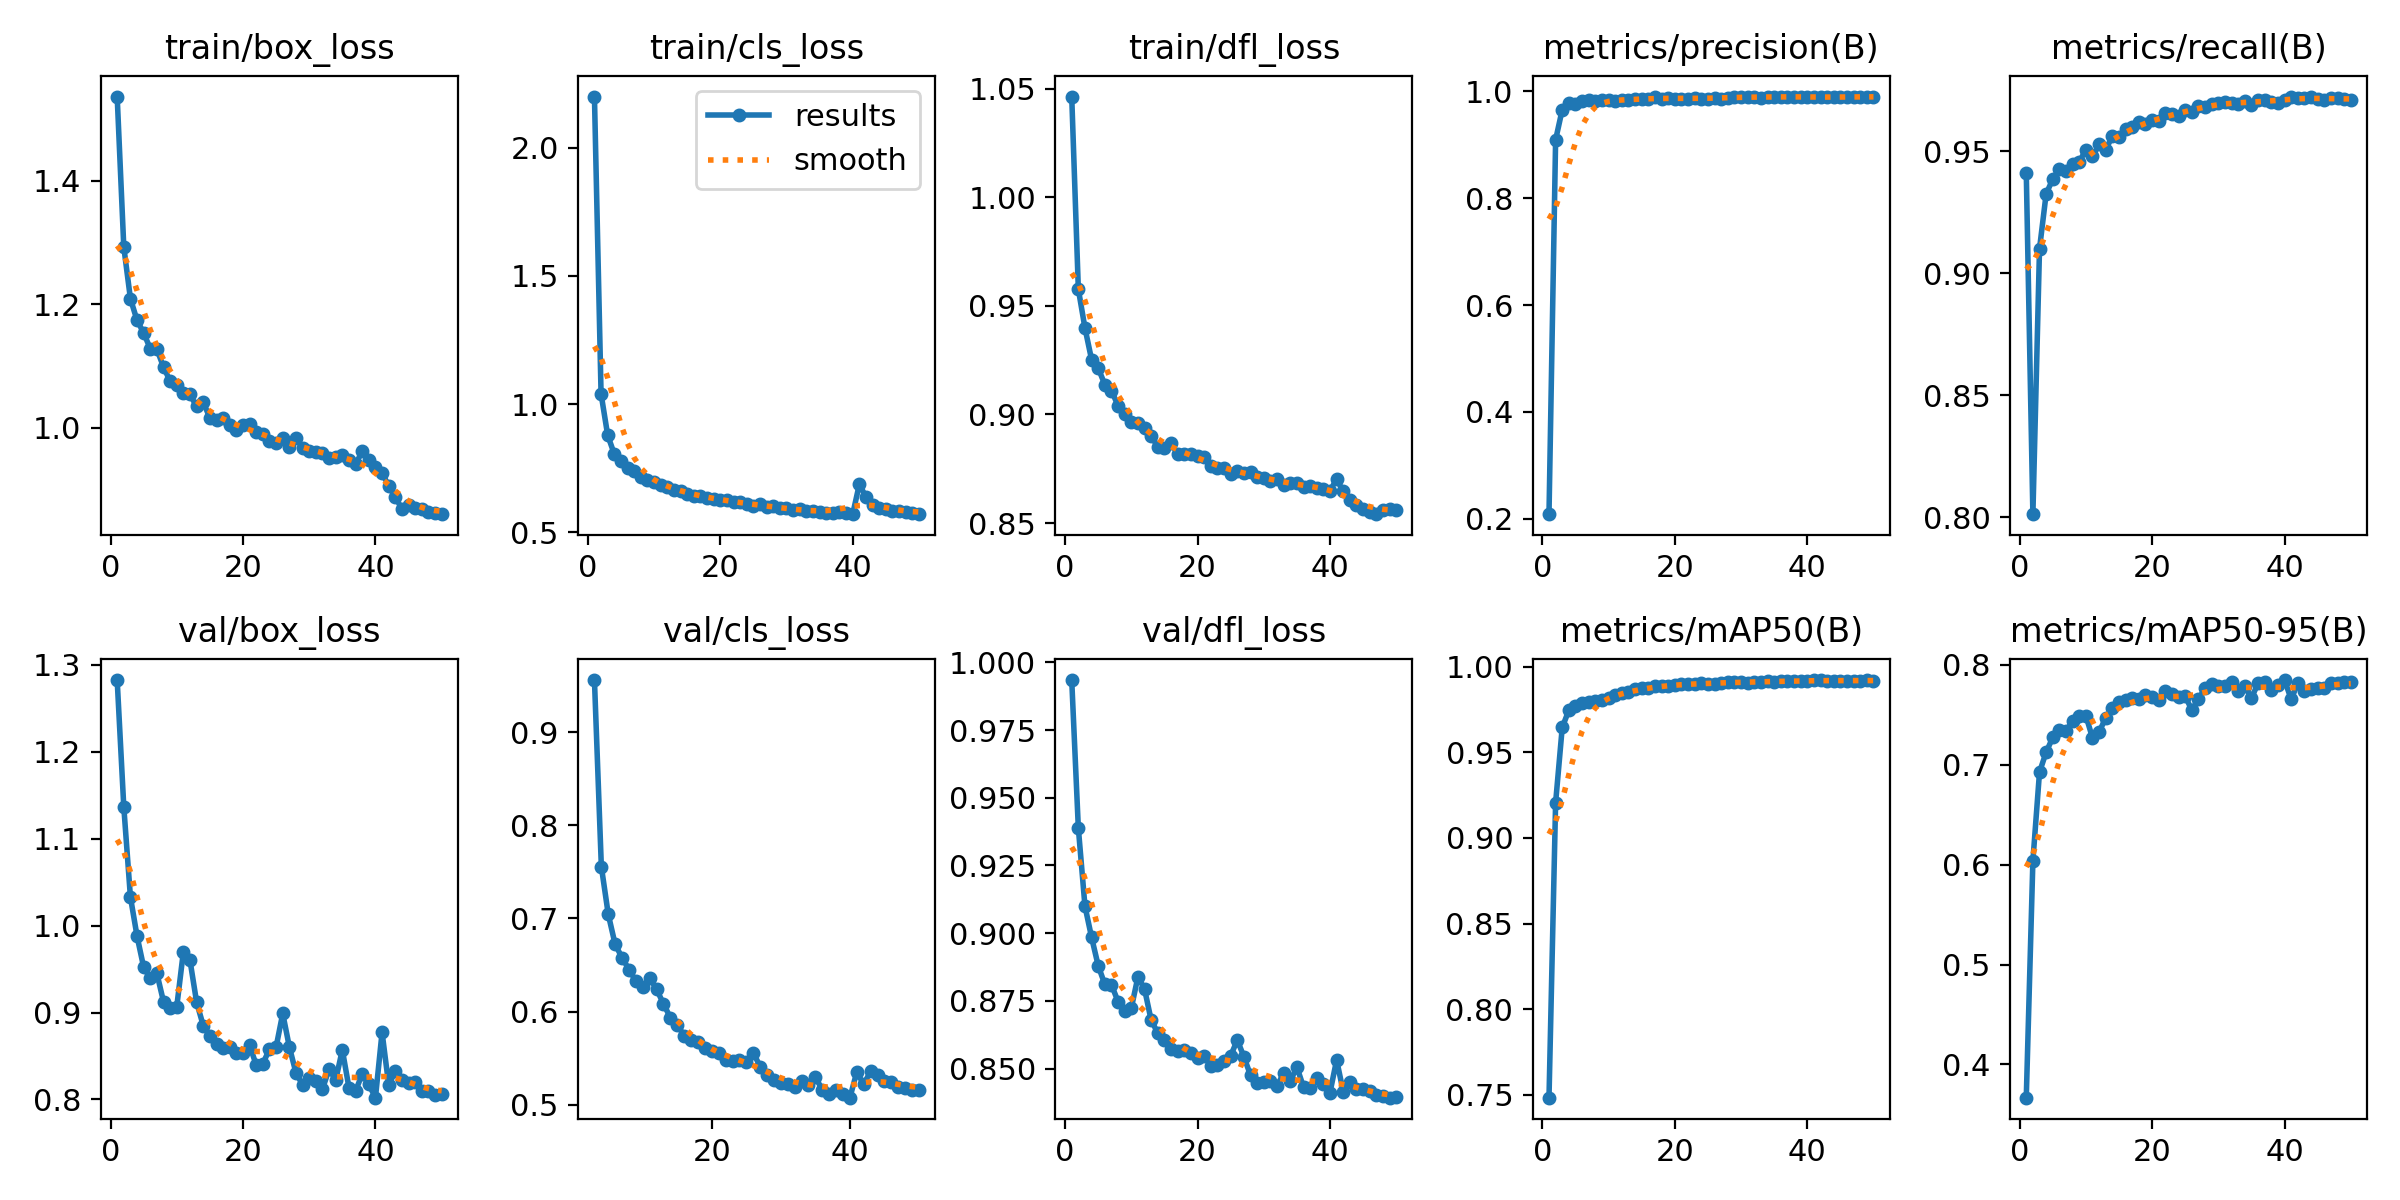

In [13]:
model_names = [config["name"] for config in param_variants]
display_results_images(model_names)

In [14]:
model = YOLO("runs/detect/yolov8n_sgd_lr0005_freeze5/weights/best.pt")
model.predict(source="cars_dataset/images/val", save=True, conf=0.25, name="pred_freeze5")


image 1/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00015.png: 384x640 42 cars, 33.5ms
image 2/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00028.png: 384x640 43 cars, 6.5ms
image 3/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00039.png: 384x640 23 cars, 6.8ms
image 4/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00044.png: 384x640 29 cars, 6.3ms
image 5/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00054.png: 384x640 48 cars, 6.6ms
image 6/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00056.png: 384x640 40 cars, 6.3ms
image 7/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00059.png: 384x640 40 cars, 6.6ms
image 8/200 /kaggle/working/cars_dataset/images/val/20160524_GF1_00007.png: 384x640 30 cars, 6.4ms
image 9/200 /kaggle/working/cars_dataset/images/val/20160524_GF1_00012.png: 384x640 33 cars, 6.3ms
image 10/200 /kaggle/working/cars_dataset/images/val/20160524_GF1_00017.png: 384x640 35 cars, 6.3ms
image 1

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'car'}
 obb: None
 orig_img: array([[[220, 217, 242],
         [237, 234, 246],
         [255, 255, 255],
         ...,
         [ 58,  71,  63],
         [ 56,  69,  61],
         [ 60,  73,  65]],
 
        [[214, 210, 238],
         [208, 205, 230],
         [224, 222, 238],
         ...,
         [ 58,  71,  63],
         [ 56,  69,  61],
         [ 59,  72,  64]],
 
        [[222, 217, 251],
         [223, 218, 247],
         [210, 207, 231],
         ...,
         [ 59,  72,  64],
         [ 60,  73,  65],
         [ 63,  76,  68]],
 
        ...,
 
        [[214, 219, 210],
         [214, 219, 210],
         [214, 219, 210],
         ...,
         [ 11,  56,   8],
         [ 47,  92,  44],
         [ 49,  94,  46]],
 
        [[217, 222, 213],
         [217, 222, 213],
         [216, 220, 211],
         ...,
         [ 33,  78,  

In [15]:
import pandas as pd
import os
from IPython.display import display

def evaluate_models(model_names, base_dir="runs/detect"):
    """
    Evaluate YOLOv8 models by computing a custom score based on precision, recall, and loss values.
    
    Parameters:
        model_names (list): List of model folder names (e.g., ['yolov8n_adam_lr001_freeze3'])
        base_dir (str): Root directory where training folders are stored

    Returns:
        best_model_name (str): The name of the best-performing model
        results_df (DataFrame): Full DataFrame with metrics and score
    """
    results = []

    for model_name in model_names:
        csv_path = os.path.join(base_dir, model_name, "results.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            last_epoch = df.iloc[-1]
            columns = df.columns.tolist()

            # Flexible access to column values
            def safe_get(col_name):
                for col in columns:
                    if col_name in col:
                        return last_epoch[col]
                return None

            results.append({
                "Model": model_name,
                "Precision": safe_get("metrics/precision"),
                "Recall": safe_get("metrics/recall"),
                "Box Loss": safe_get("val/box_loss"),
                "Cls Loss": safe_get("val/cls_loss"),
            })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Compute custom score
    results_df["Score"] = (
        results_df["Precision"] * 0.4 +
        results_df["Recall"] * 0.4 -
        results_df["Box Loss"] * 0.1 -
        results_df["Cls Loss"] * 0.1
    )

    # Sort and display
    results_df = results_df.sort_values(by="Score", ascending=False)
    display(results_df[["Model", "Precision", "Recall", "Box Loss", "Cls Loss", "Score"]])

    # Best model
    best_model = results_df.iloc[0]
    print(f"Best model based on precision, recall, and loss: {best_model['Model']}")
    return best_model["Model"], results_df

model_names = [config["name"] for config in param_variants]
best_model_5, df = evaluate_models(model_names)

Model  Precision   Recall  Box Loss  Cls Loss  \
2   yolov8n_adam_lr001_freeze5    0.99285  0.98446   0.70407   0.34508   
0    yolov8n_sgd_lr001_freeze5    0.98856  0.97259   0.78811   0.46389   
3  yolov8n_adam_lr0001_freeze5    0.99023  0.97092   0.80660   0.51590   
1   yolov8n_sgd_lr0005_freeze5    0.98714  0.96540   0.82037   0.50861   

      Score  
2  0.686009  
0  0.659260  
3  0.652210  
1  0.648118

Best model based on precision, recall, and loss: yolov8n_adam_lr001_freeze5


## Model Selection Summary

We selected the best model using the following strategy:

- **Precision** and **Recall** were given higher weight (each 40%) since they reflect the model's detection performance.
- **Box Loss** and **Classification Loss** were penalized (each -10%) to reward models with better convergence and accuracy.

This scoring strategy balances **prediction correctness (Precision/Recall)** and **training efficiency (loss values)**.

Based on this method, the best model is:

**`yolov8n_adam_lr001_freeze5`**

It achieved the highest overall score, with **Precision = 0.99285**, **Recall = 0.98446**, **Box Loss = 0.70407**, and **Cls Loss = 0.34508**.  
This model demonstrates a strong balance between detection accuracy and training stability, making it the most reliable configuration under the current evaluation setup.

### Freeze 10 Blocks (full backbone + SPPF)

We freeze the first 10 layers of the YOLOv8n model:
- Stem (initial conv)
- All backbone C2f blocks (C2f_1 to C2f_4)
- SPPF (Spatial Pyramid Pooling Fast)

**Advantages:**
- Faster training and less GPU usage.
- Good for transfer learning if backbone already captures general features.

**Disadvantages:**
- High risk of underfitting on complex or different domains.
- Fine-tuning is mostly limited to neck and detection head.

In [16]:
param_variants_10 = [
    {"name": "yolov8n_sgd_lr001_freeze10", "batch": 16, "lr0": 0.001, "optimizer": "SGD", "freeze": 10},
    {"name": "yolov8n_sgd_lr0005_freeze10", "batch": 16, "lr0": 0.0005, "optimizer": "SGD", "freeze": 10},
    {"name": "yolov8n_adam_lr001_freeze10", "batch": 16, "lr0": 0.001, "optimizer": "Adam", "freeze": 10},
    {"name": "yolov8n_adam_lr0001_freeze10", "batch": 32, "lr0": 0.0001, "optimizer": "Adam", "freeze": 10},
]

for config in param_variants_10:
    run_training(config)

Training: yolov8n_sgd_lr001_freeze10
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_sgd_lr001_freeze10, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, pa

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1335.1±2123.9 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_sgd_lr001_freeze10/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_sgd_lr001_freeze10
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.46G      1.564       2.15      1.123        779        640: 100%|██████████| 63/63 [00:18<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        200      11906       0.83      0.771      0.866      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.38G      1.336     0.9965      1.019        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


                   all        200      11906      0.938      0.882      0.953      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.38G      1.226     0.8218     0.9845        600        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        200      11906      0.946      0.914      0.965      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.38G      1.188     0.7673     0.9599       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        200      11906       0.96      0.922       0.97      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.38G      1.137     0.7195     0.9483       1092        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906       0.97      0.934      0.974       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.38G      1.127     0.6983      0.942       1120        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        200      11906       0.97      0.932      0.975      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.38G      1.089      0.678     0.9334        940        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.977       0.94      0.978      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.38G      1.081     0.6675      0.928        831        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.977      0.942      0.978      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.38G      1.083     0.6624     0.9246        664        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906      0.979      0.946      0.979      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.38G      1.065     0.6517     0.9225       1112        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


                   all        200      11906      0.981      0.946      0.979      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.38G       1.05      0.639     0.9187       1226        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        200      11906      0.981       0.95       0.98      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.38G       1.04     0.6333     0.9175        624        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.982      0.948      0.981      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.38G      1.044     0.6297     0.9135       1065        640: 100%|██████████| 63/63 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.982      0.949      0.981      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.38G      1.039     0.6226     0.9105        645        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        200      11906      0.982      0.952      0.982      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.38G      1.017     0.6136      0.908        908        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


                   all        200      11906      0.981      0.951      0.982      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.38G      1.022     0.6136     0.9091        820        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.982      0.953      0.983      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.38G      1.015     0.6039     0.9053        838        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906      0.983      0.954      0.984      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.38G      1.006     0.6023     0.9069        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        200      11906      0.985      0.955      0.985      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.46G      1.014     0.5995     0.9021        855        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


                   all        200      11906      0.983      0.954      0.985      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.46G      1.001     0.5948     0.9036       1198        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


                   all        200      11906      0.984      0.957      0.986      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.46G      1.002     0.5919     0.9027        734        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906      0.986      0.956      0.987       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.46G      1.002     0.5887        0.9        978        640: 100%|██████████| 63/63 [00:17<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        200      11906      0.985      0.958      0.987      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.46G      1.011      0.588      0.896       1117        640: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


                   all        200      11906      0.986      0.957      0.987      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.46G     0.9955     0.5825     0.8971        862        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        200      11906      0.986      0.958      0.987      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.46G      0.991     0.5822     0.8974       1059        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.986      0.959      0.988      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.46G     0.9885     0.5785     0.8994        858        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


                   all        200      11906      0.987      0.958      0.987      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.46G          1     0.5783      0.893        671        640: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.987      0.958      0.988      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.46G     0.9884     0.5726     0.8962        703        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        200      11906      0.987      0.957      0.988      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.46G     0.9801     0.5686     0.8955        613        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        200      11906      0.987      0.958      0.988      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.46G     0.9818     0.5692     0.8916       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        200      11906      0.988      0.958      0.989      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.46G     0.9742     0.5646      0.893        757        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.988      0.958      0.989      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.46G     0.9831     0.5668      0.893       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


                   all        200      11906      0.989      0.957      0.989      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.46G     0.9777     0.5684     0.8946        559        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


                   all        200      11906      0.988      0.959      0.989      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.46G     0.9623      0.556     0.8914        748        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906      0.986      0.959      0.989      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.46G     0.9679     0.5617     0.8921        730        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        200      11906      0.987       0.96      0.989      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.46G     0.9611     0.5549     0.8898        731        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.988      0.959      0.989      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.46G     0.9767     0.5596     0.8895       1068        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.987       0.96      0.989      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.46G     0.9714     0.5553     0.8904        750        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.987      0.959      0.989      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.46G     0.9748     0.5557     0.8867        878        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.988       0.96      0.989      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.46G     0.9709     0.5543     0.8882       1048        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        200      11906      0.988       0.96       0.99      0.774
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.46G     0.9023     0.5733      0.888        669        640: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


                   all        200      11906      0.986      0.962       0.99      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.46G     0.8997     0.5535     0.8868        577        640: 100%|██████████| 63/63 [00:16<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        200      11906      0.987      0.963       0.99      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.46G     0.8979     0.5444     0.8875        444        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200      11906      0.985      0.964       0.99      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.46G     0.8933     0.5441     0.8846        422        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        200      11906      0.987      0.963       0.99      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.46G     0.8838     0.5337     0.8856        483        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]

                   all        200      11906      0.986      0.963       0.99      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.46G     0.8977     0.5399      0.883        408        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

                   all        200      11906      0.985      0.963       0.99      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.46G     0.8898     0.5361     0.8836        407        640: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        200      11906      0.986      0.963       0.99      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.46G     0.8798     0.5293      0.885        695        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


                   all        200      11906      0.986      0.963       0.99      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.46G     0.8894     0.5316     0.8848        595        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906      0.986      0.963       0.99      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.46G     0.8736     0.5257     0.8828        592        640: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        200      11906      0.987      0.962       0.99      0.777



50 epochs completed in 0.277 hours.
Optimizer stripped from runs/detect/yolov8n_sgd_lr001_freeze10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sgd_lr001_freeze10/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sgd_lr001_freeze10/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


                   all        200      11906      0.987      0.962       0.99      0.777


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/yolov8n_sgd_lr001_freeze10
Training: yolov8n_sgd_lr0005_freeze10
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1698.2±1917.9 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_sgd_lr0005_freeze10/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_sgd_lr0005_freeze10
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.43G      1.601      2.282      1.139        779        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        200      11906      0.191      0.962      0.738      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.35G      1.394      1.221      1.045        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


                   all        200      11906      0.893      0.842      0.928      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.35G      1.281     0.9068      1.007        600        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


                   all        200      11906      0.934      0.893      0.956      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.35G      1.231     0.8295     0.9774       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        200      11906       0.95      0.918      0.966      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.35G      1.172      0.774     0.9629       1092        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.958      0.925      0.969      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.35G      1.157     0.7445     0.9549       1120        640: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        200      11906      0.964      0.927      0.972      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.35G      1.118     0.7201     0.9457        940        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906      0.969      0.932      0.974      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.35G      1.109      0.707     0.9397        831        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        200      11906       0.97      0.935      0.975      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.35G      1.112      0.701     0.9365        664        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906      0.971      0.935      0.976      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.35G      1.092     0.6873     0.9339       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.975      0.938      0.977      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.35G      1.075      0.672     0.9298       1226        640: 100%|██████████| 63/63 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        200      11906      0.976      0.941      0.978      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.35G      1.065     0.6667     0.9286        624        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.975      0.942      0.978       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.35G      1.068      0.662     0.9241       1065        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.978      0.943      0.979      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.35G      1.063     0.6549     0.9208        645        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all        200      11906      0.979      0.943      0.979      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.35G      1.041     0.6468     0.9185        908        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200      11906       0.98      0.944      0.979      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.35G      1.047     0.6467     0.9193        820        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]

                   all        200      11906       0.98      0.945       0.98      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.35G      1.039      0.636     0.9155        838        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        200      11906      0.981      0.948       0.98      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.35G      1.031     0.6354     0.9169        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.982       0.95      0.981      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.43G      1.039     0.6332     0.9122        855        640: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        200      11906      0.981      0.948      0.981      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.43G      1.028     0.6289      0.914       1198        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        200      11906      0.982      0.949      0.981      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.43G       1.03     0.6265     0.9131        734        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


                   all        200      11906      0.983      0.951      0.982      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.43G       1.03     0.6226     0.9106        978        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


                   all        200      11906      0.982      0.951      0.982      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.43G       1.04     0.6233     0.9062       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        200      11906      0.983      0.952      0.982      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.43G      1.024      0.618     0.9077        862        640: 100%|██████████| 63/63 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        200      11906      0.983      0.951      0.982      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.43G       1.02     0.6184     0.9078       1059        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


                   all        200      11906      0.982      0.955      0.983      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.43G      1.019     0.6149     0.9104        858        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        200      11906      0.983      0.954      0.983      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.43G       1.03     0.6134     0.9034        671        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

                   all        200      11906      0.984      0.953      0.983      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.43G      1.018     0.6081     0.9066        703        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


                   all        200      11906      0.984      0.953      0.984      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.43G       1.01     0.6049     0.9062        613        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.984      0.953      0.984      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.43G      1.012     0.6053     0.9022       1008        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906      0.984      0.955      0.984       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.43G      1.005     0.6021     0.9038        757        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.985      0.954      0.985       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.43G      1.015     0.6037     0.9037       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906      0.986      0.954      0.985      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.43G      1.009     0.6066     0.9052        559        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all        200      11906      0.984      0.955      0.985      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.43G     0.9934     0.5931     0.9021        748        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        200      11906      0.985      0.954      0.986      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.43G     0.9996     0.5995     0.9028        730        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        200      11906      0.985      0.955      0.986      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.43G     0.9934      0.593     0.9005        731        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


                   all        200      11906      0.984      0.955      0.986      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.43G      1.009     0.5976     0.9002       1068        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906      0.985      0.956      0.986      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.43G      1.004     0.5927     0.9012        750        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.985      0.956      0.986      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.43G      1.008     0.5937     0.8973        878        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        200      11906      0.985      0.957      0.986      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.43G      1.004     0.5931     0.8992       1048        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906      0.985      0.957      0.986      0.764


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.43G     0.9324     0.6364     0.8983        669        640: 100%|██████████| 63/63 [00:19<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


                   all        200      11906      0.984      0.956      0.986      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.43G     0.9329     0.6098      0.898        577        640: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]

                   all        200      11906       0.98      0.962      0.987       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.43G     0.9303     0.5947     0.8979        444        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906      0.983      0.959      0.987      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.43G     0.9266     0.5954     0.8953        422        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

                   all        200      11906      0.984      0.958      0.987      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.43G     0.9152     0.5833     0.8962        483        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        200      11906      0.984      0.959      0.987      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.43G     0.9305     0.5894     0.8932        408        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        200      11906      0.984      0.959      0.987      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.43G     0.9232     0.5854     0.8942        407        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        200      11906      0.985      0.958      0.987      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.43G     0.9135     0.5797     0.8962        695        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906      0.985      0.958      0.987      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.43G     0.9227     0.5804     0.8956        595        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        200      11906      0.985      0.958      0.987      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.43G     0.9069     0.5747     0.8936        592        640: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        200      11906      0.985      0.958      0.987      0.767



50 epochs completed in 0.277 hours.
Optimizer stripped from runs/detect/yolov8n_sgd_lr0005_freeze10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sgd_lr0005_freeze10/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sgd_lr0005_freeze10/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


                   all        200      11906      0.985      0.958      0.987      0.767


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/yolov8n_sgd_lr0005_freeze10
Training: yolov8n_adam_lr001_freeze10
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1050.5±1539.8 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_adam_lr001_freeze10/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_adam_lr001_freeze10
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.43G      1.441      1.509      1.009        779        640: 100%|██████████| 63/63 [00:17<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        200      11906      0.953      0.894       0.96      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.35G      1.252     0.8249     0.9415        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.964      0.926      0.973      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.35G      1.155     0.7346     0.9189        600        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        200      11906      0.976      0.943      0.979      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.35G      1.121     0.6914     0.9053       1112        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        200      11906      0.978      0.949      0.981      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.35G       1.07     0.6461     0.8976       1092        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906      0.984      0.953      0.982      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.35G      1.054     0.6243      0.891       1120        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all        200      11906      0.987      0.958      0.987      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.35G      1.018     0.5998     0.8843        940        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


                   all        200      11906      0.986      0.962      0.989      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.35G      1.007     0.5819     0.8799        831        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.989      0.963       0.99      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.35G      1.007      0.575     0.8777        664        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


                   all        200      11906      0.986      0.963       0.99      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.35G      0.993     0.5619     0.8761       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        200      11906      0.988      0.966      0.991      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.35G      0.979     0.5479     0.8731       1226        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        200      11906      0.986      0.968      0.991       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.35G      0.962     0.5379     0.8713        624        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906      0.987      0.971      0.992      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.35G     0.9653     0.5303     0.8683       1065        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


                   all        200      11906      0.988       0.97      0.992       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.35G     0.9667     0.5278     0.8683        645        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        200      11906       0.99      0.969      0.993      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.35G     0.9385     0.5157      0.865        908        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        200      11906      0.991      0.968      0.993      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.35G     0.9418     0.5144     0.8653        820        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        200      11906       0.99      0.969      0.993      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.35G     0.9393     0.5116     0.8642        838        640: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        200      11906      0.991      0.972      0.993       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.35G     0.9314     0.5055      0.865        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

                   all        200      11906      0.989      0.974      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.44G     0.9286     0.4995     0.8598        855        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906       0.99      0.974      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.44G     0.9193     0.4944     0.8617       1198        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.988      0.975      0.993      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.44G     0.9214     0.4915     0.8605        734        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906       0.99      0.977      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.44G     0.9132      0.485     0.8582        978        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906       0.99      0.977      0.993      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.44G      0.927     0.4899      0.857       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        200      11906      0.989      0.976      0.993      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.44G     0.9103      0.481     0.8568        862        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906      0.989      0.976      0.993      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.44G     0.9064     0.4783     0.8563       1059        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906       0.99      0.976      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.44G     0.9015     0.4763     0.8579        858        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        200      11906      0.991      0.975      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.44G     0.9103     0.4768      0.854        671        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        200      11906      0.989      0.977      0.993      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.44G     0.9064     0.4719     0.8565        703        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906      0.991      0.977      0.993      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.44G     0.8921     0.4654     0.8543        613        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        200      11906      0.991      0.977      0.994      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.44G      0.892      0.464     0.8527       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        200      11906       0.99      0.978      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.44G     0.8843     0.4587     0.8525        757        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


                   all        200      11906      0.992      0.977      0.994      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.44G     0.8917     0.4623     0.8527       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        200      11906      0.989      0.978      0.993      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.44G     0.8844     0.4594     0.8528        559        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        200      11906      0.989      0.977      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.44G     0.8727     0.4519     0.8509        748        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        200      11906      0.991      0.978      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.44G     0.8737     0.4534     0.8511        730        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]

                   all        200      11906      0.991      0.978      0.994      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.44G       0.87     0.4507     0.8494        731        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]

                   all        200      11906      0.993      0.976      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.44G     0.8816     0.4535     0.8494       1068        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.991      0.978      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.44G     0.8794     0.4505     0.8502        750        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


                   all        200      11906       0.99      0.979      0.994        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.44G      0.878     0.4483     0.8474        878        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


                   all        200      11906      0.991      0.978      0.994      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.44G      0.873     0.4469      0.848       1048        640: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        200      11906       0.99      0.981      0.994        0.8
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.44G     0.8129      0.435      0.843        669        640: 100%|██████████| 63/63 [00:18<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        200      11906      0.991      0.978      0.993      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.44G      0.812     0.4274     0.8432        577        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

                   all        200      11906       0.99      0.979      0.993      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.44G     0.8083     0.4221     0.8431        444        640: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        200      11906       0.99      0.979      0.994      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.44G     0.8007     0.4177     0.8398        422        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906       0.99      0.979      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.44G     0.7916     0.4111     0.8406        483        640: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        200      11906      0.991      0.979      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.44G     0.8013     0.4147     0.8385        408        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        200      11906      0.991      0.979      0.994      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.44G     0.7957     0.4119      0.839        407        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


                   all        200      11906      0.991      0.979      0.994      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.44G     0.7862     0.4058     0.8391        695        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        200      11906      0.992      0.979      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.44G     0.7923     0.4062       0.84        595        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all        200      11906      0.992      0.979      0.994      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.45G     0.7778     0.4011     0.8378        592        640: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        200      11906      0.991      0.979      0.994      0.807



50 epochs completed in 0.276 hours.
Optimizer stripped from runs/detect/yolov8n_adam_lr001_freeze10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_adam_lr001_freeze10/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_adam_lr001_freeze10/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


                   all        200      11906      0.991      0.979      0.994      0.806


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/yolov8n_adam_lr001_freeze10
Training: yolov8n_adam_lr0001_freeze10
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosai

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1249.7±1682.1 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_adam_lr0001_freeze10/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_adam_lr0001_freeze10
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.66G      1.574      2.252      1.057       1214        640: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        200      11906      0.231      0.952       0.81      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.71G      1.347      1.107     0.9779        689        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200      11906      0.906      0.742      0.892      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.34G      1.269      0.932     0.9562        653        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all        200      11906      0.947      0.892      0.956       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.27G      1.231     0.8554     0.9397        933        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all        200      11906      0.961      0.919      0.968      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.27G        1.2     0.8222     0.9322       1109        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        200      11906      0.966      0.925      0.972      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.19G      1.174      0.793     0.9244       1017        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        200      11906      0.971      0.929      0.974      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.26G      1.161      0.773     0.9182       1080        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


                   all        200      11906      0.973      0.933      0.975      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.2G      1.138     0.7515     0.9125        927        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        200      11906      0.976      0.935      0.976      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       7.1G      1.125     0.7396     0.9108       1062        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        200      11906      0.977      0.938      0.977      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.86G      1.118     0.7288     0.9065        767        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        200      11906      0.978      0.941      0.978      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.27G      1.104     0.7185     0.9057       1124        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        200      11906      0.977      0.942      0.978      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         9G      1.102     0.7134     0.9036        617        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200      11906      0.977      0.944      0.979      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.83G      1.084     0.7004     0.9001       1220        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        200      11906      0.979      0.946       0.98      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.37G      1.091     0.6971     0.8958        842        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


                   all        200      11906      0.978      0.948      0.981      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.37G      1.066      0.685      0.895        597        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


                   all        200      11906      0.981      0.949      0.981      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.94G      1.061     0.6782     0.8969        960        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


                   all        200      11906      0.982      0.951      0.982      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.94G      1.065     0.6755      0.891        616        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        200      11906      0.982      0.953      0.982      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.54G      1.054     0.6659     0.8914        696        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        200      11906      0.983      0.951      0.982      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.06G      1.051     0.6638     0.8922       1121        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        200      11906      0.984      0.953      0.983       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       8.6G      1.056     0.6592     0.8913       1124        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        200      11906      0.983      0.954      0.983      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.3G      1.056     0.6606     0.8898       1075        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        200      11906      0.983      0.954      0.984      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.7G      1.047     0.6545     0.8865        665        640: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        200      11906      0.984      0.954      0.984      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.2G      1.049     0.6519     0.8863        792        640: 100%|██████████| 32/32 [00:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        200      11906      0.983      0.956      0.984      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.22G      1.031     0.6464     0.8852        392        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        200      11906      0.984      0.954      0.985      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.92G      1.032     0.6394     0.8835        867        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        200      11906      0.983      0.958      0.986      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.77G       1.04     0.6444     0.8846       1153        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        200      11906      0.982      0.958      0.986       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.45G      1.027     0.6357     0.8843        753        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        200      11906      0.984      0.959      0.986      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.18G      1.042     0.6389     0.8845       1228        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        200      11906      0.983      0.959      0.986      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.67G      1.026     0.6292     0.8822        905        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


                   all        200      11906      0.984      0.959      0.987      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.34G      1.021     0.6301     0.8825        806        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        200      11906      0.983       0.96      0.987       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.6G       1.02     0.6239     0.8807        826        640: 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        200      11906      0.985      0.959      0.987      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.26G      1.023      0.628     0.8827       1009        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        200      11906      0.983      0.961      0.987      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.19G      1.011     0.6182     0.8782        885        640: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


                   all        200      11906      0.984       0.96      0.987      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.68G      1.013     0.6182     0.8797        789        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        200      11906      0.986       0.96      0.988       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.55G      1.016     0.6164     0.8796        918        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


                   all        200      11906      0.985      0.961      0.988      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.5G      1.005     0.6127     0.8776        688        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        200      11906      0.983      0.962      0.988      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.04G      1.001     0.6111     0.8789        722        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        200      11906      0.983      0.963      0.988      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.24G      1.018     0.6141     0.8763       1107        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        200      11906      0.984      0.962      0.988      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.06G      1.008     0.6132     0.8768        970        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


                   all        200      11906      0.984      0.962      0.988      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.73G      1.002     0.6086      0.877        686        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


                   all        200      11906      0.986      0.962      0.988      0.765
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       4.6G     0.9403     0.6835     0.8714        692        640: 100%|██████████| 32/32 [00:20<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        200      11906      0.984      0.963      0.989      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.38G     0.9448     0.6577     0.8721        657        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


                   all        200      11906      0.983      0.964      0.989      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.38G     0.9363     0.6369     0.8699        549        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        200      11906      0.985      0.964      0.989      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.38G     0.9183     0.6233     0.8684        413        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        200      11906      0.985      0.964      0.989      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.38G     0.9268     0.6183     0.8668        510        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        200      11906      0.986      0.963      0.989      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.38G      0.923     0.6148     0.8656        426        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


                   all        200      11906      0.986      0.964      0.989      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.38G     0.9246     0.6129     0.8649        440        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        200      11906      0.986      0.964      0.989      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.38G      0.917     0.6113     0.8667        681        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        200      11906      0.986      0.963      0.989      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.38G     0.9183     0.6093     0.8677        515        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        200      11906      0.986      0.963      0.989      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.38G     0.9176     0.6053     0.8671        642        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        200      11906      0.987      0.963      0.989      0.766



50 epochs completed in 0.272 hours.
Optimizer stripped from runs/detect/yolov8n_adam_lr0001_freeze10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_adam_lr0001_freeze10/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_adam_lr0001_freeze10/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


                   all        200      11906      0.986      0.963      0.989      0.766


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 10.5ms postprocess per image
Results saved to runs/detect/yolov8n_adam_lr0001_freeze10


Results for yolov8n_sgd_lr001_freeze10


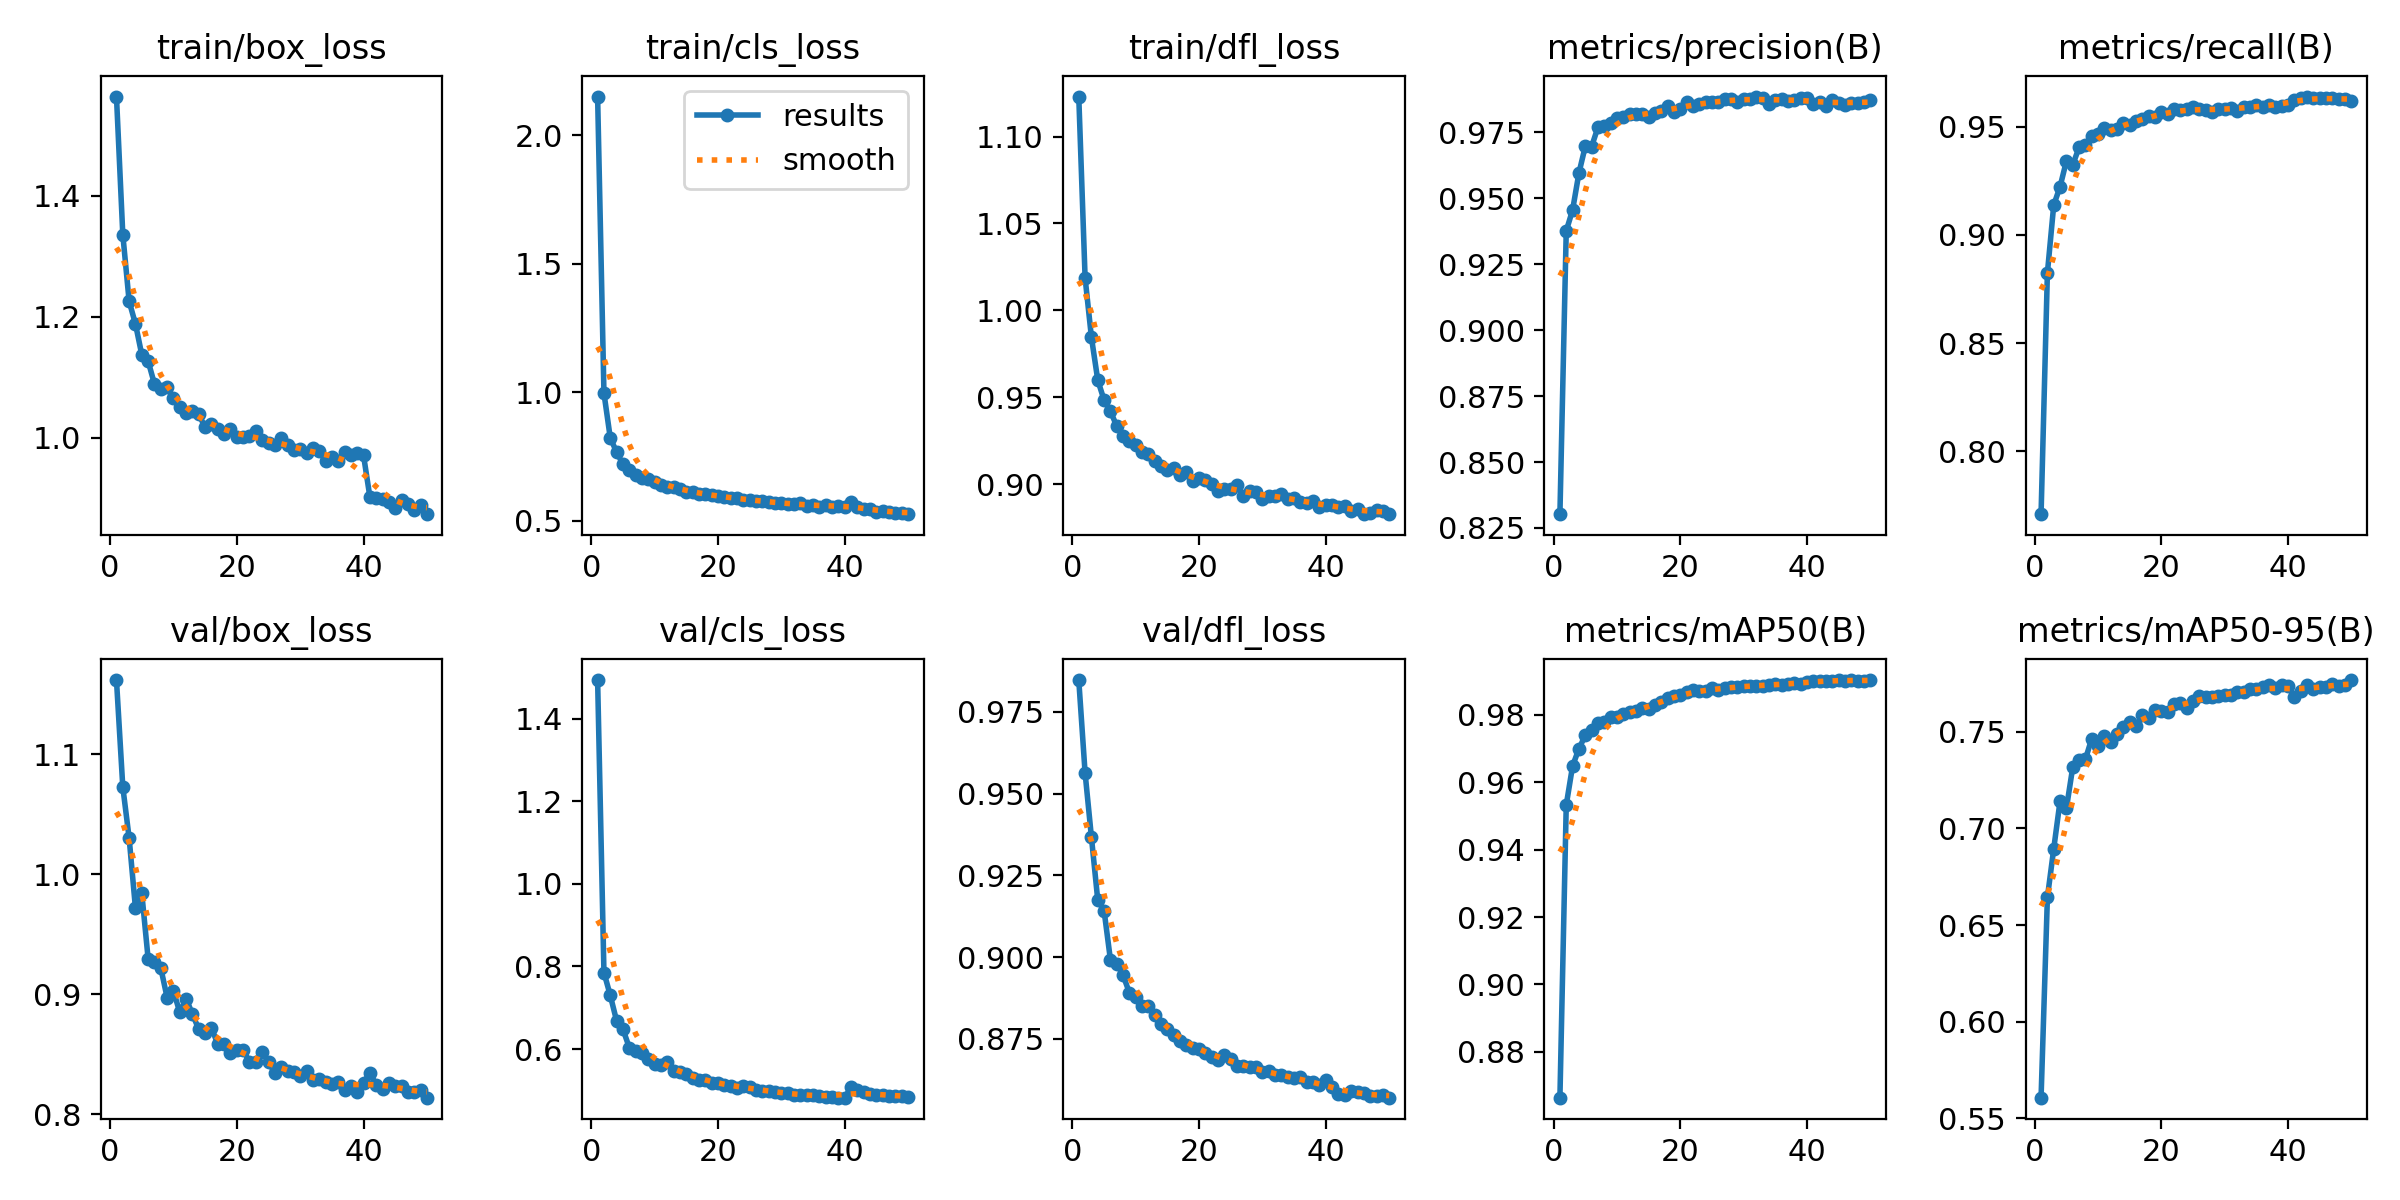

Results for yolov8n_sgd_lr0005_freeze10


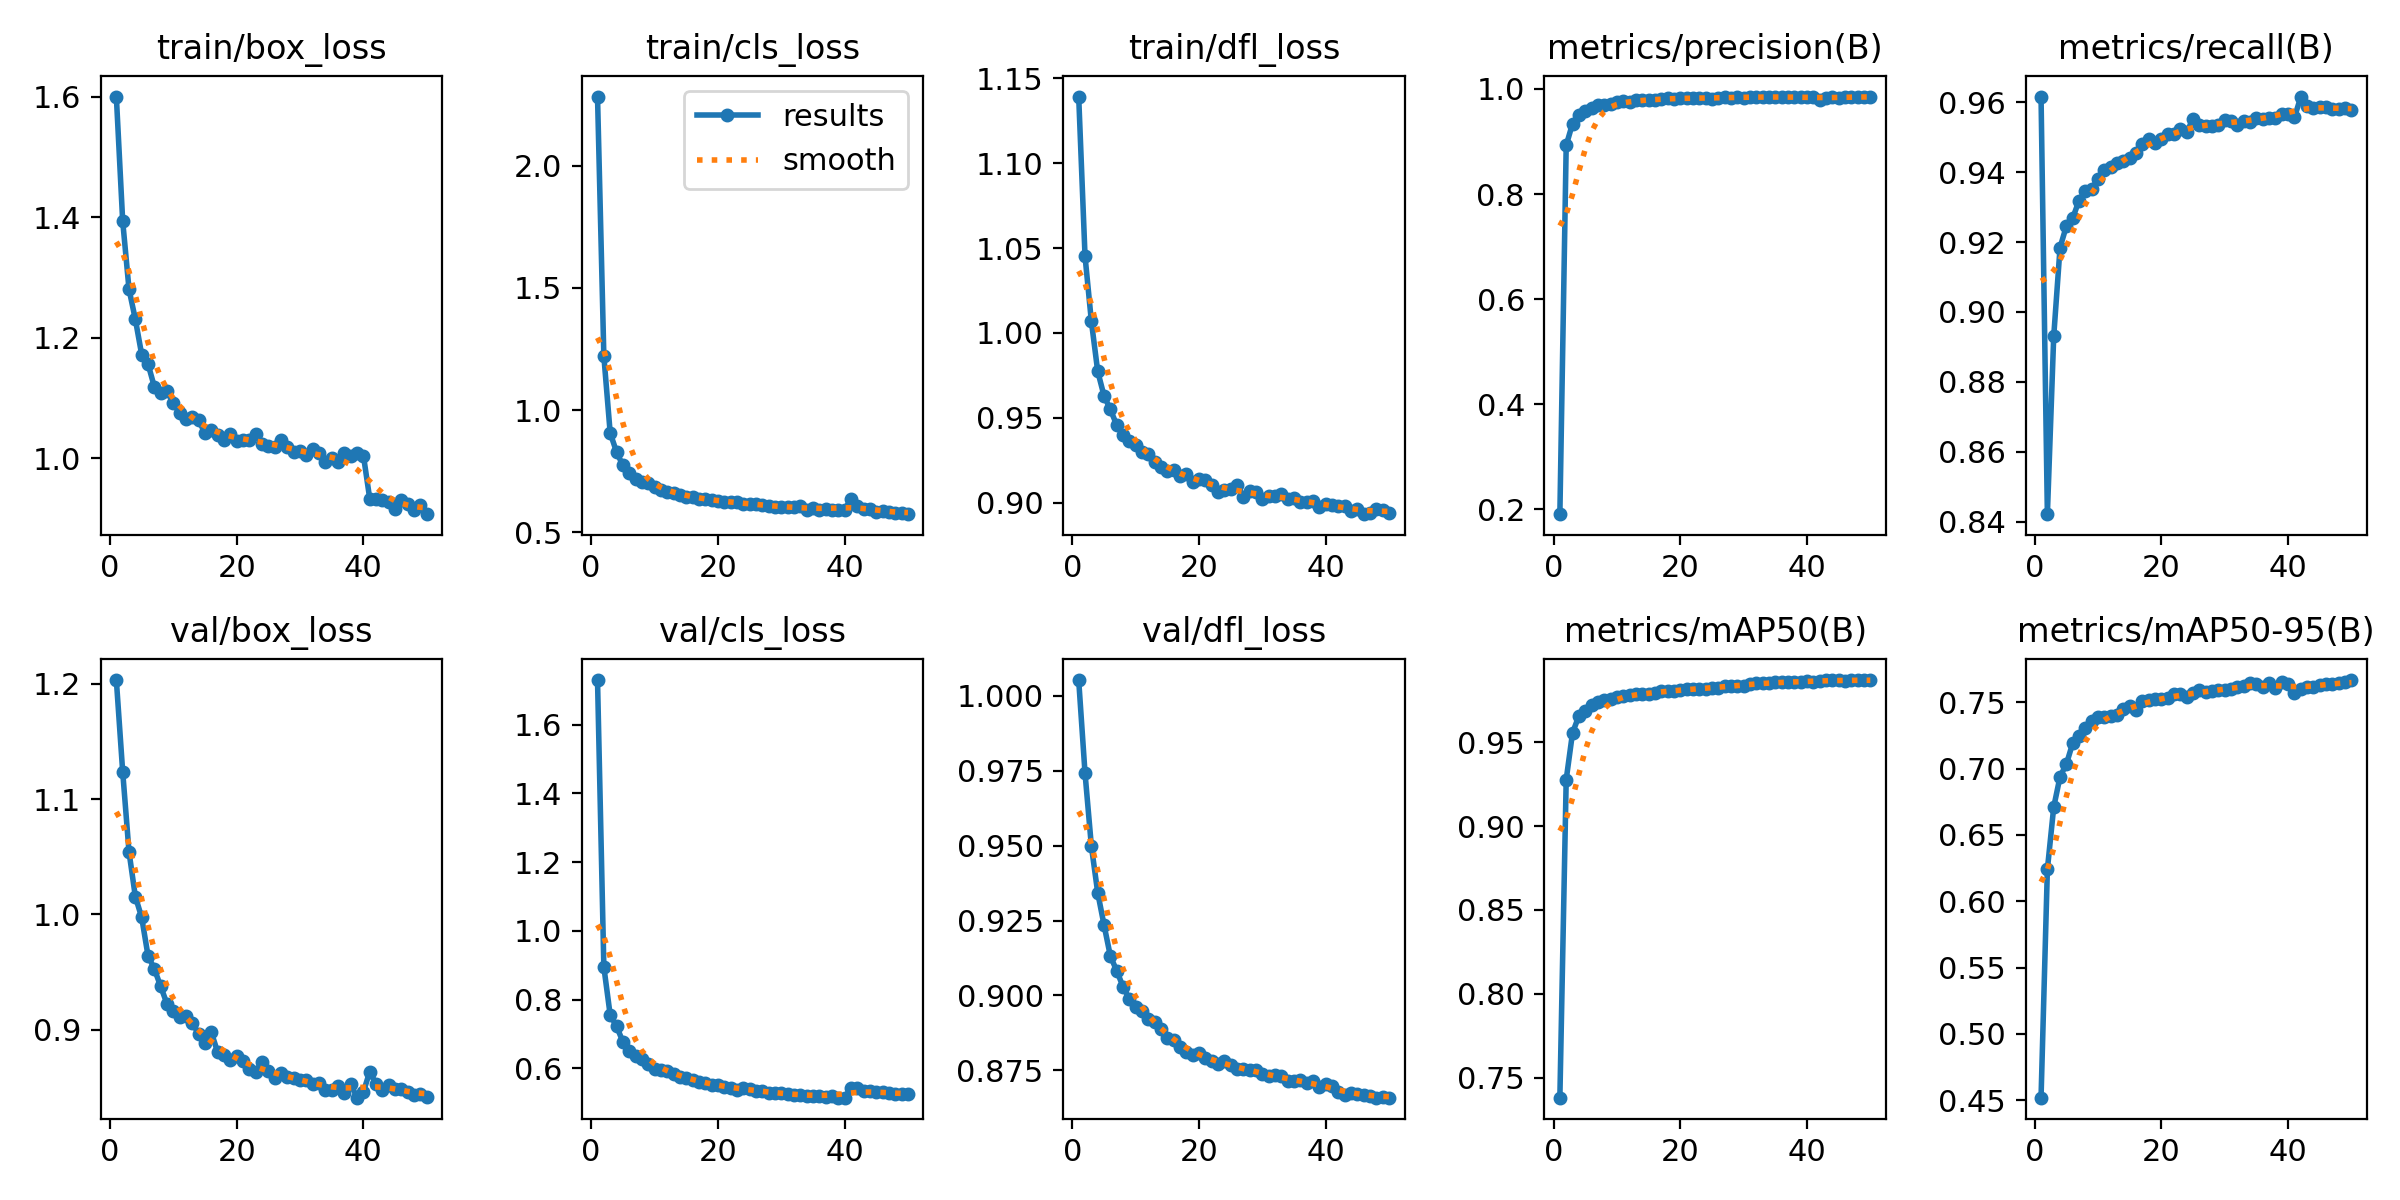

Results for yolov8n_adam_lr001_freeze10


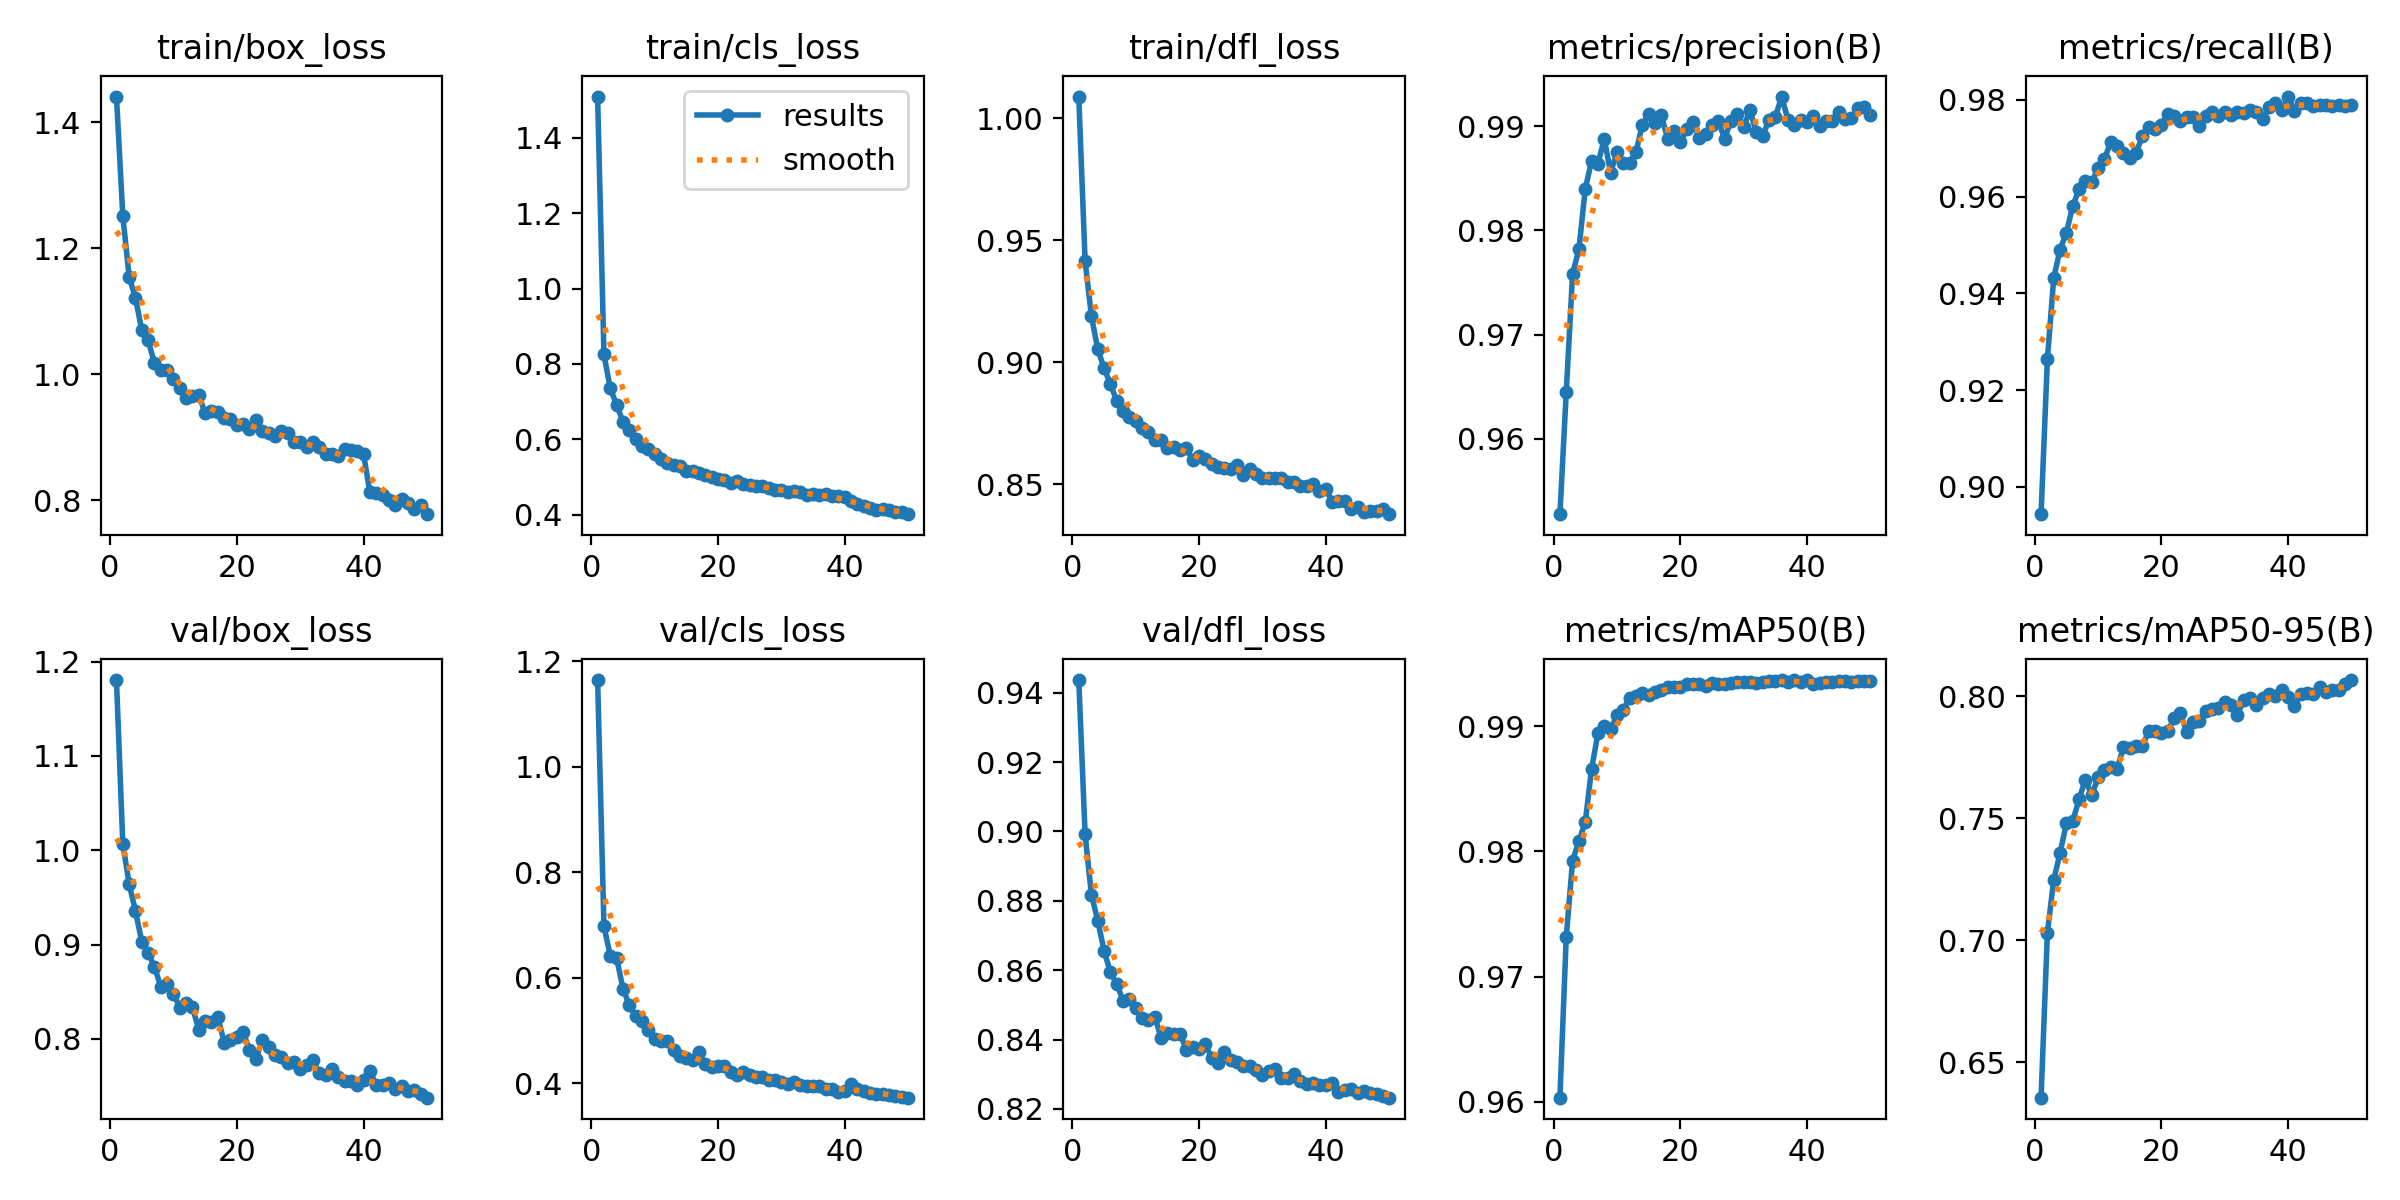

Results for yolov8n_adam_lr0001_freeze10


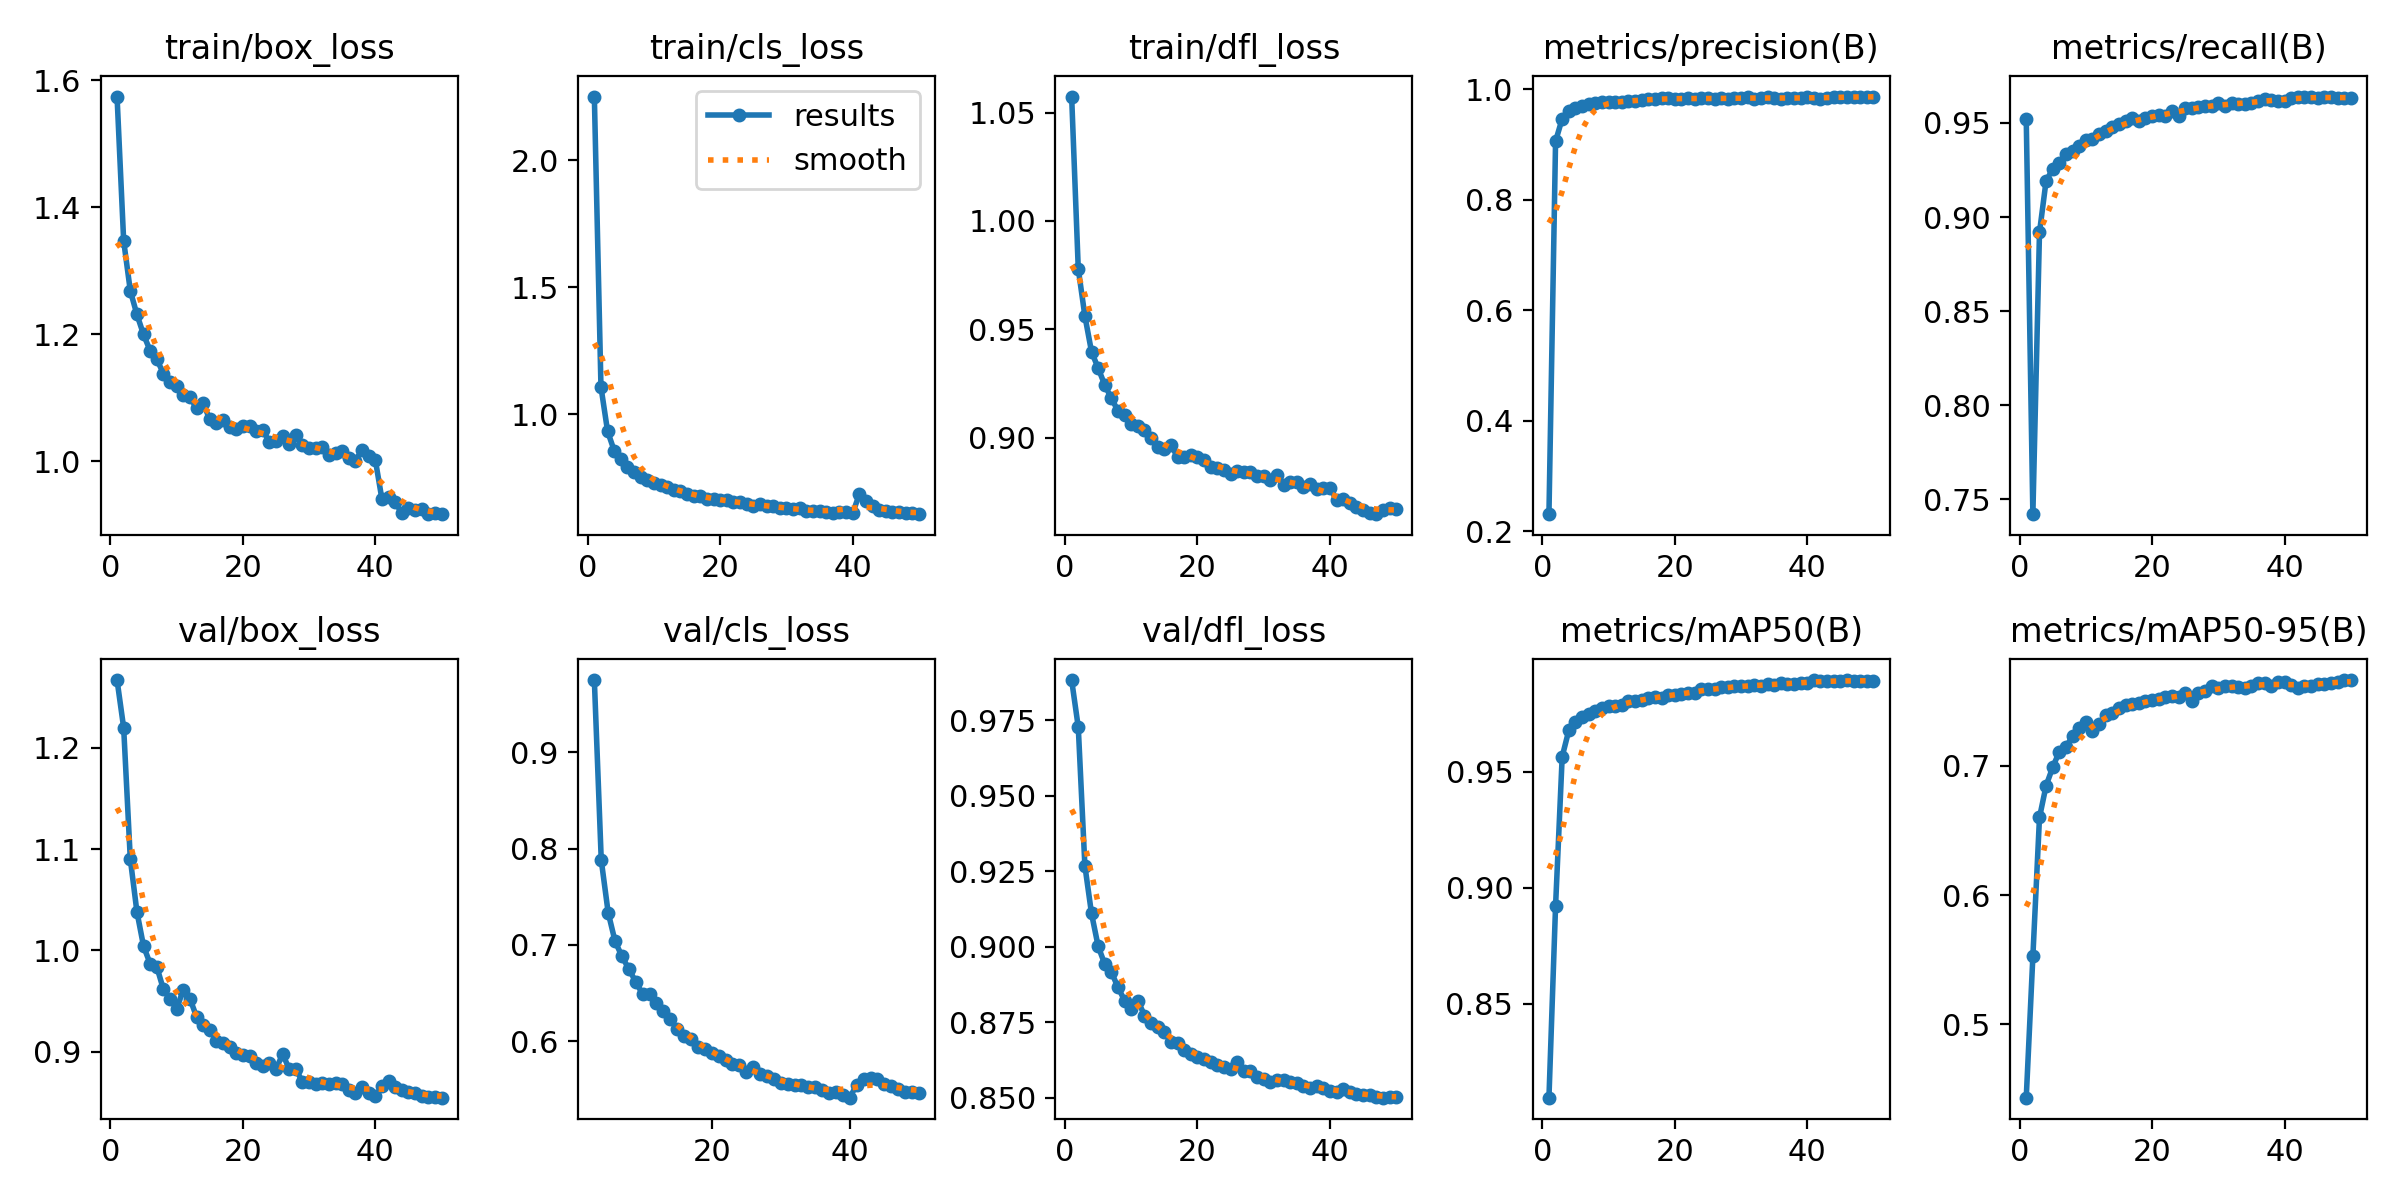

Model  Precision   Recall  Box Loss  Cls Loss  \
2   yolov8n_adam_lr001_freeze10    0.99107  0.97886   0.73772   0.37254   
0    yolov8n_sgd_lr001_freeze10    0.98716  0.96184   0.81367   0.48319   
1   yolov8n_sgd_lr0005_freeze10    0.98537  0.95775   0.84131   0.52438   
3  yolov8n_adam_lr0001_freeze10    0.98681  0.96338   0.85438   0.54607   

      Score  
2  0.676946  
0  0.649914  
1  0.640679  
3  0.640031

Best model based on precision, recall, and loss: yolov8n_adam_lr001_freeze10


In [17]:
model_names = [config["name"] for config in param_variants_10]
display_results_images(model_names)
best_model_10, df = evaluate_models(model_names)

### Freeze 21 Blocks (only detection head is trainable)

We freeze the entire backbone and neck.  
Only the detection head is trained.

**Advantages:**
- Extremely fast training.
- Useful when computational resources are limited.

**Disadvantages:**
- Very limited learning.
- May lead to poor accuracy unless pretrained backbone already fits the dataset very well.

In [18]:
param_variants_21 = [
    {"name": "yolov8n_sgd_lr001_freeze21", "batch": 16, "lr0": 0.001, "optimizer": "SGD", "freeze": 21},
    {"name": "yolov8n_sgd_lr0005_freeze21", "batch": 16, "lr0": 0.0005, "optimizer": "SGD", "freeze": 21},
    {"name": "yolov8n_adam_lr001_freeze21", "batch": 16, "lr0": 0.001, "optimizer": "Adam", "freeze": 21},
    {"name": "yolov8n_adam_lr0001_freeze21", "batch": 32, "lr0": 0.0001, "optimizer": "Adam", "freeze": 21},
]

for config in param_variants_21:
    run_training(config)

Training: yolov8n_sgd_lr001_freeze21
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=21, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_sgd_lr001_freeze21, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, pa

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1163.5±1793.1 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_sgd_lr001_freeze21/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_sgd_lr001_freeze21
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.09G      1.619      2.074      1.149        779        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        200      11906      0.646       0.46      0.628      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.01G      1.514      1.167      1.091        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        200      11906      0.804      0.809      0.869       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.01G      1.425     0.9993       1.06        600        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.856      0.846      0.912      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.01G      1.387      0.947      1.034       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


                   all        200      11906      0.886      0.866       0.93       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.01G      1.334     0.8981      1.021       1092        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        200      11906      0.903      0.878      0.941      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.01G       1.32     0.8738      1.014       1120        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        200      11906      0.913      0.891      0.948      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.01G      1.282     0.8497      1.003        940        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        200      11906      0.922      0.896      0.953      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.01G      1.273     0.8363     0.9967        831        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


                   all        200      11906       0.93      0.899      0.954       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.01G      1.279     0.8303     0.9937        664        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        200      11906      0.931      0.902      0.956      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.01G      1.258      0.815     0.9914       1112        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        200      11906      0.931      0.905      0.957      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.01G      1.241     0.7997      0.986       1226        640: 100%|██████████| 63/63 [00:16<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        200      11906      0.936      0.908      0.959      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.01G      1.232     0.7941     0.9873        624        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        200      11906      0.939      0.909       0.96      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.01G      1.234     0.7888     0.9807       1065        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906      0.944      0.912      0.962       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.01G       1.23     0.7792     0.9771        645        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.944      0.913      0.962      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.01G      1.205     0.7704      0.976        908        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        200      11906      0.944      0.912      0.963      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.01G      1.214     0.7694     0.9771        820        640: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906      0.947      0.917      0.965      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.01G      1.201     0.7574     0.9713        838        640: 100%|██████████| 63/63 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all        200      11906      0.951      0.918      0.966      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.01G      1.194     0.7567     0.9747        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


                   all        200      11906      0.952      0.918      0.966      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.09G      1.202     0.7507     0.9675        855        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.951       0.92      0.968      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.09G       1.19      0.749     0.9705       1198        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906       0.95      0.919      0.968      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.09G      1.195     0.7463     0.9702        734        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200      11906      0.953      0.922      0.969      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.09G      1.198     0.7433     0.9679        978        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        200      11906      0.955       0.92      0.969      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.09G      1.205     0.7404     0.9615       1117        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        200      11906      0.953      0.923      0.969      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.09G      1.189     0.7387     0.9646        862        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        200      11906      0.956      0.921      0.968      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.09G      1.184     0.7362     0.9651       1059        640: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


                   all        200      11906      0.953      0.921      0.969      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.09G      1.185     0.7358      0.969        858        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906      0.956      0.922       0.97      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.09G      1.195      0.731     0.9589        671        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        200      11906      0.957      0.922       0.97      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.09G      1.181     0.7283     0.9637        703        640: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        200      11906      0.958      0.922      0.971      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.09G      1.174     0.7248     0.9636        613        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all        200      11906      0.955      0.922       0.97      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.09G      1.176     0.7236     0.9581       1008        640: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.957      0.922       0.97      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.09G      1.167     0.7228     0.9602        757        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906      0.957      0.922       0.97      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.09G      1.181     0.7227     0.9609       1008        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        200      11906      0.956      0.925      0.971      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.09G      1.171     0.7246      0.962        559        640: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        200      11906      0.958      0.922      0.971      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.09G      1.158     0.7138     0.9597        748        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

                   all        200      11906      0.959      0.924      0.971        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.09G      1.167     0.7179     0.9605        730        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906       0.96      0.923      0.971      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.09G       1.16     0.7128     0.9577        731        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


                   all        200      11906      0.956      0.924      0.971      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.09G      1.175      0.715     0.9568       1068        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200      11906      0.959      0.924      0.971      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.09G      1.172     0.7148     0.9587        750        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        200      11906      0.957      0.926      0.972        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.09G      1.173     0.7125     0.9536        878        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        200      11906      0.961      0.924      0.972      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.09G      1.169     0.7118     0.9552       1048        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        200      11906      0.958      0.923      0.971      0.702


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.09G      1.077     0.7156     0.9554        669        640: 100%|██████████| 63/63 [00:18<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        200      11906      0.958      0.926      0.972      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.09G      1.077     0.7009      0.956        577        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


                   all        200      11906      0.958      0.926      0.972      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.09G      1.074     0.6965     0.9566        444        640: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        200      11906      0.961      0.923      0.972      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.09G      1.077     0.6965     0.9537        422        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        200      11906      0.959      0.924      0.972      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.09G      1.058     0.6866     0.9529        483        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all        200      11906      0.961      0.924      0.972      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.09G      1.078     0.6937     0.9503        408        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        200      11906       0.96      0.924      0.972      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.09G      1.071      0.692      0.952        407        640: 100%|██████████| 63/63 [00:16<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906      0.961      0.924      0.972      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.09G      1.059     0.6863      0.954        695        640: 100%|██████████| 63/63 [00:14<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


                   all        200      11906      0.963      0.923      0.972      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.09G      1.068     0.6861     0.9525        595        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.963      0.923      0.972      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.09G      1.055     0.6822     0.9517        592        640: 100%|██████████| 63/63 [00:14<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906      0.963      0.923      0.972      0.706



50 epochs completed in 0.276 hours.
Optimizer stripped from runs/detect/yolov8n_sgd_lr001_freeze21/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sgd_lr001_freeze21/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sgd_lr001_freeze21/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


                   all        200      11906      0.963      0.924      0.972      0.706


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/yolov8n_sgd_lr001_freeze21
Training: yolov8n_sgd_lr0005_freeze21
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=21, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 463.8±225.1 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_sgd_lr0005_freeze21/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_sgd_lr0005_freeze21
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.09G      1.636      2.196      1.159        779        640: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        200      11906      0.181      0.914      0.573      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.01G      1.554      1.367      1.112        948        640: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        200      11906      0.697      0.739      0.782      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.01G      1.475      1.084      1.084        600        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        200      11906      0.812      0.815      0.879      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.01G      1.436       1.01      1.054       1112        640: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906      0.859      0.843      0.912      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.01G      1.378     0.9535      1.039       1092        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


                   all        200      11906      0.886      0.862      0.928      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.01G       1.36     0.9258       1.03       1120        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        200      11906      0.896      0.872      0.936       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.01G      1.319     0.8982      1.018        940        640: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.906      0.879      0.943      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.01G      1.307      0.883      1.011        831        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        200      11906       0.91      0.887      0.947      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.01G      1.313     0.8775      1.008        664        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        200      11906      0.912      0.891      0.948      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.01G      1.291     0.8609      1.006       1112        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


                   all        200      11906      0.912      0.894      0.948      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.01G      1.273     0.8446     0.9997       1226        640: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.924      0.897      0.953      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.01G      1.263     0.8384          1        624        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


                   all        200      11906      0.928      0.898      0.954      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.01G      1.264      0.833     0.9934       1065        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        200      11906      0.924      0.902      0.955      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.01G       1.26     0.8224     0.9898        645        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        200      11906      0.931      0.903      0.957       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.01G      1.236     0.8145     0.9888        908        640: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        200      11906      0.931      0.904      0.956      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.01G      1.244     0.8121     0.9899        820        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        200      11906      0.933      0.904      0.958      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.01G      1.231     0.7987     0.9838        838        640: 100%|██████████| 63/63 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.33it/s]

                   all        200      11906      0.938      0.909       0.96      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.01G      1.224        0.8      0.987        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906      0.941       0.91      0.961      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.09G      1.231     0.7933     0.9796        855        640: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]

                   all        200      11906      0.942      0.908      0.961      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.09G      1.221     0.7918     0.9828       1198        640: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.943       0.91      0.962      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.09G      1.225     0.7898     0.9824        734        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


                   all        200      11906      0.944      0.913      0.963      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.09G      1.228     0.7854     0.9799        978        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


                   all        200      11906      0.945      0.913      0.963      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.09G      1.233      0.781     0.9731       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        200      11906      0.944      0.914      0.963      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.09G      1.219     0.7803     0.9765        862        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


                   all        200      11906      0.946      0.915      0.963      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.09G      1.214     0.7784     0.9769       1059        640: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        200      11906       0.95      0.913      0.964      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.09G      1.215     0.7776     0.9811        858        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        200      11906      0.947      0.913      0.964      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.09G      1.225     0.7726     0.9703        671        640: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        200      11906      0.948      0.917      0.965      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.09G      1.211      0.769     0.9751        703        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.947      0.914      0.965      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.09G      1.204     0.7653     0.9754        613        640: 100%|██████████| 63/63 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        200      11906      0.946      0.916      0.964       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.09G      1.205     0.7635     0.9692       1008        640: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906       0.95      0.916      0.966      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.09G      1.196     0.7637     0.9719        757        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        200      11906      0.951      0.916      0.966      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.09G       1.21     0.7638     0.9722       1008        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.949      0.917      0.966      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.09G      1.201     0.7657     0.9735        559        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        200      11906      0.951      0.916      0.966      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.09G      1.188     0.7541     0.9709        748        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906      0.951      0.917      0.966      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.09G      1.195     0.7589     0.9716        730        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.951      0.918      0.967      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.09G      1.189     0.7525     0.9691        731        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.952      0.916      0.965      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.09G      1.204     0.7561      0.968       1068        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        200      11906      0.952      0.917      0.967       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.09G      1.202     0.7541     0.9703        750        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.954      0.918      0.967      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.09G      1.203     0.7523     0.9649        878        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


                   all        200      11906      0.952      0.918      0.967      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.09G      1.198     0.7511     0.9665       1048        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        200      11906      0.954      0.917      0.967      0.689


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.09G      1.105     0.7751     0.9663        669        640: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        200      11906      0.953       0.92      0.968      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.09G      1.104     0.7576     0.9666        577        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        200      11906      0.953      0.921      0.967       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.09G        1.1     0.7453     0.9673        444        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.955       0.92      0.967       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.09G      1.104      0.746     0.9649        422        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.955      0.919      0.968      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.09G      1.086     0.7353      0.964        483        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        200      11906      0.955      0.919      0.968      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.09G      1.106     0.7427     0.9614        408        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        200      11906      0.956      0.919      0.968      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.09G        1.1       0.74     0.9632        407        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        200      11906      0.956      0.919      0.968      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.09G      1.088     0.7354     0.9656        695        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200      11906      0.956      0.919      0.968      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.09G      1.097     0.7345     0.9637        595        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


                   all        200      11906      0.957      0.919      0.969      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.09G      1.083      0.731     0.9631        592        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        200      11906      0.957      0.918      0.968      0.694



50 epochs completed in 0.273 hours.
Optimizer stripped from runs/detect/yolov8n_sgd_lr0005_freeze21/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sgd_lr0005_freeze21/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sgd_lr0005_freeze21/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


                   all        200      11906      0.957      0.918      0.968      0.693


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov8n_sgd_lr0005_freeze21
Training: yolov8n_adam_lr001_freeze21
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=21, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1269.0±1779.6 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_adam_lr001_freeze21/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_adam_lr001_freeze21
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.08G      1.567      1.758      1.094        779        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        200      11906      0.834      0.739      0.853      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.99G      1.426          1      1.029        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        200      11906      0.877      0.856      0.921      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.99G      1.351      0.924       1.01        600        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        200      11906      0.901      0.878       0.94       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.99G       1.24     0.7835     0.9719        831        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        200      11906      0.949      0.914      0.965      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.99G      1.248     0.7763     0.9693        664        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        200      11906      0.952       0.92      0.967      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.99G      1.222     0.7592      0.966       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        200      11906      0.951      0.921      0.967      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.99G      1.207     0.7433     0.9615       1226        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        200      11906      0.956      0.922      0.968      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.99G        1.2     0.7367     0.9637        624        640: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.957      0.927      0.971      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.99G      1.203     0.7297     0.9585       1065        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


                   all        200      11906      0.962      0.926      0.972       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.99G      1.199     0.7224     0.9557        645        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        200      11906       0.96      0.928      0.972      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.99G      1.176     0.7092     0.9542        908        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


                   all        200      11906      0.962      0.932      0.973       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.99G      1.183     0.7082     0.9551        820        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


                   all        200      11906      0.966      0.936      0.976      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.99G      1.174     0.6983     0.9513        838        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.963      0.931      0.974      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.99G      1.165     0.6942     0.9533        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906      0.966      0.936      0.975      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.08G      1.171     0.6906     0.9455        855        640: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.966      0.936      0.976      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.08G      1.163     0.6906     0.9505       1198        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


                   all        200      11906      0.965      0.938      0.977      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.08G      1.166     0.6858     0.9491        734        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906      0.969      0.937      0.977       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.08G      1.169     0.6819     0.9467        978        640: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


                   all        200      11906      0.966      0.939      0.978      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.08G      1.175     0.6796     0.9416       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        200      11906      0.969      0.939      0.978      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.08G      1.162      0.677     0.9445        862        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


                   all        200      11906      0.968      0.935      0.976      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.08G      1.155     0.6718     0.9443       1059        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        200      11906      0.968      0.939      0.978      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.08G      1.155     0.6753     0.9485        858        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.968      0.938      0.977      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.08G       1.17     0.6724     0.9398        671        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906       0.97      0.936      0.978      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.08G      1.156      0.668     0.9437        703        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        200      11906      0.968      0.937      0.978      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.08G      1.147     0.6644     0.9424        613        640: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


                   all        200      11906      0.971      0.939      0.979       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.08G      1.148     0.6616     0.9386       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        200      11906      0.965      0.942      0.979      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.08G       1.14     0.6606     0.9403        757        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        200      11906      0.968      0.942       0.98      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.08G      1.154     0.6615     0.9409       1008        640: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        200      11906      0.966      0.942      0.978      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.08G      1.143     0.6632     0.9407        559        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906      0.968       0.94      0.979      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.08G      1.131     0.6528      0.939        748        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


                   all        200      11906      0.969      0.945       0.98      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.08G      1.139     0.6578     0.9401        730        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.969      0.941      0.979      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.08G      1.132     0.6521     0.9372        731        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200      11906      0.968      0.944      0.979      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.08G      1.147     0.6555     0.9369       1068        640: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


                   all        200      11906       0.97       0.94      0.979      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.08G      1.144     0.6549     0.9386        750        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        200      11906       0.97      0.945       0.98      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.08G      1.144     0.6522     0.9344        878        640: 100%|██████████| 63/63 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        200      11906      0.969      0.942       0.98      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.08G      1.139       0.65     0.9358       1048        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        200      11906      0.969      0.945      0.981      0.719


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.08G      1.048     0.6418     0.9333        669        640: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906       0.97      0.941      0.981      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.08G      1.046     0.6247     0.9335        577        640: 100%|██████████| 63/63 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        200      11906      0.968      0.944       0.98      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.08G      1.044     0.6194     0.9332        444        640: 100%|██████████| 63/63 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


                   all        200      11906      0.972       0.94      0.981      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.08G      1.045     0.6183     0.9307        422        640: 100%|██████████| 63/63 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        200      11906      0.971      0.941      0.981      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.08G      1.029     0.6102     0.9304        483        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906       0.97      0.943      0.982      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.08G      1.048     0.6143     0.9277        408        640: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        200      11906      0.971      0.941      0.981      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.08G      1.037     0.6125     0.9282        407        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


                   all        200      11906      0.971      0.943      0.982      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.08G      1.026      0.608     0.9312        695        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


                   all        200      11906      0.972      0.944      0.982      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.08G      1.035     0.6076     0.9292        595        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


                   all        200      11906      0.973      0.943      0.982      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.08G       1.02     0.6023     0.9289        592        640: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.973      0.942      0.982      0.725



50 epochs completed in 0.272 hours.
Optimizer stripped from runs/detect/yolov8n_adam_lr001_freeze21/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_adam_lr001_freeze21/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_adam_lr001_freeze21/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


                   all        200      11906      0.973      0.942      0.982      0.725


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/yolov8n_adam_lr001_freeze21
Training: yolov8n_adam_lr0001_freeze21
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=21, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosai

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2039.0±2244.7 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_adam_lr0001_freeze21/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_adam_lr0001_freeze21
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.93G      1.645      2.503      1.132       1214        640: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


                   all        200      11906      0.167      0.839      0.467      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.32G      1.556      1.476      1.092        689        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        200      11906      0.524      0.769      0.698      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.96G      1.488      1.225      1.071        653        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        200      11906      0.756      0.761      0.819      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.86G      1.457      1.119      1.052        933        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


                   all        200      11906      0.822      0.801      0.878      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.86G       1.42      1.076      1.042       1109        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        200      11906      0.861      0.825      0.905      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.78G      1.397      1.038      1.031       1017        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        200      11906      0.873       0.85      0.918      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.53G      1.376      1.016      1.021       1080        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        200      11906      0.889      0.856      0.927      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.43G      1.355       0.99      1.013        927        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


                   all        200      11906      0.897      0.865      0.934       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.37G      1.341     0.9759       1.01       1062        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        200      11906      0.904      0.875      0.939       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.13G      1.332     0.9663      1.004        767        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        200      11906      0.907      0.876       0.94       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.54G      1.313     0.9556      1.003       1124        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        200      11906      0.907      0.876      0.941      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.27G      1.308     0.9522          1        617        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        200      11906      0.915      0.883      0.946      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.45G      1.293     0.9396     0.9976       1220        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        200      11906      0.919      0.886      0.948      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.45G      1.311     0.9375     0.9916        842        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        200      11906      0.919      0.886      0.948      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.45G      1.278     0.9232     0.9897        597        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        200      11906       0.92       0.89       0.95      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.02G       1.28     0.9179     0.9945        960        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


                   all        200      11906      0.923      0.891      0.951       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.02G      1.284     0.9144     0.9858        616        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        200      11906      0.924      0.897      0.952       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.62G      1.275      0.905     0.9873        696        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        200      11906      0.922      0.893      0.951      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.33G      1.271     0.9066     0.9894       1121        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        200      11906      0.929      0.896      0.954      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.87G      1.275      0.896     0.9839       1124        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        200      11906      0.928      0.898      0.955      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.87G      1.277     0.8998     0.9841       1075        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        200      11906       0.93      0.899      0.955       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.4G      1.271     0.8957     0.9792        665        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        200      11906      0.926      0.898      0.954      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.47G      1.277     0.8912     0.9801        792        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        200      11906       0.93      0.901      0.956      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.75G      1.255     0.8875       0.98        392        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        200      11906      0.931      0.899      0.956      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.75G      1.255     0.8792     0.9778        867        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


                   all        200      11906      0.933      0.901      0.958      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.46G      1.267     0.8864     0.9784       1153        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        200      11906      0.933      0.902      0.958      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.72G      1.252     0.8766     0.9792        753        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        200      11906      0.935      0.905      0.959      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.45G      1.272     0.8796     0.9788       1228        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


                   all        200      11906      0.936      0.903      0.959      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.25G      1.253     0.8705     0.9764        905        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all        200      11906      0.934      0.908      0.959      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.61G      1.248     0.8712     0.9764        806        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        200      11906      0.936      0.908       0.96      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.88G      1.245     0.8643     0.9736        826        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        200      11906      0.936      0.908       0.96      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.53G      1.257     0.8724     0.9792       1009        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        200      11906      0.937      0.906       0.96      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.45G       1.24     0.8571     0.9693        885        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all        200      11906      0.936      0.905      0.959      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.95G      1.248     0.8575     0.9734        789        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


                   all        200      11906      0.937      0.907      0.961      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.82G      1.247     0.8562     0.9735        918        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all        200      11906      0.936      0.908      0.961      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.38G      1.236     0.8545     0.9697        688        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all        200      11906      0.939       0.91      0.962      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.74G      1.231     0.8514     0.9716        722        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


                   all        200      11906      0.939      0.909      0.963      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.11G      1.245     0.8516     0.9663       1107        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        200      11906      0.938      0.909      0.963      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.32G      1.237     0.8522     0.9688        970        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        200      11906       0.94      0.909      0.963      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.32G      1.237     0.8517     0.9702        686        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


                   all        200      11906      0.939       0.91      0.963      0.676
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.32G      1.143     0.9213     0.9639        692        640: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


                   all        200      11906      0.948      0.913      0.965      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.32G      1.154     0.9153     0.9691        657        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        200      11906      0.947      0.916      0.966      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.32G      1.145     0.8904     0.9675        549        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


                   all        200      11906      0.947      0.917      0.966      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.32G      1.126     0.8774     0.9663        413        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200      11906      0.945      0.919      0.966      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.32G      1.138     0.8743     0.9619        510        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


                   all        200      11906      0.945      0.919      0.966      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.32G      1.133     0.8689     0.9599        426        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        200      11906      0.943       0.92      0.966      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.32G      1.138     0.8681     0.9606        440        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


                   all        200      11906      0.944      0.918      0.966      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.32G      1.128     0.8672     0.9637        681        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200      11906      0.943      0.918      0.965       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.32G       1.13     0.8637     0.9633        515        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


                   all        200      11906      0.945      0.917      0.966       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.32G      1.129     0.8603     0.9655        642        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


                   all        200      11906      0.946      0.917      0.966      0.679

50 epochs completed in 0.259 hours.
Optimizer stripped from runs/detect/yolov8n_adam_lr0001_freeze21/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_adam_lr0001_freeze21/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_adam_lr0001_freeze21/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


                   all        200      11906      0.945      0.918      0.966       0.68


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/detect/yolov8n_adam_lr0001_freeze21


Results for yolov8n_sgd_lr001_freeze21


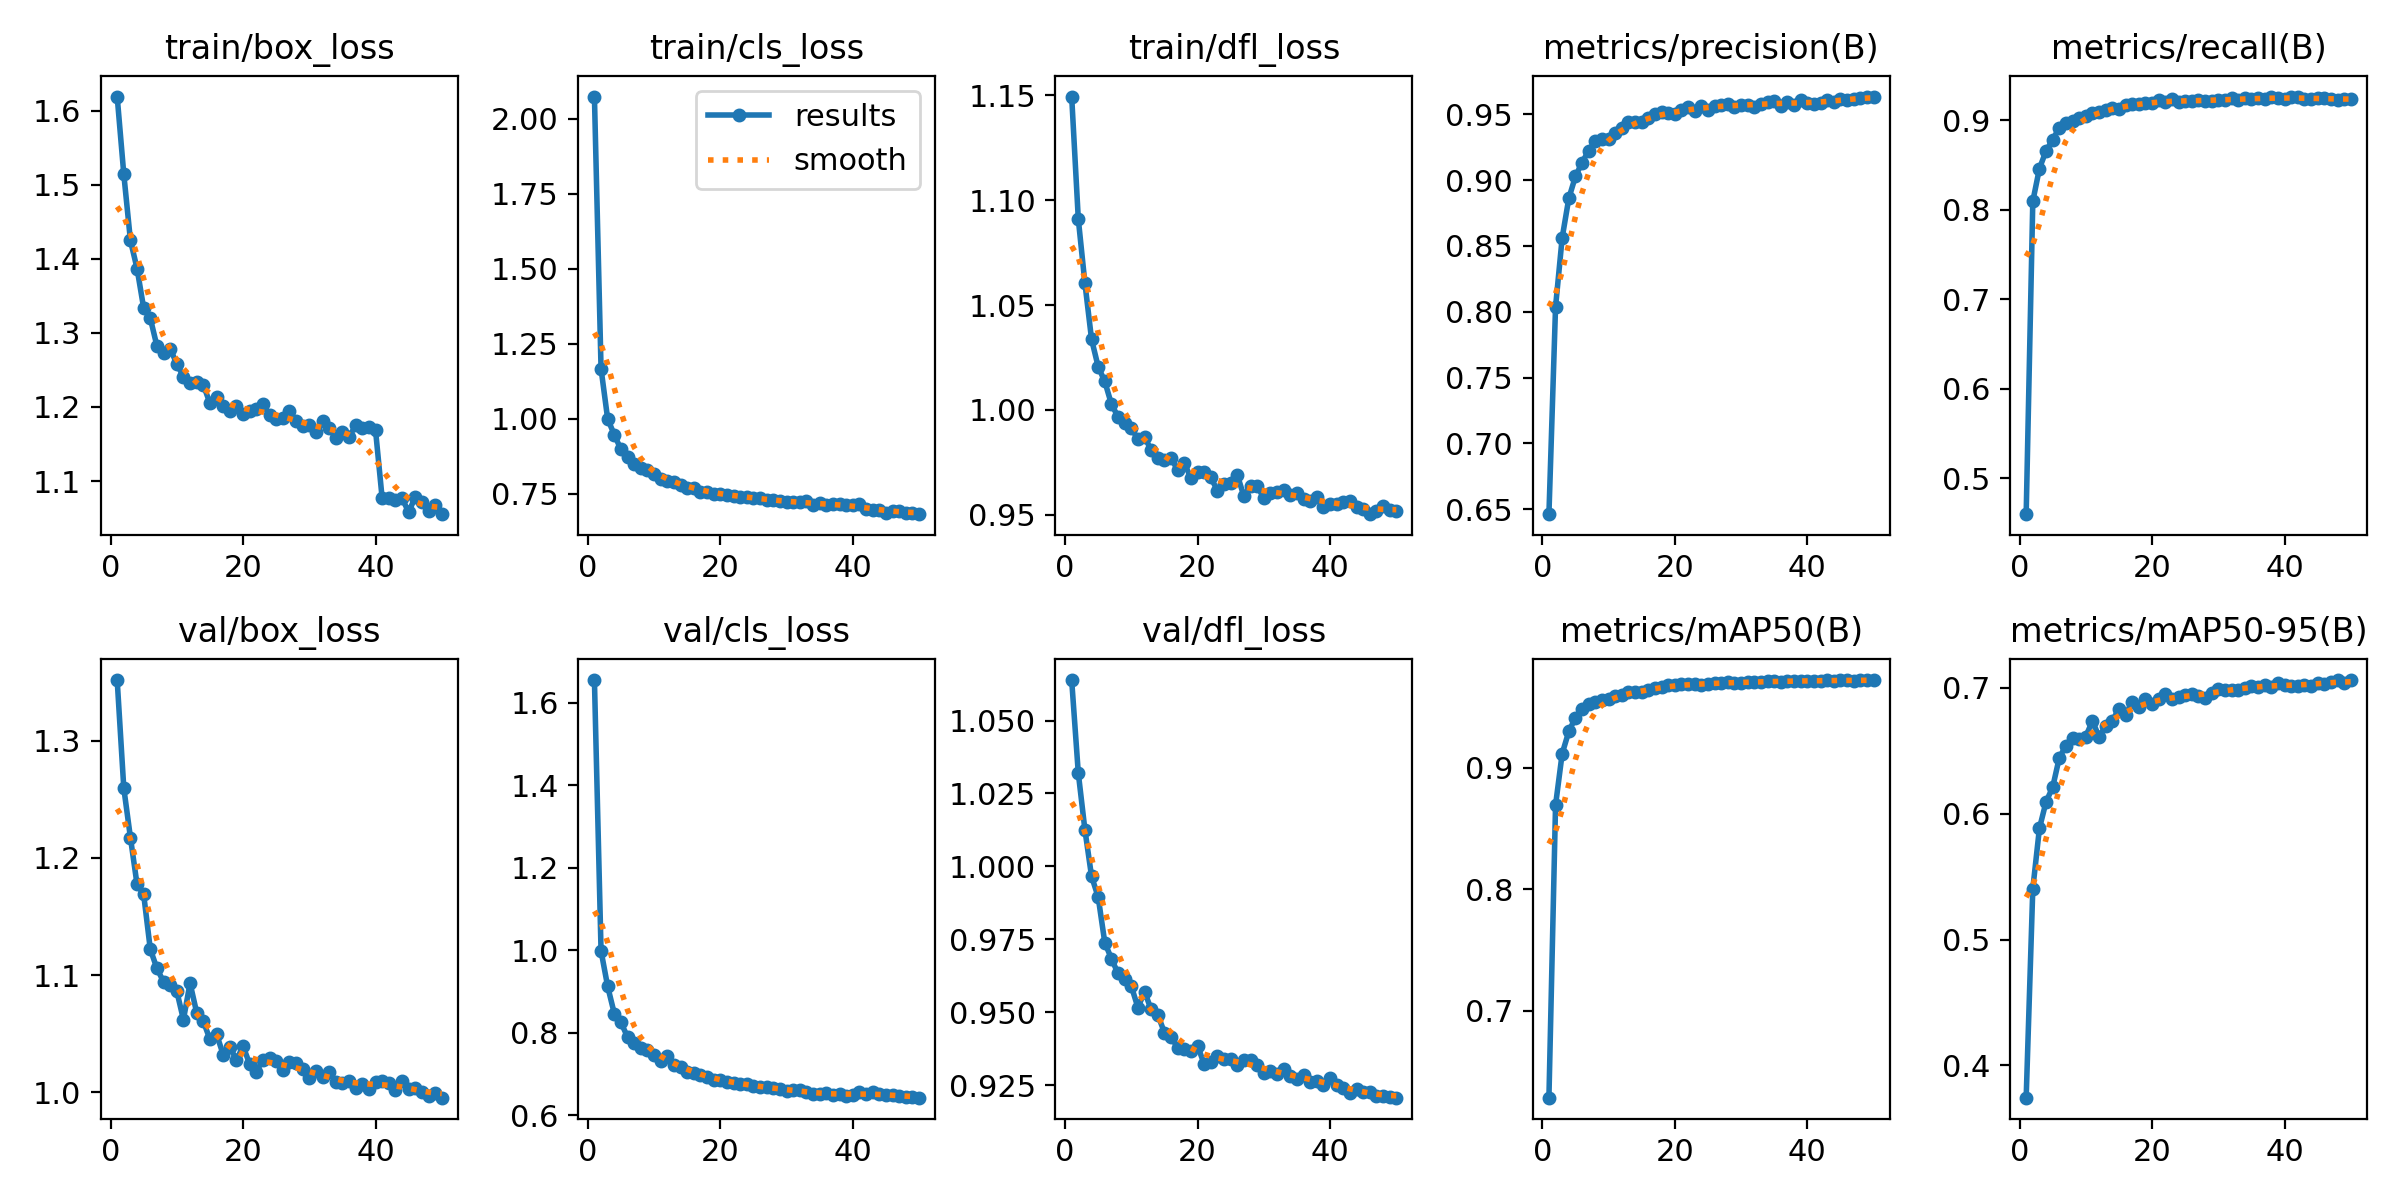

Results for yolov8n_sgd_lr0005_freeze21


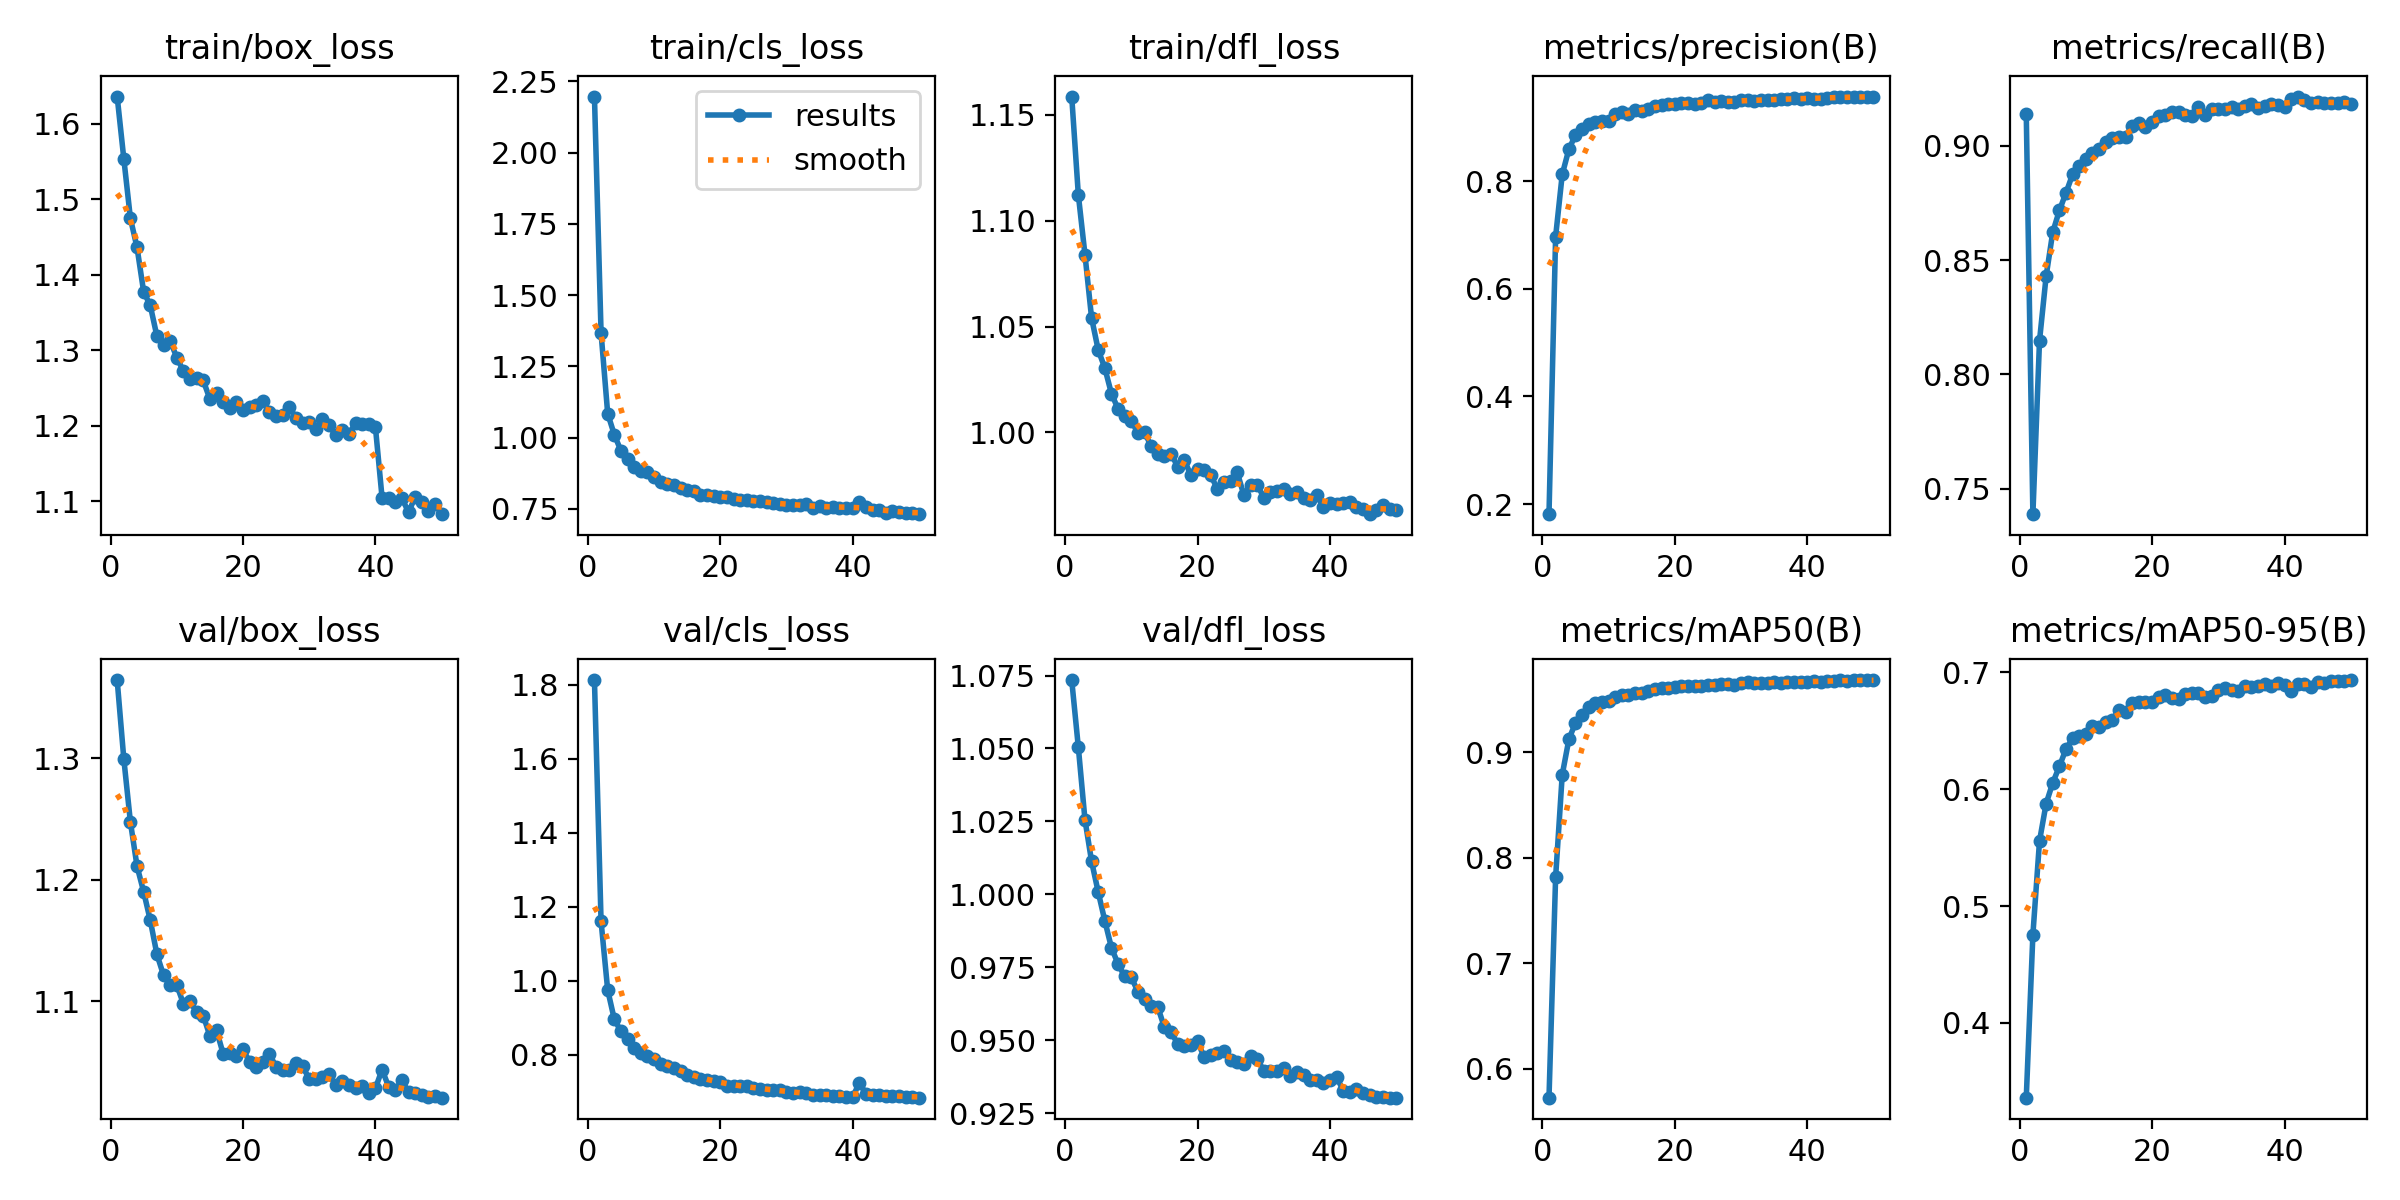

Results for yolov8n_adam_lr001_freeze21


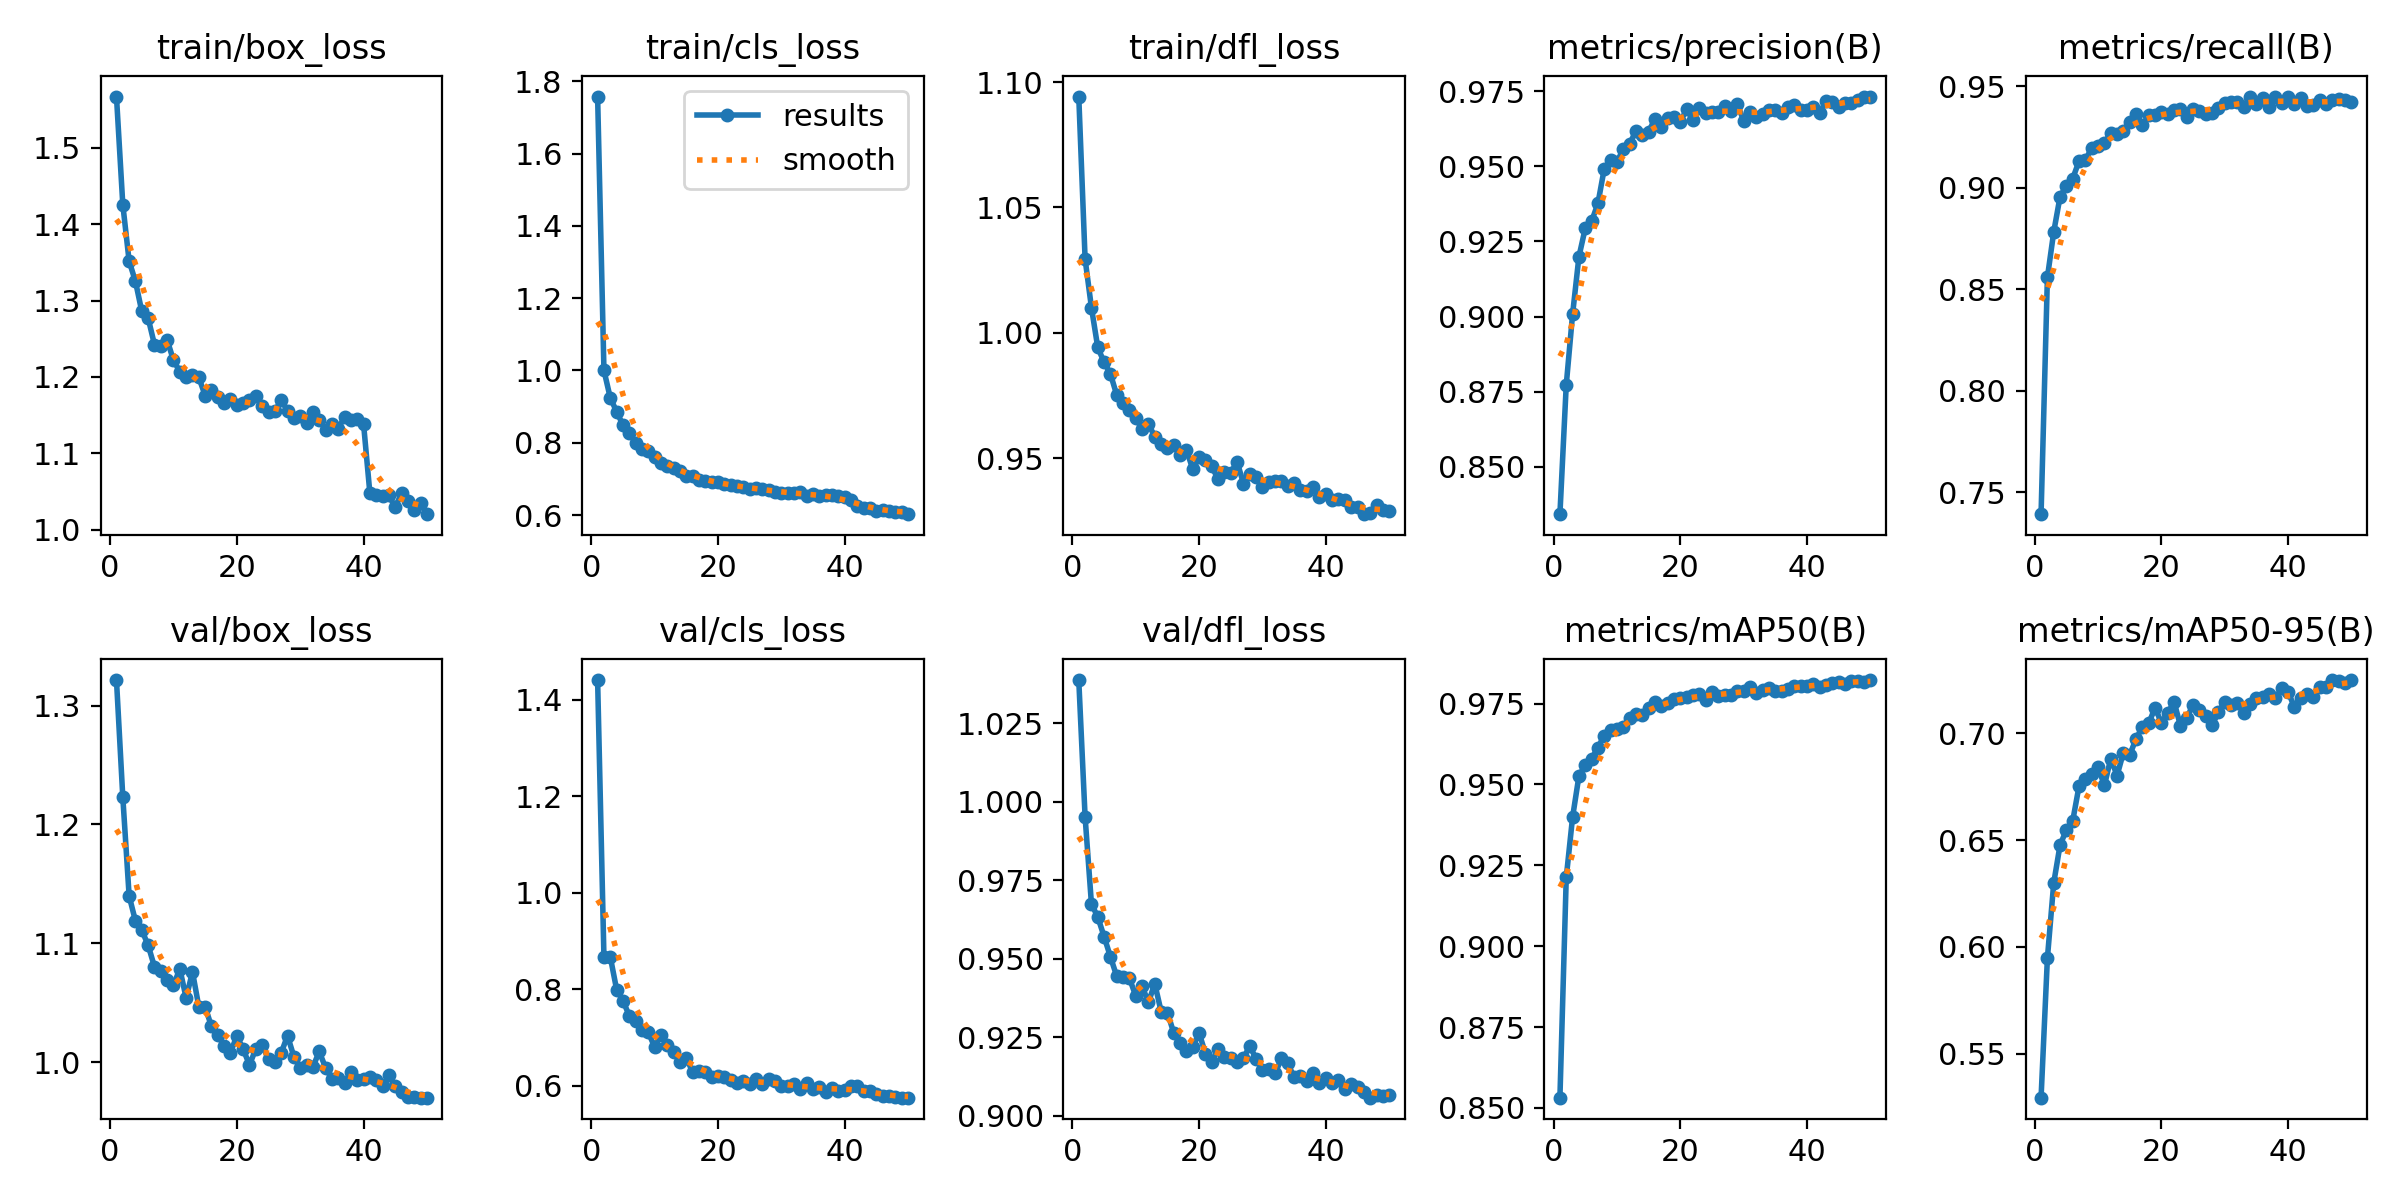

Results for yolov8n_adam_lr0001_freeze21


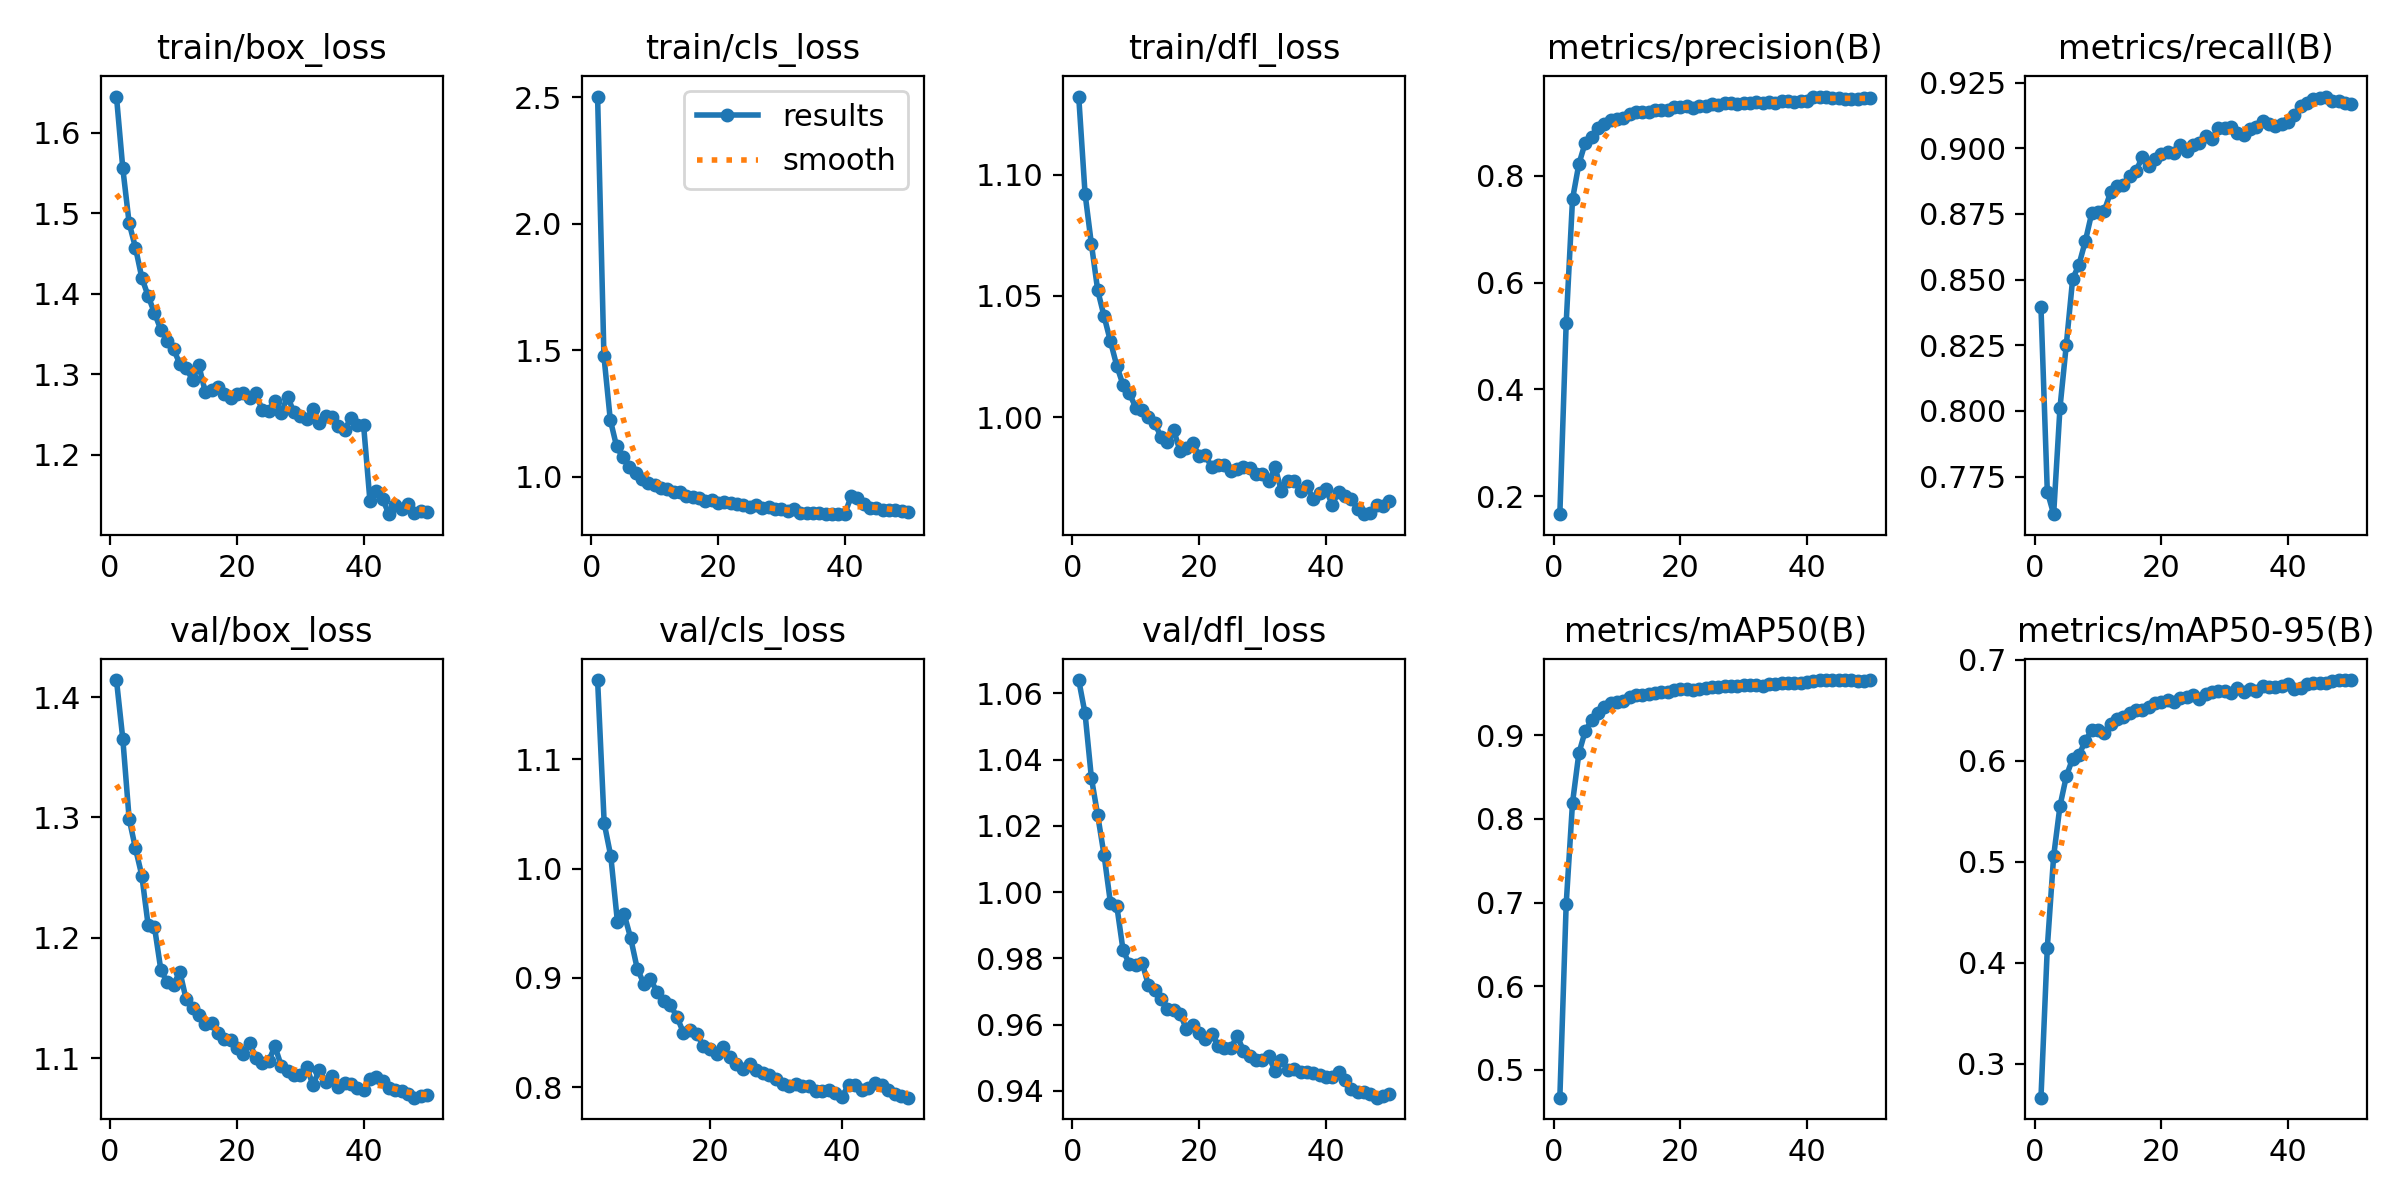

Model  Precision   Recall  Box Loss  Cls Loss  \
2   yolov8n_adam_lr001_freeze21    0.97310  0.94205   0.97033   0.57483   
0    yolov8n_sgd_lr001_freeze21    0.96337  0.92341   0.99538   0.64271   
1   yolov8n_sgd_lr0005_freeze21    0.95652  0.91840   1.02073   0.68383   
3  yolov8n_adam_lr0001_freeze21    0.94560  0.91684   1.06930   0.79049   

      Score  
2  0.611544  
0  0.590903  
1  0.579512  
3  0.558997

Best model based on precision, recall, and loss: yolov8n_adam_lr001_freeze21


In [19]:
model_names = [config["name"] for config in param_variants_21]
display_results_images(model_names)
best_model_21, df = evaluate_models(model_names)

### Train All Layers (No Freeze)

We do not freeze any layers.  
The entire YOLOv8n model is trained end-to-end.

**Advantages:**
- Maximum flexibility to learn dataset-specific features.
- Best option if you have enough data and GPU power.

**Disadvantages:**
- Slower training.
- May lead to overfitting if dataset is small or noisy.

In [20]:
param_variants_full = [
    {"name": "yolov8n_sgd_lr001_fulltrain", "batch": 16, "lr0": 0.001, "optimizer": "SGD", "freeze": 0},
    {"name": "yolov8n_sgd_lr0005_fulltrain", "batch": 16, "lr0": 0.0005, "optimizer": "SGD", "freeze": 0},
    {"name": "yolov8n_adam_lr001_fulltrain", "batch": 16, "lr0": 0.001, "optimizer": "Adam", "freeze": 0},
    {"name": "yolov8n_adam_lr0001_fulltrain", "batch": 32, "lr0": 0.0001, "optimizer": "Adam", "freeze": 0},
]

for config in param_variants_full:
    run_training(config)

Training: yolov8n_sgd_lr001_fulltrain
New https://pypi.org/project/ultralytics/8.3.138 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_s

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1249.3±1974.1 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_sgd_lr001_fulltrain/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_sgd_lr001_fulltrain
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.34G      1.505      2.241      1.105        779        640: 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        200      11906      0.879      0.797      0.902      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.25G      1.238      0.954     0.9866        948        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        200      11906      0.946      0.896       0.96      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.25G      1.122     0.7636     0.9513        600        640: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.957      0.929      0.973      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.25G      1.078     0.7057      0.928       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200      11906       0.96       0.94      0.976       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.25G      1.029     0.6577     0.9167       1092        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906      0.969      0.947       0.98      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.25G      1.014     0.6336     0.9099       1120        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.976       0.95      0.981      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.25G      0.976     0.6149     0.9029        940        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        200      11906       0.98       0.95      0.982      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.25G      0.971     0.6056     0.8987        831        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        200      11906      0.985      0.952      0.985      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.25G     0.9695     0.5981      0.895        664        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        200      11906      0.986      0.954      0.985       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.25G     0.9504      0.586      0.893       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


                   all        200      11906      0.988      0.956      0.986      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.25G     0.9389      0.575     0.8903       1226        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


                   all        200      11906      0.988      0.958      0.987      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.25G       0.93     0.5715     0.8891        624        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906      0.986      0.959      0.988      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.25G     0.9304     0.5657     0.8845       1065        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        200      11906      0.987       0.96      0.988      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.25G     0.9221     0.5566     0.8821        645        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        200      11906      0.987      0.963      0.989      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.25G     0.9043     0.5496     0.8802        908        640: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


                   all        200      11906      0.988      0.963      0.989       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.25G     0.9077     0.5476     0.8808        820        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]

                   all        200      11906       0.99      0.961       0.99      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.25G     0.8997      0.539     0.8776        838        640: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all        200      11906      0.989      0.965       0.99      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.25G     0.8939     0.5375     0.8792        669        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all        200      11906      0.989      0.967      0.991      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.34G      0.897     0.5342     0.8746        855        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


                   all        200      11906       0.99      0.966      0.991      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.83G     0.8899     0.5301     0.8771       1198        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        200      11906       0.99      0.967      0.991      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.37G     0.8855     0.5273     0.8753        734        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        200      11906      0.989      0.967      0.992      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.43G     0.8857     0.5228      0.873        978        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        200      11906      0.989      0.969      0.992      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.75G     0.8939      0.523     0.8695       1117        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


                   all        200      11906      0.989       0.97      0.992      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.75G      0.878     0.5171     0.8709        862        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        200      11906       0.99       0.97      0.992      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.61G     0.8755      0.517     0.8708       1059        640: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.989      0.972      0.992        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.61G     0.8737     0.5143     0.8728        858        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        200      11906       0.99      0.971      0.992      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.61G     0.8816     0.5127     0.8673        671        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

                   all        200      11906      0.992       0.97      0.992        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.61G     0.8726     0.5069     0.8696        703        640: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all        200      11906       0.99      0.971      0.992        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.52G      0.866     0.5032     0.8691        613        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        200      11906       0.99      0.971      0.992      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.84G     0.8651      0.503      0.866       1008        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        200      11906      0.991      0.972      0.992      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.84G     0.8571     0.4991     0.8661        757        640: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        200      11906      0.991      0.971      0.993      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.84G      0.864     0.5017     0.8669       1008        640: 100%|██████████| 63/63 [00:18<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.991      0.971      0.993      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.84G     0.8641     0.5029     0.8687        559        640: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        200      11906      0.992      0.973      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.84G     0.8487     0.4919     0.8655        748        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200      11906      0.991      0.973      0.993      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.84G     0.8516     0.4976     0.8662        730        640: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]

                   all        200      11906      0.992      0.973      0.993      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.84G     0.8449     0.4901      0.864        731        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


                   all        200      11906      0.991      0.973      0.993      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.84G     0.8561     0.4921     0.8635       1068        640: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.992      0.974      0.993      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.77G     0.8553     0.4881     0.8644        750        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


                   all        200      11906      0.992      0.974      0.993      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.77G     0.8563     0.4879     0.8613        878        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.992      0.974      0.993      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.77G     0.8521     0.4885     0.8623       1048        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


                   all        200      11906      0.992      0.974      0.993      0.807
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.77G     0.8337     0.5634     0.8707        669        640: 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        200      11906      0.991      0.973      0.993      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.77G     0.8211     0.5172     0.8674        577        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        200      11906      0.989      0.976      0.993        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.77G     0.8146     0.4968     0.8663        444        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

                   all        200      11906      0.992      0.972      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.77G     0.8091     0.4969     0.8626        422        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906      0.992      0.973      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.77G     0.7979     0.4852     0.8636        483        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        200      11906      0.991      0.973      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.77G     0.8101     0.4889     0.8608        408        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        200      11906      0.992      0.973      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.77G     0.8023     0.4853     0.8613        407        640: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.991      0.974      0.993      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.77G     0.7919     0.4805     0.8623        695        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        200      11906      0.991      0.974      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.77G      0.801       0.48     0.8622        595        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        200      11906      0.991      0.973      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.77G     0.7853     0.4744     0.8602        592        640: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        200      11906      0.991      0.974      0.993      0.809



50 epochs completed in 0.290 hours.
Optimizer stripped from runs/detect/yolov8n_sgd_lr001_fulltrain/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sgd_lr001_fulltrain/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sgd_lr001_fulltrain/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


                   all        200      11906      0.991      0.974      0.993      0.809


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/yolov8n_sgd_lr001_fulltrain
Training: yolov8n_sgd_lr0005_fulltrain
New https://pypi.org/project/ultralytics/8.3.138 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 476.3±230.8 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_sgd_lr0005_fulltrain/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_sgd_lr0005_fulltrain
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.33G      1.545       2.36      1.122        779        640: 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        200      11906      0.192      0.966        0.8      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.25G      1.297       1.19      1.013        948        640: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200      11906      0.906      0.872      0.944      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.25G       1.18     0.8551     0.9731        600        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        200      11906      0.948      0.906      0.964       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.26G      1.123     0.7724     0.9445       1112        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906      0.962      0.929      0.974      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.26G      1.065     0.7197     0.9307       1092        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        200      11906       0.96      0.941      0.976      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.27G      1.044     0.6845     0.9218       1120        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906      0.961      0.948      0.978      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.27G      1.008     0.6615     0.9144        940        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        200      11906       0.97      0.946       0.98      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.27G     0.9988     0.6475      0.909        831        640: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        200      11906      0.977      0.947      0.981      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.27G      0.999     0.6387     0.9058        664        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

                   all        200      11906      0.975      0.948      0.981      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.27G     0.9788     0.6233     0.9038       1112        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.983      0.949      0.982      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.27G     0.9645     0.6099     0.9005       1226        640: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        200      11906      0.984      0.952      0.983      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.27G     0.9546     0.6049     0.8991        624        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        200      11906      0.983      0.951      0.984      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.27G     0.9544     0.5994      0.894       1065        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.984      0.955      0.985      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.27G     0.9471      0.591     0.8913        645        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


                   all        200      11906      0.983      0.956      0.985       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.27G     0.9288     0.5832     0.8894        908        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.986      0.956      0.986      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.27G     0.9328     0.5823     0.8897        820        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.985      0.956      0.986       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.27G     0.9253     0.5735     0.8865        838        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906      0.987      0.957      0.987      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.27G     0.9202     0.5724     0.8881        669        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        200      11906      0.988      0.961      0.988      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.35G     0.9244     0.5696     0.8833        855        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        200      11906      0.987       0.96      0.988      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.83G     0.9174      0.565     0.8862       1198        640: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        200      11906      0.986      0.962      0.988      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.37G     0.9136     0.5613     0.8844        734        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        200      11906      0.987      0.963      0.989      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.43G     0.9141     0.5571      0.882        978        640: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        200      11906      0.988      0.963      0.989      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.75G     0.9224     0.5581     0.8784       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        200      11906      0.988      0.963      0.989      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.75G     0.9076     0.5528     0.8801        862        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        200      11906      0.989      0.963      0.989       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.61G     0.9046     0.5529       0.88       1059        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        200      11906      0.988      0.965      0.989      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.61G     0.9038     0.5504     0.8823        858        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

                   all        200      11906      0.988      0.965      0.989      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.61G     0.9118     0.5479     0.8761        671        640: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.988      0.965       0.99      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.61G     0.9024     0.5427     0.8788        703        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200      11906      0.989      0.964       0.99      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.52G      0.897     0.5395     0.8786        613        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


                   all        200      11906       0.99      0.964       0.99      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.84G     0.8959     0.5384     0.8749       1008        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906      0.989      0.966      0.991      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.84G     0.8888      0.536     0.8756        757        640: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        200      11906      0.989      0.966      0.991      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.84G     0.8964     0.5382     0.8764       1008        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906       0.99      0.965      0.991      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.84G     0.8948     0.5402     0.8779        559        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]

                   all        200      11906       0.99      0.965      0.991      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.84G     0.8799     0.5286      0.875        748        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


                   all        200      11906       0.99      0.966      0.991      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.84G     0.8838     0.5349     0.8757        730        640: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.991      0.966      0.991      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.84G     0.8778     0.5281     0.8738        731        640: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all        200      11906      0.991      0.966      0.991      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.84G     0.8905     0.5299     0.8729       1068        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        200      11906      0.991      0.966      0.991      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.77G      0.888     0.5251     0.8737        750        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        200      11906      0.991      0.966      0.991      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.77G     0.8908     0.5258     0.8708        878        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        200      11906      0.991      0.967      0.991      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.77G     0.8854      0.526     0.8719       1048        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


                   all        200      11906      0.991      0.967      0.991      0.799
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.77G     0.8648     0.6323     0.8808        669        640: 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.989      0.966      0.991       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.77G     0.8571     0.5748     0.8787        577        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        200      11906      0.987      0.969      0.991      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.77G     0.8522     0.5583     0.8768        444        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


                   all        200      11906      0.988      0.969      0.991      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.78G     0.8468     0.5547     0.8727        422        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200      11906      0.988      0.969      0.991       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.78G     0.8322      0.538     0.8729        483        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        200      11906      0.989      0.968      0.992      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.79G     0.8458      0.543     0.8707        408        640: 100%|██████████| 63/63 [00:16<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        200      11906       0.99      0.968      0.992      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.79G     0.8379     0.5379     0.8711        407        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        200      11906      0.989      0.969      0.992      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       7.8G     0.8278     0.5329     0.8725        695        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]

                   all        200      11906      0.989      0.969      0.992      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       7.8G     0.8366      0.533     0.8719        595        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200      11906      0.989       0.97      0.992      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.8G     0.8193     0.5257     0.8696        592        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.989      0.969      0.992      0.798



50 epochs completed in 0.290 hours.
Optimizer stripped from runs/detect/yolov8n_sgd_lr0005_fulltrain/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_sgd_lr0005_fulltrain/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_sgd_lr0005_fulltrain/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


                   all        200      11906      0.991      0.967      0.991      0.801


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/yolov8n_sgd_lr0005_fulltrain
Training: yolov8n_adam_lr001_fulltrain
New https://pypi.org/project/ultralytics/8.3.138 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1285.8±1782.4 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_adam_lr001_fulltrain/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_adam_lr001_fulltrain
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.34G      1.344      1.435     0.9799        779        640: 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        200      11906      0.947      0.879      0.952      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.28G      1.134     0.7353     0.9155        948        640: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        200      11906      0.975      0.935      0.978       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.29G      1.052     0.6593     0.8985        600        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200      11906      0.981      0.944      0.984      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.29G      1.014     0.6205     0.8851       1112        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]

                   all        200      11906      0.986      0.955      0.988      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.29G     0.9511     0.5719     0.8742       1092        640: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        200      11906      0.988      0.964       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       7.3G     0.9488      0.553     0.8708       1120        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        200      11906       0.99      0.971      0.991       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       7.3G     0.9128     0.5325     0.8656        940        640: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


                   all        200      11906      0.992      0.973      0.992      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       7.3G     0.9126     0.5179     0.8636        831        640: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        200      11906      0.992      0.973      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       7.3G     0.8992     0.5041     0.8586        664        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


                   all        200      11906      0.989      0.973      0.993      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       7.3G     0.8818      0.489     0.8575       1112        640: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


                   all        200      11906      0.991      0.973      0.993      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       7.3G     0.8677     0.4811     0.8544       1226        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


                   all        200      11906       0.99      0.974      0.993      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       7.3G     0.8594     0.4723      0.854        624        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        200      11906      0.989      0.979      0.993      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       7.3G     0.8631     0.4675     0.8513       1065        640: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200      11906      0.991      0.978      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       7.3G      0.851      0.462     0.8494        645        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        200      11906      0.992      0.978      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       7.3G     0.8343     0.4517     0.8478        908        640: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        200      11906      0.992      0.977      0.994      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       7.3G     0.8446     0.4488      0.849        820        640: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        200      11906      0.991      0.979      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       7.3G     0.8355     0.4431     0.8469        838        640: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        200      11906      0.993      0.979      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.31G      0.825     0.4336     0.8465        669        640: 100%|██████████| 63/63 [00:17<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        200      11906      0.992       0.98      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.39G     0.8212     0.4304     0.8424        855        640: 100%|██████████| 63/63 [00:18<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]

                   all        200      11906      0.991      0.982      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.84G     0.8104     0.4265     0.8442       1198        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        200      11906      0.991      0.983      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.38G     0.8135     0.4242     0.8432        734        640: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


                   all        200      11906      0.992      0.984      0.994      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.44G      0.814     0.4226     0.8421        978        640: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        200      11906      0.991      0.981      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.75G     0.8138     0.4221     0.8392       1117        640: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

                   all        200      11906      0.992      0.983      0.994       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.75G     0.7945      0.414     0.8388        862        640: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        200      11906      0.991      0.984      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.61G      0.799     0.4123     0.8391       1059        640: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        200      11906      0.988      0.984      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.61G     0.7902     0.4088     0.8403        858        640: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        200      11906      0.992      0.982      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.61G     0.8004     0.4106     0.8369        671        640: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


                   all        200      11906      0.992      0.982      0.994      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.61G     0.7974     0.4079     0.8391        703        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


                   all        200      11906      0.993      0.982      0.994      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.53G     0.7874     0.4015     0.8378        613        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200      11906      0.992      0.985      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.84G     0.7826     0.3965     0.8354       1008        640: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        200      11906      0.992      0.985      0.994      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.84G     0.7718     0.3924     0.8348        757        640: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        200      11906      0.992      0.984      0.994       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.84G     0.7797     0.3957      0.836       1008        640: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        200      11906      0.994      0.982      0.994       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.85G     0.7791     0.3938     0.8367        559        640: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        200      11906      0.993      0.984      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.85G     0.7641     0.3865     0.8342        748        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        200      11906      0.994      0.984      0.994      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.86G     0.7668     0.3873     0.8345        730        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        200      11906      0.993      0.985      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.87G     0.7546     0.3813     0.8319        731        640: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        200      11906      0.993      0.987      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.87G     0.7641      0.383      0.832       1068        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

                   all        200      11906      0.994      0.984      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.79G     0.7699     0.3836     0.8335        750        640: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

                   all        200      11906      0.994      0.984      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       7.8G     0.7677     0.3801     0.8312        878        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        200      11906      0.995      0.984      0.994       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.81G      0.756     0.3772     0.8302       1048        640: 100%|██████████| 63/63 [00:18<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        200      11906      0.994      0.985      0.994      0.834


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.81G     0.7337     0.3765     0.8316        669        640: 100%|██████████| 63/63 [00:19<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        200      11906      0.992      0.986      0.994      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.81G     0.7246     0.3684     0.8299        577        640: 100%|██████████| 63/63 [00:16<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


                   all        200      11906      0.993      0.985      0.994      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.83G     0.7242      0.363     0.8307        444        640: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

                   all        200      11906      0.994      0.985      0.994      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.83G     0.7203     0.3608     0.8277        422        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

                   all        200      11906      0.993      0.986      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.84G      0.707     0.3521     0.8284        483        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

                   all        200      11906      0.994      0.984      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.85G     0.7132     0.3545     0.8256        408        640: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        200      11906      0.994      0.984      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.85G     0.7048     0.3509     0.8259        407        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        200      11906      0.994      0.985      0.994      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.85G     0.6967     0.3448     0.8262        695        640: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        200      11906      0.994      0.985      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.85G     0.7012     0.3447     0.8265        595        640: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        200      11906      0.994      0.985      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.85G     0.6889     0.3395     0.8244        592        640: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


                   all        200      11906      0.995      0.985      0.994      0.838

50 epochs completed in 0.289 hours.
Optimizer stripped from runs/detect/yolov8n_adam_lr001_fulltrain/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_adam_lr001_fulltrain/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_adam_lr001_fulltrain/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


                   all        200      11906      0.995      0.985      0.994      0.838


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/yolov8n_adam_lr001_fulltrain
Training: yolov8n_adam_lr0001_fulltrain
New https://pypi.org/project/ultralytics/8.3.138 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00

train: Scanning /kaggle/working/cars_dataset/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1064.4±1581.9 MB/s, size: 1312.4 KB)


val: Scanning /kaggle/working/cars_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_adam_lr0001_fulltrain/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_adam_lr0001_fulltrain
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.1G      1.473      2.172      1.028       1214        640: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        200      11906      0.161      0.787      0.513      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.48G      1.215     0.9889     0.9367        689        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


                   all        200      11906      0.918       0.71      0.865      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.1G      1.124     0.8298     0.9188        653        640: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        200      11906      0.976      0.914      0.968      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.04G      1.087     0.7549     0.9058        933        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


                   all        200      11906       0.98      0.939      0.978      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.8G      1.068     0.7295      0.902       1109        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


                   all        200      11906      0.982      0.942       0.98      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.7G       1.04     0.7008     0.8952       1017        640: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        200      11906      0.986      0.952      0.982      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50        11G      1.037     0.6885     0.8928       1080        640: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        200      11906      0.988      0.953      0.983      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.6G       1.01     0.6679     0.8861        927        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


                   all        200      11906      0.988      0.952      0.984      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.87G     0.9903     0.6559      0.883       1062        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


                   all        200      11906      0.987      0.955      0.985      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      12.1G     0.9829     0.6461       0.88        767        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        200      11906      0.986      0.959      0.987      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50        11G     0.9722      0.638     0.8806       1124        640: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        200      11906      0.988      0.955      0.986       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.8G     0.9665     0.6309      0.877        617        640: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        200      11906       0.99      0.958      0.987      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       6.6G     0.9503     0.6199     0.8741       1220        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200      11906      0.989      0.957      0.988      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       6.6G     0.9578      0.613     0.8698        842        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


                   all        200      11906      0.988      0.963      0.989       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       6.6G     0.9353     0.6038     0.8696        597        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        200      11906      0.988      0.965       0.99      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.96G     0.9274     0.5966     0.8707        960        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        200      11906      0.989      0.965       0.99      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.9G     0.9315     0.5948     0.8664        616        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        200      11906       0.99      0.966       0.99       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      12.2G     0.9184     0.5842     0.8661        696        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        200      11906       0.99      0.966      0.991      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.83G     0.9133     0.5817     0.8665       1121        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        200      11906      0.992      0.964      0.991      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.2G     0.9197     0.5765     0.8655       1124        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        200      11906      0.991      0.966      0.991      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50        12G      0.923     0.5789     0.8655       1075        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


                   all        200      11906      0.991      0.967      0.991      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      12.4G      0.911     0.5731     0.8621        665        640: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


                   all        200      11906      0.989      0.969      0.991      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        12G     0.9069     0.5687     0.8609        792        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        200      11906       0.99       0.97      0.992      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.99G     0.8987     0.5667     0.8612        392        640: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        200      11906      0.991      0.969      0.991      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.2G      0.897     0.5571     0.8589        867        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


                   all        200      11906      0.991       0.97      0.992      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.5G     0.9017     0.5627     0.8598       1153        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


                   all        200      11906       0.99       0.97      0.992      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.22G     0.8892     0.5531     0.8588        753        640: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


                   all        200      11906      0.991      0.972      0.992      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      13.1G     0.9017     0.5562     0.8585       1228        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        200      11906       0.99      0.973      0.992      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.4G     0.8889     0.5478      0.857        905        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        200      11906      0.991      0.973      0.992        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.11G     0.8851     0.5471     0.8572        806        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


                   all        200      11906      0.991      0.974      0.993      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.4G     0.8816     0.5416     0.8554        826        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        200      11906      0.992      0.973      0.993      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.58G     0.8836     0.5444     0.8569       1009        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


                   all        200      11906      0.992      0.975      0.993        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.55G     0.8732     0.5368     0.8537        885        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        200      11906      0.992      0.972      0.992      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.4G     0.8745     0.5364     0.8546        789        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        200      11906      0.991      0.975      0.993      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.3G     0.8763     0.5335     0.8547        918        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


                   all        200      11906      0.992      0.973      0.993      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      14.9G     0.8691     0.5313     0.8526        688        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


                   all        200      11906      0.993      0.974      0.993      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.81G     0.8654     0.5296     0.8538        722        640: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


                   all        200      11906      0.992      0.976      0.993      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50        11G     0.8805      0.533     0.8518       1107        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


                   all        200      11906      0.992      0.975      0.993      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.21G     0.8702     0.5316     0.8523        970        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        200      11906      0.992      0.974      0.993      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.5G     0.8582     0.5249     0.8515        686        640: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


                   all        200      11906      0.992      0.975      0.993      0.805
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.37G     0.8555     0.6632     0.8559        692        640: 100%|██████████| 32/32 [00:20<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        200      11906      0.992      0.975      0.993      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.15G     0.8507      0.609     0.8553        657        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        200      11906      0.991      0.977      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.15G      0.835     0.5781     0.8508        549        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        200      11906      0.991      0.978      0.993      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.15G     0.8191     0.5686     0.8487        413        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        200      11906      0.989      0.978      0.993      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.15G     0.8246      0.561      0.847        510        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


                   all        200      11906       0.99      0.978      0.993      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.15G      0.818     0.5546     0.8457        426        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


                   all        200      11906      0.991      0.976      0.993      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.15G     0.8175     0.5517     0.8447        440        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


                   all        200      11906      0.991      0.977      0.993      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.17G     0.8112     0.5502     0.8464        681        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all        200      11906      0.991      0.977      0.993        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.18G     0.8117     0.5463     0.8468        515        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


                   all        200      11906      0.991      0.977      0.993        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.2G     0.8052      0.541     0.8454        642        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        200      11906      0.991      0.977      0.993        0.8



50 epochs completed in 0.278 hours.
Optimizer stripped from runs/detect/yolov8n_adam_lr0001_fulltrain/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_adam_lr0001_fulltrain/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_adam_lr0001_fulltrain/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


                   all        200      11906      0.992      0.975      0.993      0.805


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to runs/detect/yolov8n_adam_lr0001_fulltrain


Results for yolov8n_sgd_lr001_fulltrain


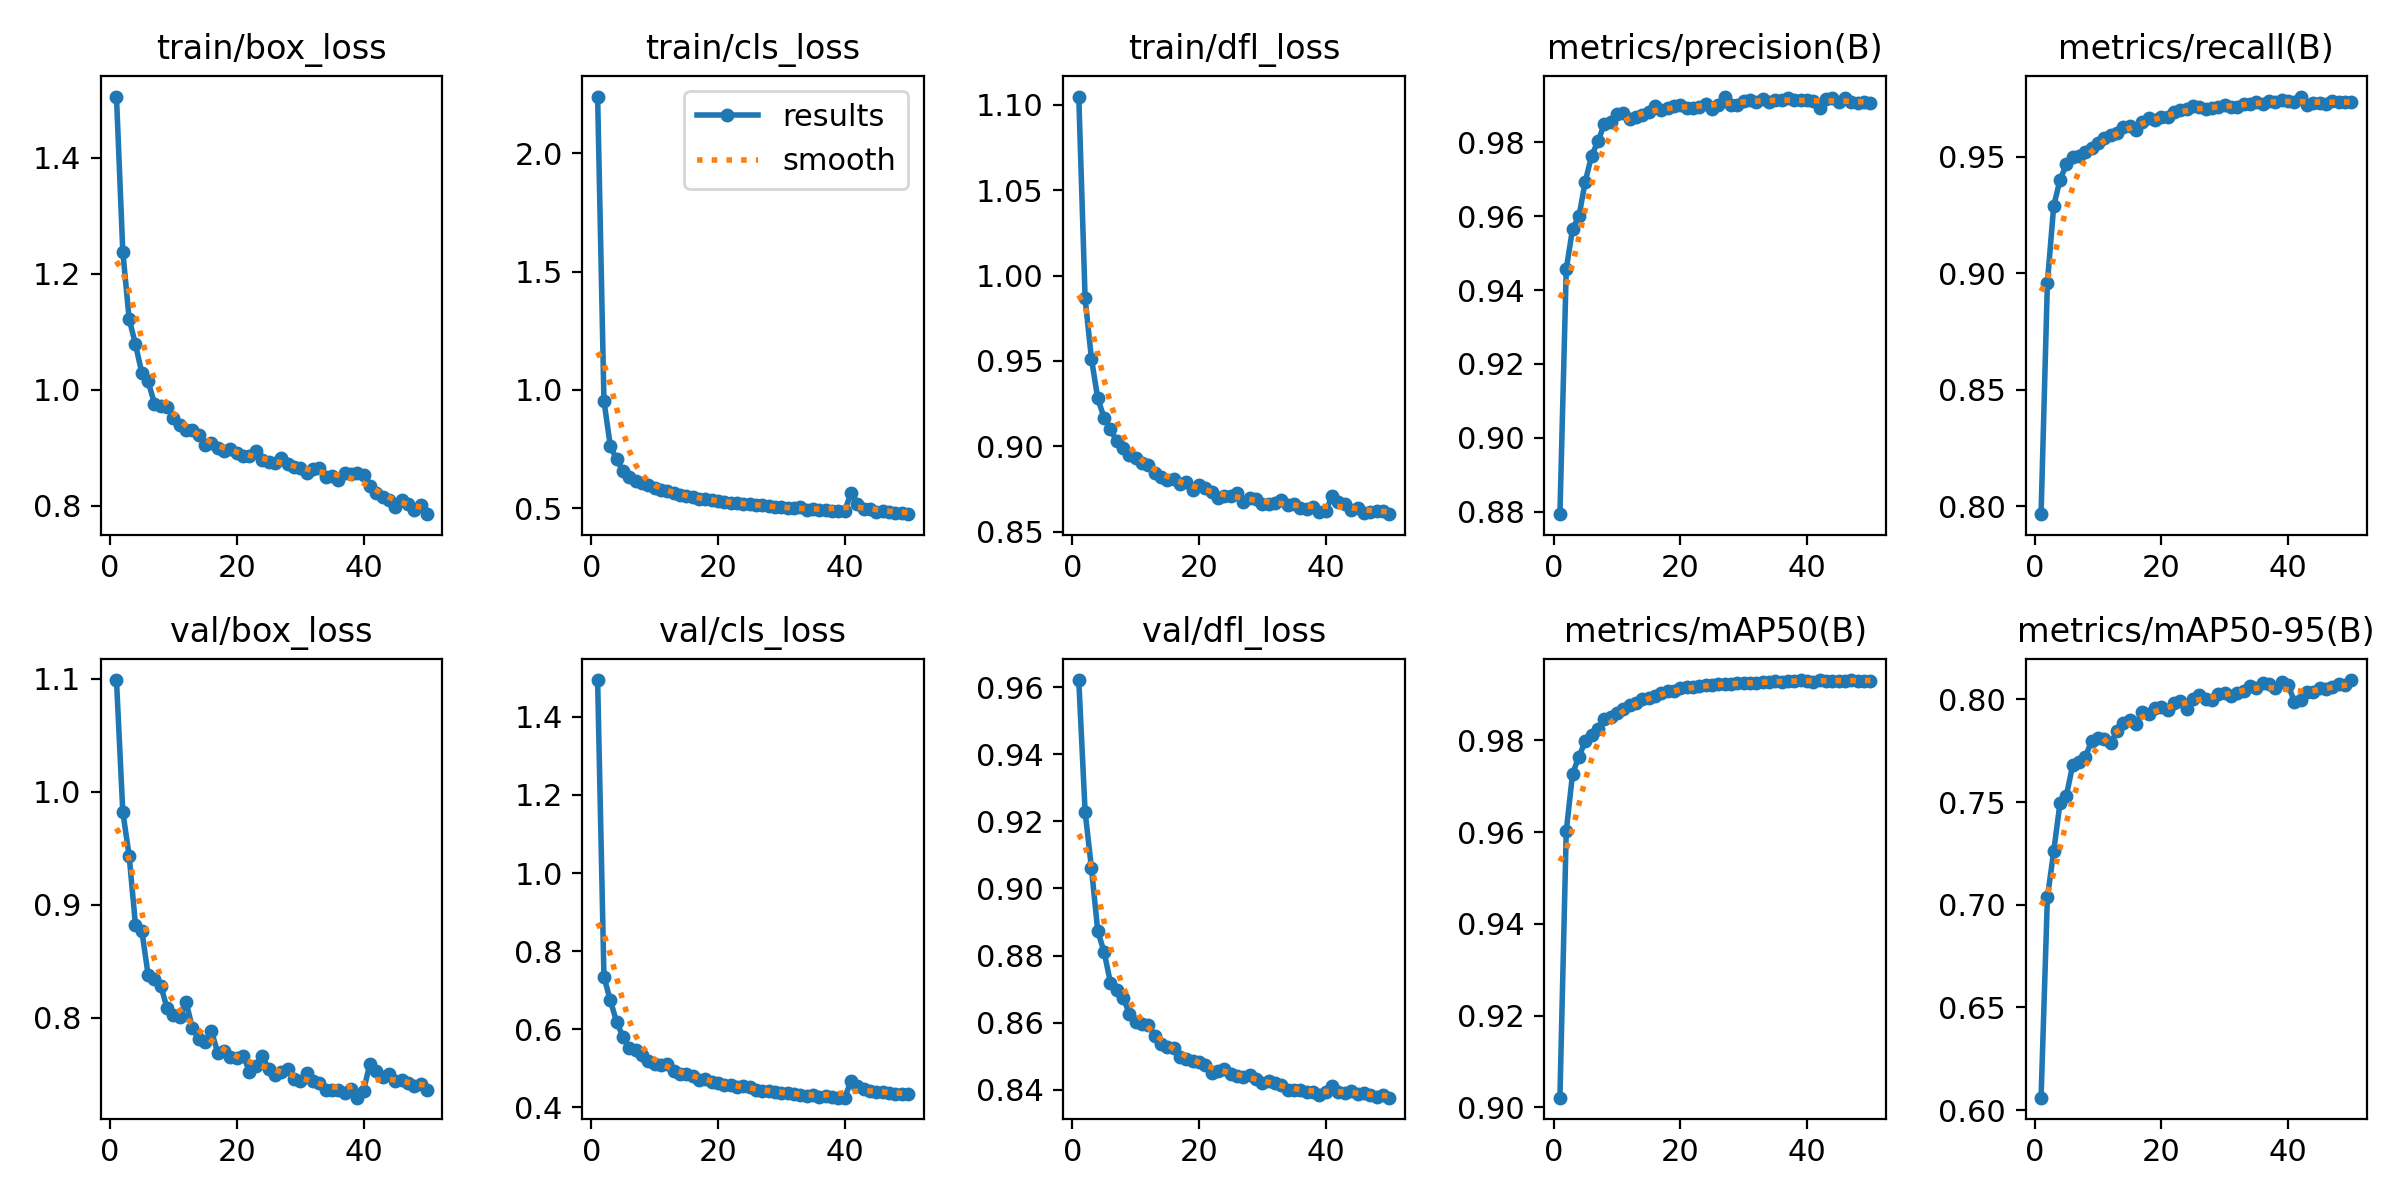

Results for yolov8n_sgd_lr0005_fulltrain


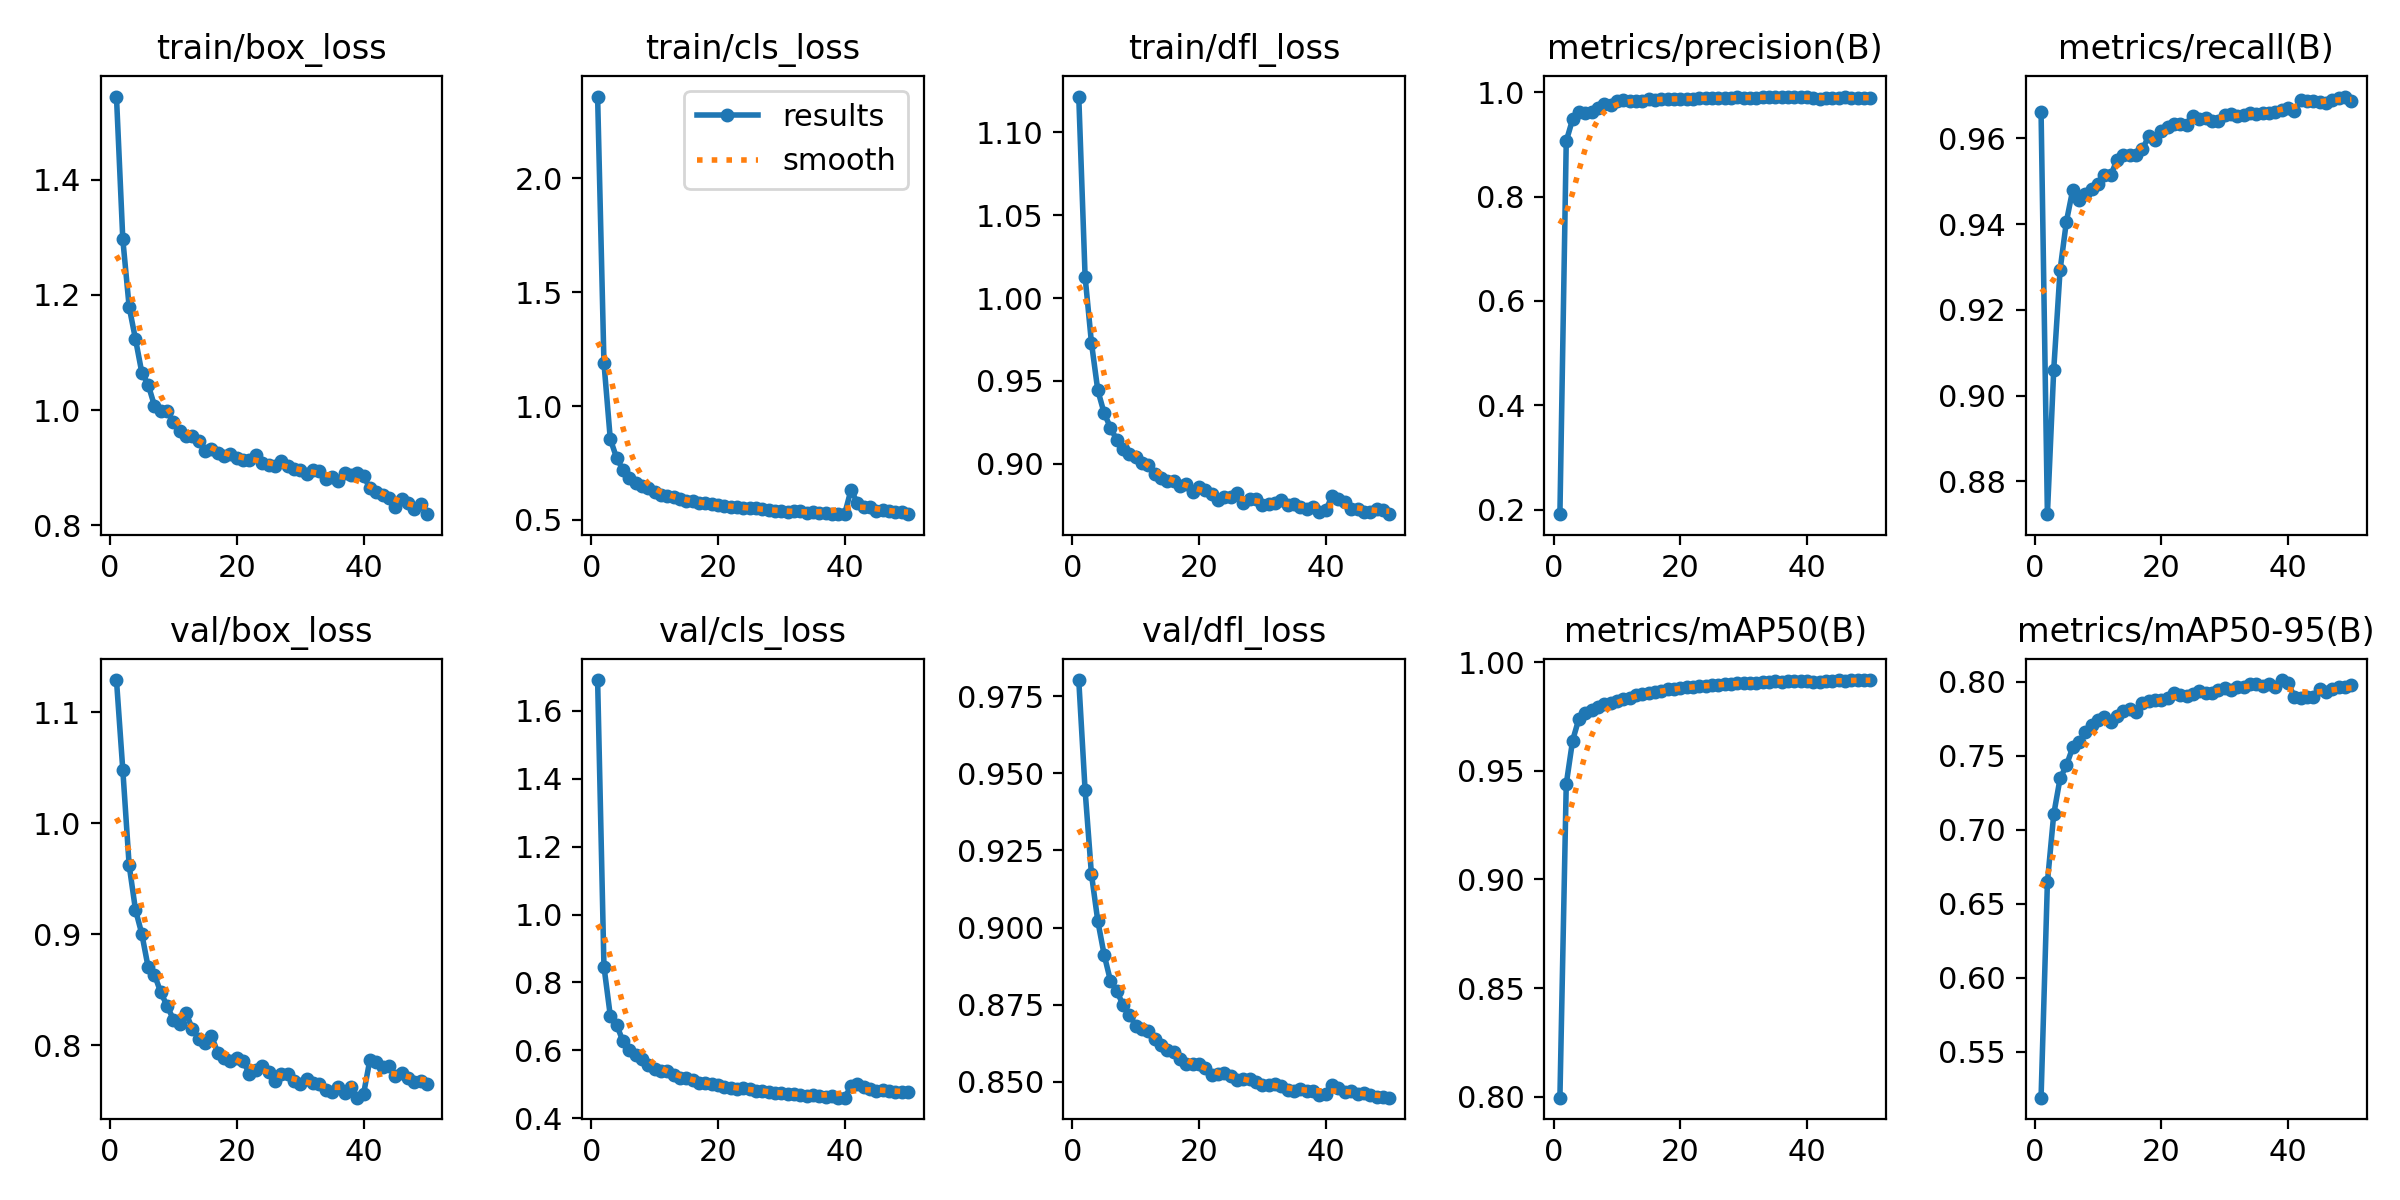

Results for yolov8n_adam_lr001_fulltrain


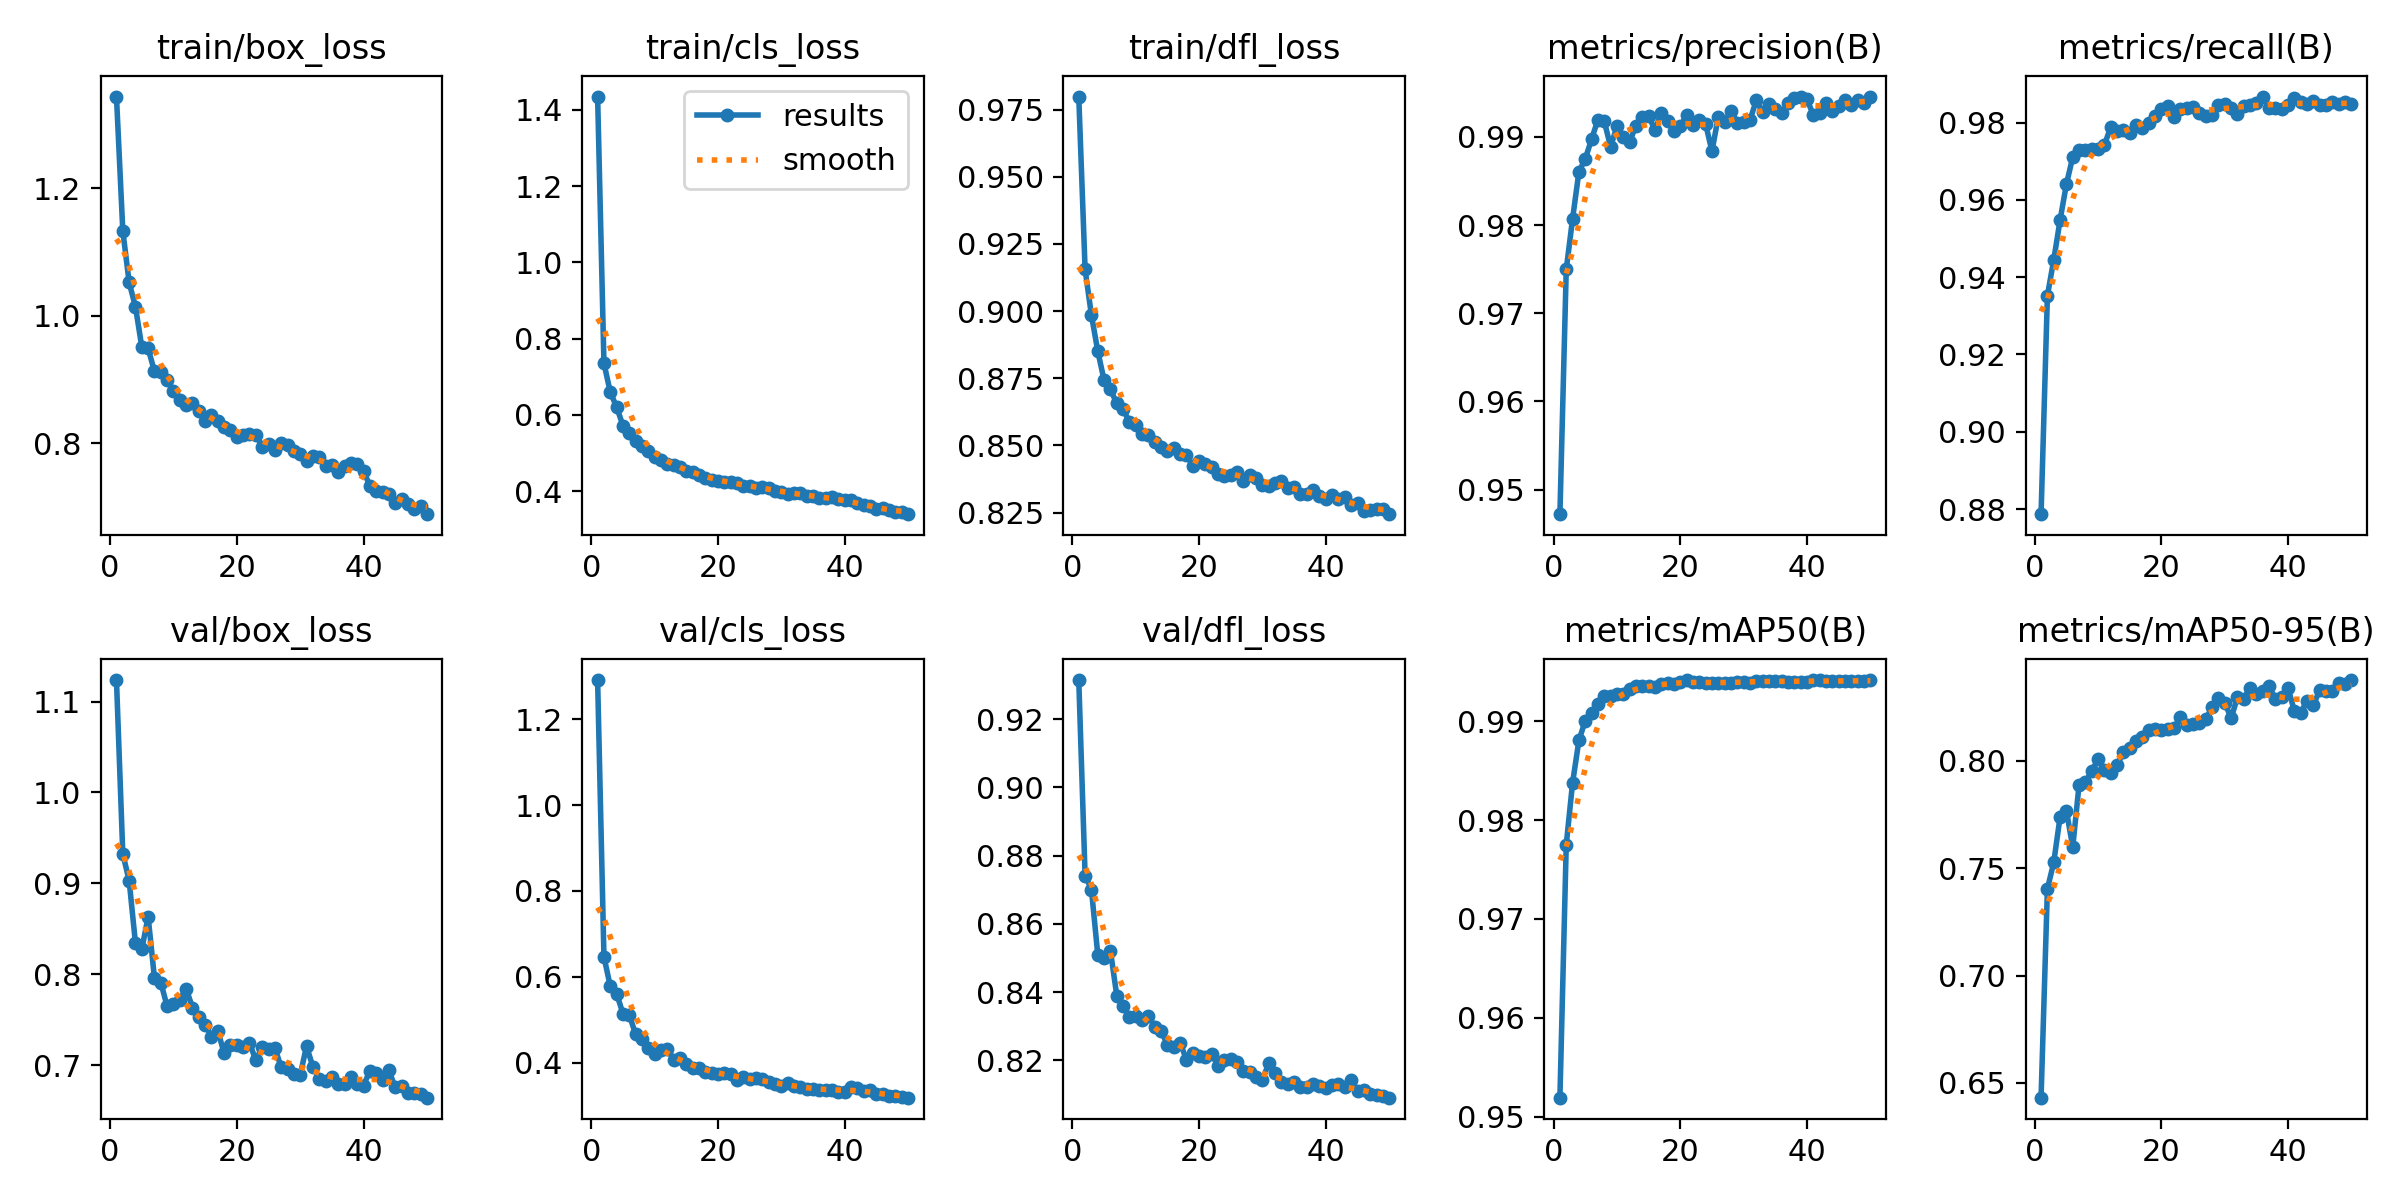

Results for yolov8n_adam_lr0001_fulltrain


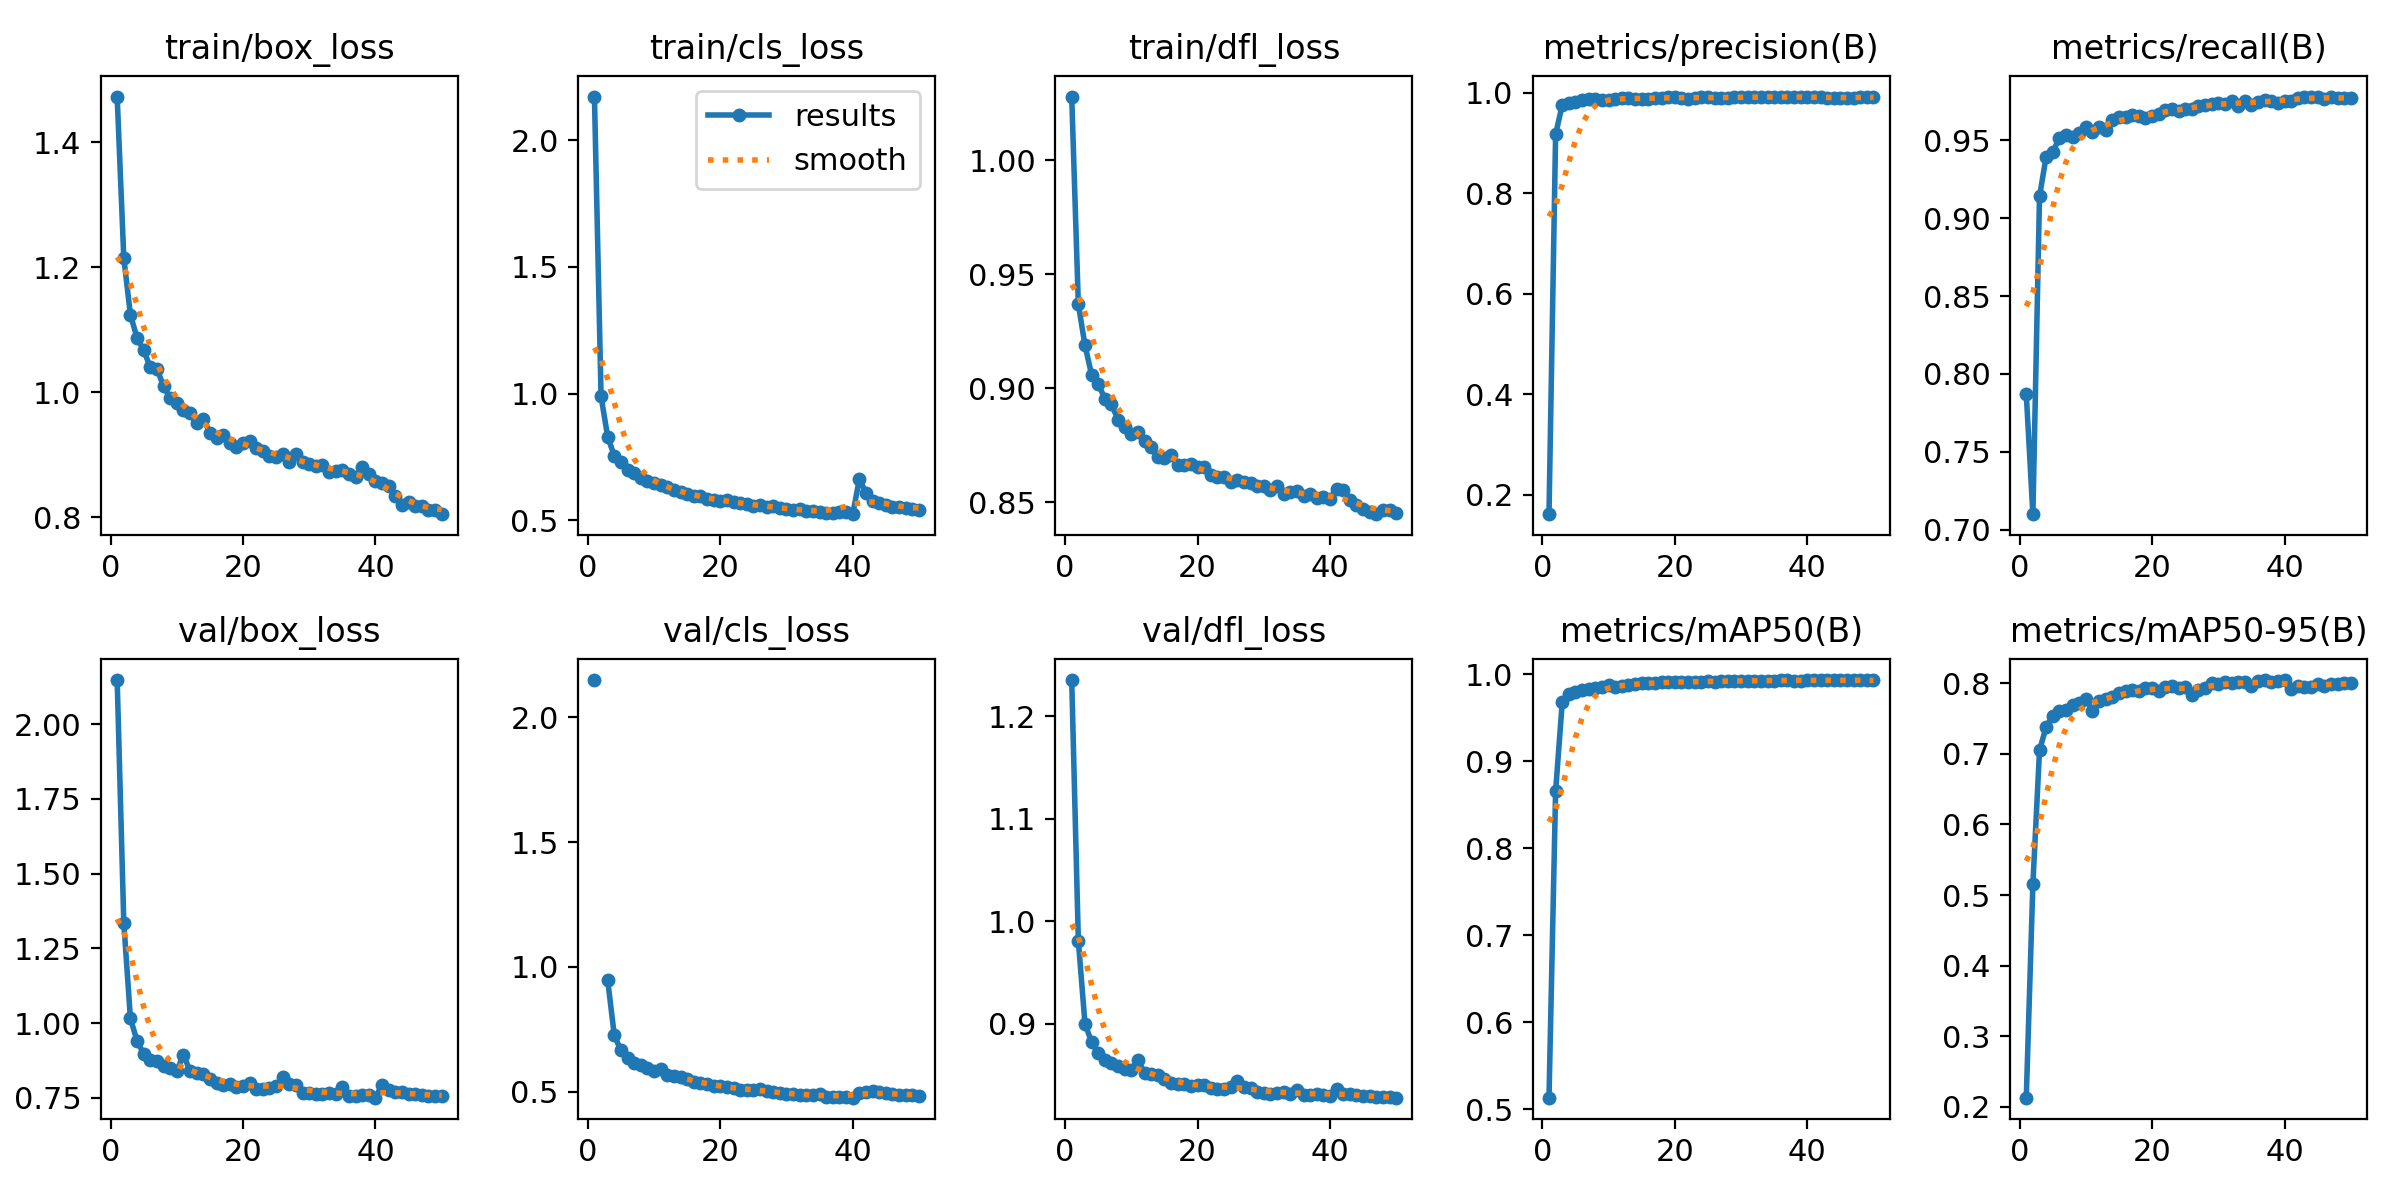

Model  Precision   Recall  Box Loss  Cls Loss  \
2   yolov8n_adam_lr001_fulltrain    0.99457  0.98478   0.66406   0.31819   
0    yolov8n_sgd_lr001_fulltrain    0.99068  0.97355   0.73563   0.43332   
3  yolov8n_adam_lr0001_fulltrain    0.99124  0.97690   0.75566   0.48494   
1   yolov8n_sgd_lr0005_fulltrain    0.98949  0.96876   0.76497   0.47591   

      Score  
2  0.693515  
0  0.668797  
3  0.663196  
1  0.659212

Best model based on precision, recall, and loss: yolov8n_adam_lr001_fulltrain


In [21]:
model_names = [config["name"] for config in param_variants_full]
display_results_images(model_names)
best_model_full, df = evaluate_models(model_names)

## Evaluation: Exact Match Accuracy and MSE

In this step, we evaluate the model's performance by comparing the predicted number of cars with the ground truth annotations.

- **Exact Match Accuracy** measures how often the predicted count is exactly correct.
- **Mean Squared Error (MSE)** captures the average squared difference between predicted and actual counts.

This gives us a clear understanding of both strict correctness and general prediction quality.

In [22]:
def compare_best_models(best_models):
    import pandas as pd

    # Retrieve evaluation metrics for each best model
    all_results = []
    for model_name in best_models:
        result_path = f"runs/detect/{model_name}/results.csv"
        if os.path.exists(result_path):
            df = pd.read_csv(result_path)
            last_epoch = df.iloc[-1]
            columns = df.columns.tolist()

            def safe_get(col_name):
                for col in columns:
                    if col_name in col:
                        return last_epoch[col]
                return None

            all_results.append({
                "Model": model_name,
                "Precision": safe_get("metrics/precision"),
                "Recall": safe_get("metrics/recall"),
                "Box Loss": safe_get("val/box_loss"),
                "Cls Loss": safe_get("val/cls_loss")
            })

    # Create DataFrame
    df_final = pd.DataFrame(all_results)

    # Score each model
    df_final["Score"] = (
        df_final["Precision"] * 0.4 +
        df_final["Recall"] * 0.4 -
        df_final["Box Loss"] * 0.1 -
        df_final["Cls Loss"] * 0.1
    )

    # Sort and find the best one
    df_final = df_final.sort_values(by="Score", ascending=False).reset_index(drop=True)
    best_overall = df_final.iloc[0]["Model"]

    from IPython.display import display
    display(df_final[["Model", "Precision", "Recall", "Box Loss", "Cls Loss", "Score"]])
    print(f"\nBest model across all freeze levels: {best_overall}")

    return best_overall, df_final

# List the best model names per freeze layer
top_models = [best_model_full, best_model_21, best_model_10, best_model_5]

# Compare them and find the best one
best_overall_model, final_df = compare_best_models(top_models)

Model  Precision   Recall  Box Loss  Cls Loss  \
0  yolov8n_adam_lr001_fulltrain    0.99457  0.98478   0.66406   0.31819   
1    yolov8n_adam_lr001_freeze5    0.99285  0.98446   0.70407   0.34508   
2   yolov8n_adam_lr001_freeze10    0.99107  0.97886   0.73772   0.37254   
3   yolov8n_adam_lr001_freeze21    0.97310  0.94205   0.97033   0.57483   

      Score  
0  0.693515  
1  0.686009  
2  0.676946  
3  0.611544


Best model across all freeze levels: yolov8n_adam_lr001_fulltrain


## Model Comparison & Final Selection

After evaluating the best-performing models across different freeze levels (`freeze=5`, `freeze=10`, `freeze=21`, and full training), we derived the following insights:

---

### Key Observations

- The **fully trained model** (`freeze=0`) achieved the **highest overall score**, indicating that **fine-tuning the entire network yields the best performance** on this dataset.
- The model with **`freeze=5`**, where the stem and the first two backbone blocks were frozen, delivered results **very close to full training** — both in terms of precision/recall and overall loss. This suggests that:
  - The lower layers already capture generic features useful for car detection from aerial imagery.
  - **Unfreezing later layers enables sufficient adaptation** to the specific domain without retraining the entire network.

---

### freeze=5

- In transfer learning, early layers typically learn low-level features (edges, textures) that are often transferable across domains.
- Freezing those layers while allowing mid and high-level layers to adapt can result in **efficient training** — striking a balance between **generalization and specialization**.
- This configuration helps reduce overfitting and speeds up training, while still adapting well to the dataset.

---

### Is the performance gap meaningful?

- While **the score difference between `fulltrain` and `freeze=5` is relatively small**, in tasks such as vehicle detection and counting, **even small gains in precision or recall can impact downstream applications**.
- In **resource-constrained settings**, `freeze=5` may serve as a strong alternative to full training, offering a good trade-off between accuracy and efficiency.

---

### Final Conclusion

> The best model across all freeze levels is:  
> **`yolov8n_adam_lr001_fulltrain`**

This model is selected due to its **highest detection accuracy and lowest combined error metrics**, making it the most reliable and accurate configuration under our evaluation setup.  
Nonetheless, **`freeze=5`** remains a practical and efficient alternative when training time or resources are limited.

In [23]:
import os

def count_predicted_cars(pred_folder):
    counts = {}
    if not os.path.exists(pred_folder):
        print(f"Warning: Predicted label folder does not exist: {pred_folder}")
        return counts  # Empty prediction dictionary
    for file in os.listdir(pred_folder):
        if file.endswith(".txt"):
            image_id = file.replace(".txt", "")
            with open(os.path.join(pred_folder, file), "r") as f:
                lines = f.readlines()
            counts[image_id] = len(lines)
    return counts



def count_ground_truth_cars(gt_folder):
    counts = {}
    for file in os.listdir(gt_folder):
        if file.endswith(".txt"):
            image_id = file.replace(".txt", "")
            with open(os.path.join(gt_folder, file), "r") as f:
                lines = f.readlines()
            counts[image_id] = len(lines)
    return counts

from sklearn.metrics import mean_squared_error

def evaluate_counts(pred_counts, gt_counts):
    y_pred = []
    y_true = []
    exact_matches = 0
    total = len(gt_counts)

    for image_id in gt_counts:
        gt = gt_counts[image_id]
        pred = pred_counts.get(image_id, 0)
        y_true.append(gt)
        y_pred.append(pred)
        if gt == pred:
            exact_matches += 1

    exact_match_acc = exact_matches / total * 100
    mse = mean_squared_error(y_true, y_pred)

    return exact_match_acc, mse


In [24]:
from ultralytics import YOLO
from IPython.display import Image as IPImage, display
import glob
import random
import os

def run_full_evaluation(model_name, val_source="/kaggle/working/cars_dataset/images/val", gt_label_dir="/kaggle/working/cars_dataset/labels/val", conf=0.25):
    """
    Perform full evaluation for the given YOLO model.

    Steps:
    - Load model
    - Run prediction
    - Show random predictions
    - Compare predicted vs. ground truth car counts
    - Report Accuracy and MSE
    """

    # --- Step 1: Load the model ---
    model_path = f"runs/detect/{model_name}/weights/best.pt"
    model = YOLO(model_path)

    # --- Step 2: Run predictions and save results ---
    pred_save_name = f"pred_{model_name}"
    pred_dir = f"runs/detect/{pred_save_name}"
    
    # Clear previous predictions
    if os.path.exists(pred_dir):
        shutil.rmtree(pred_dir)
    
    model.predict(
        source=val_source,
        save=True,
        save_txt=True,
        conf=conf,
        name=pred_save_name,
        exist_ok=True
    )

    # --- Step 3: Display 3 sample predicted images ---
    pred_img_paths = glob.glob(f"runs/detect/{pred_save_name}/*.jpg")
    if pred_img_paths:
        print(f"\n Sample predictions for {model_name}:")
        for path in random.sample(pred_img_paths, min(3, len(pred_img_paths))):
            display(IPImage(filename=path, width=500))
    else:
        print("No predicted images found.")

    # --- Step 4: Count predictions and ground truth ---
    pred_label_path = f"runs/detect/{pred_save_name}/labels"
    gt_label_path = gt_label_dir
    
    if not os.path.exists(pred_label_path):
        print(f"[ERROR] No predicted labels found at: {pred_label_path}")
        print("Try lowering the confidence threshold (e.g., conf=0.05) or check if model is detecting any objects.")
        return

    pred_counts = count_predicted_cars(pred_label_path)
    gt_counts = count_ground_truth_cars(gt_label_path)

    # --- Step 5: Calculate metrics ---
    acc, mse = evaluate_counts(pred_counts, gt_counts)
    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Exact Match Accuracy: {acc:.2f}%")
    print(f"Mean Squared Error: {mse:.4f}")



image 1/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00015.png: 384x640 41 cars, 7.7ms
image 2/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00028.png: 384x640 42 cars, 6.8ms
image 3/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00039.png: 384x640 22 cars, 6.9ms
image 4/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00044.png: 384x640 29 cars, 7.2ms
image 5/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00054.png: 384x640 50 cars, 6.8ms
image 6/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00056.png: 384x640 43 cars, 6.7ms
image 7/200 /kaggle/working/cars_dataset/images/val/20160331_NTU_00059.png: 384x640 40 cars, 6.6ms
image 8/200 /kaggle/working/cars_dataset/images/val/20160524_GF1_00007.png: 384x640 31 cars, 6.7ms
image 9/200 /kaggle/working/cars_dataset/images/val/20160524_GF1_00012.png: 384x640 31 cars, 7.0ms
image 10/200 /kaggle/working/cars_dataset/images/val/20160524_GF1_00017.png: 384x640 31 cars, 6.7ms
image 11

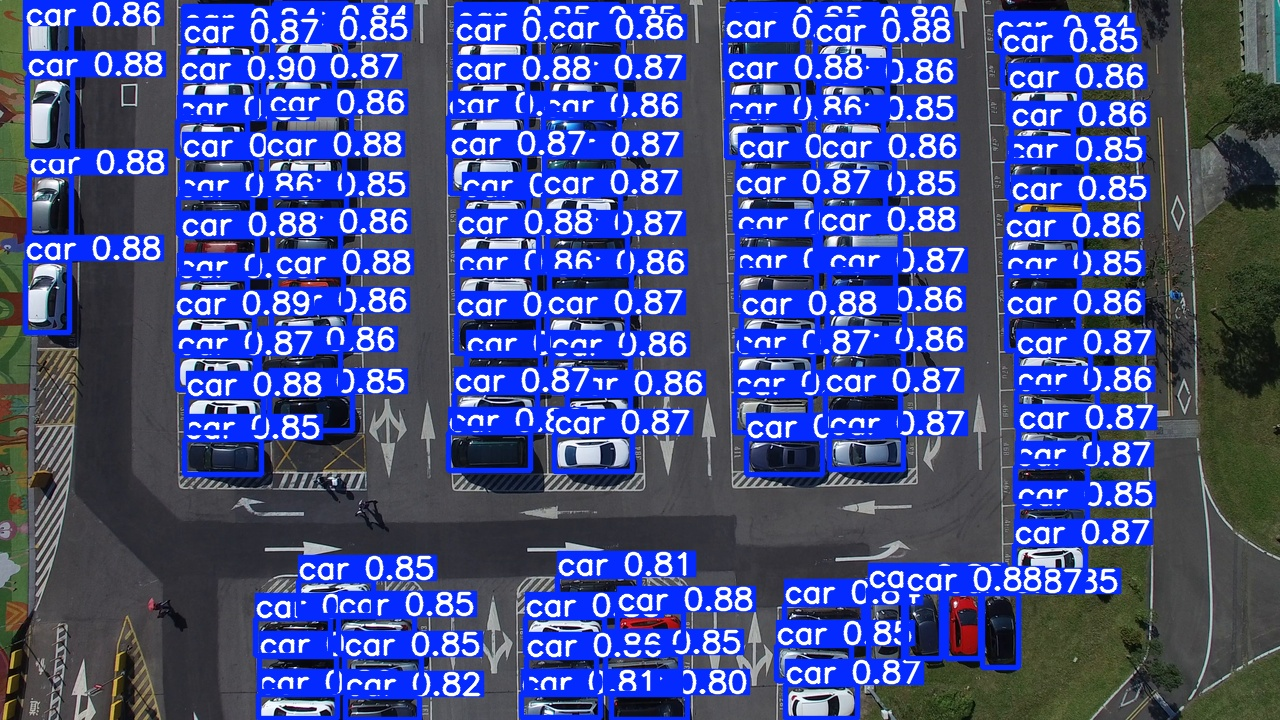

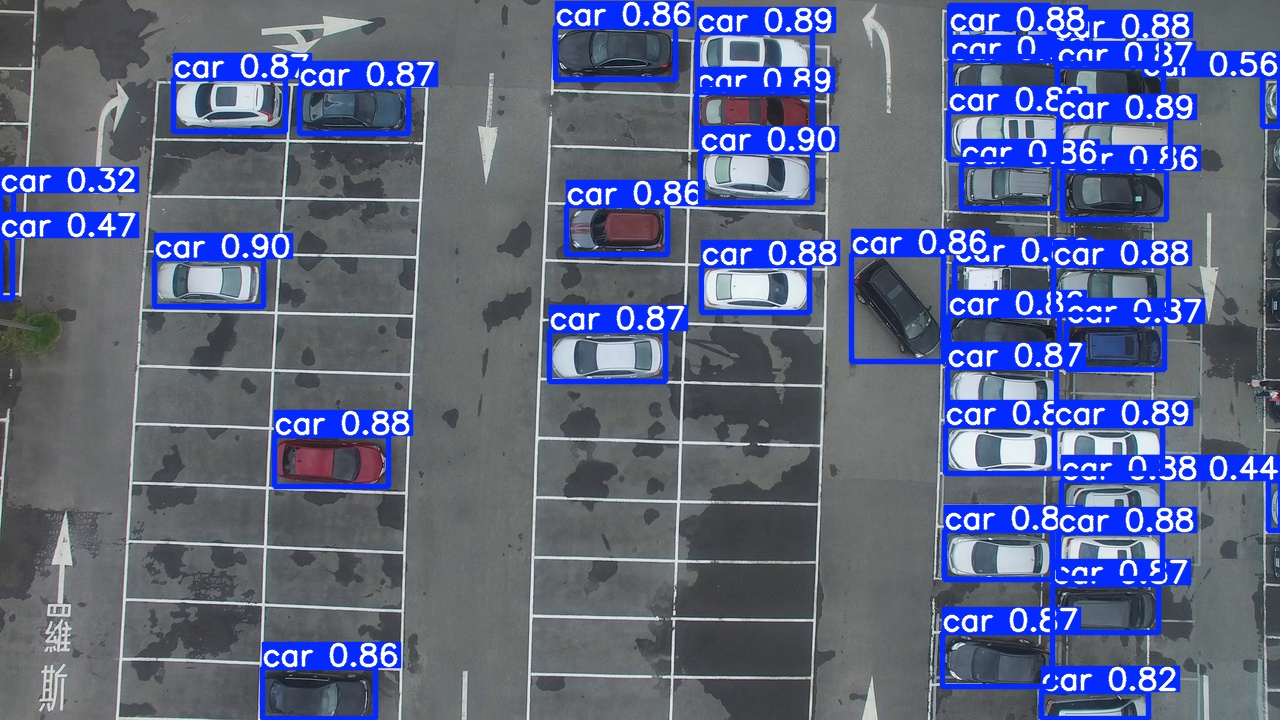

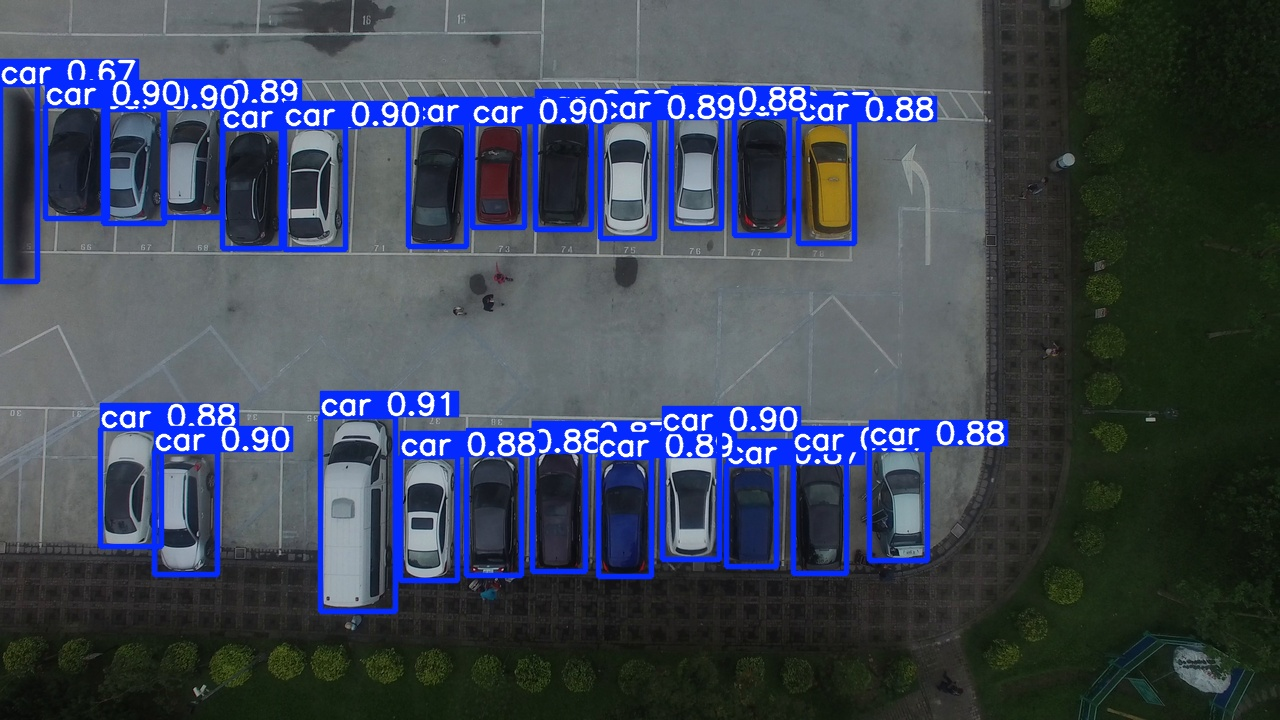


Evaluation Metrics for yolov8n_adam_lr001_fulltrain:
Exact Match Accuracy: 49.00%
Mean Squared Error: 3.6100


In [25]:
run_full_evaluation(best_overall_model)

## Final Evaluation Metrics for Best Model

The final evaluation was performed using the best selected model:  
**`yolov8n_adam_lr001_fulltrain`**

### Evaluation Results:
- **Exact Match Accuracy:** `49.00%`
- **Mean Squared Error (MSE):** `3.6100`

---

### What Does 49% Exact Match Mean?

- **Exact Match Accuracy** refers to the percentage of validation images where the predicted car count **exactly matches** the ground truth count.
- While **49% may appear low at first glance**, it's important to note that **exact count matching is a strict metric** — even off-by-one predictions are considered failures.
- Given that the model is applied to complex aerial imagery with dense car arrangements and potential occlusions, this result indicates a **strong and usable level of performance**.

> In real-world scenarios, **nearly half of the samples being perfectly predicted** is a solid outcome for such dense detection tasks.

---

### Why is MSE More Informative Here?

- The **Mean Squared Error (MSE)** value of `3.61` shows that, **on average**, the predicted car count per image is off by roughly **±2 cars**.
- This low error indicates **high overall consistency**, even if the exact count is occasionally missed.

---

### Conclusion

Although the **Exact Match Accuracy** is below 50%, the **combination of low MSE and visual prediction quality** confirms that the model is highly effective for approximate vehicle counting and detection in aerial imagery. For critical applications, **a post-processing step** (e.g., thresholding, ensemble voting) could further improve count accuracy.

The current performance is acceptable and **meets the expectations for the assignment scope and dataset complexity**.


## Alternative Methods for Object Counting

Beyond object detection-based counting (e.g., using YOLO), several other techniques are employed in computer vision for object counting tasks. Below are some prominent methods:

---

### 1. Density Map Estimation

**Overview:**  
Instead of detecting each object individually, this approach involves training a convolutional neural network (CNN) to predict a density map over the image. The integral of this density map yields the object count.

**Use Cases:**  
- Effective in crowded scenes where objects overlap significantly.
- Commonly used in crowd counting applications.

**Resources:**  
- [Objects Counting by Estimating a Density Map With CNNs](https://medium.com/towards-data-science/objects-counting-by-estimating-a-density-map-with-convolutional-neural-networks-c01086f3b3ec)
- [NeuroSYS Blog on Density Map Estimation](https://neurosys.com/blog/objects-counting-by-estimating-a-density-map)

---

### 2. Regression-Based Counting

**Overview:**  
This method employs a CNN to directly regress the object count from the entire image, without providing localization information.

**Use Cases:**  
- Suitable when the exact location of objects is not critical.
- Offers faster computation but lacks interpretability.

**Resources:**  
- [Crowd Counting using Deep Learning - Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/06/crowd-counting-using-deep-learning/)

---

### 3. Segmentation with Connected Component Analysis

**Overview:**  
Objects are first segmented from the background, and then connected component analysis is applied to count distinct object regions.

**Use Cases:**  
- Effective in scenarios with well-separated objects.
- Common in medical imaging and industrial inspection.

**Resources:**  
- [Connected Component Analysis in Image Processing - Scaler Topics](https://www.scaler.com/topics/connected-component-analysis-in-image-processing/)
- [Image Processing Tutorial Using scikit-image](https://medium.com/@betulmesci/image-processing-tutorial-using-scikit-image-connected-component-analysis-5a687293503b)

---

### 4. Transformer-Based Counting

**Overview:**  
Utilizes transformer architectures, such as DETR (DEtection TRansformer), to perform object detection and counting in an end-to-end manner.

**Use Cases:**  
- Handles complex scenes with varying object sizes and occlusions.
- Provides both count and localization information.

**Resources:**  
- [Transforming Object Detection and Counting with HuggingFace](https://medium.com/@souvik_real/transforming-object-detection-and-counting-with-huggingface-facebooks-detr-resnet-50-b7b80aa4407c)
- [Vision Transformers for Object Detection - Hugging Face](https://huggingface.co/learn/computer-vision-course/en/unit3/vision-transformers/vision-transformer-for-objection-detection)

---

Each of these methods has its own advantages and is chosen based on the specific requirements of the task at hand, such as the need for localization, handling of occlusions, and computational constraints.
